# MultiEval Confidence-aware Example

This notebook demonstrates a basic parameter sweep with LensKits `MultiEval` class.

## Setup

We first need to import our libraries.

In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Jacob\\Documents\\GitHub\\lenskit_confidence')

In [2]:
from lenskit.batch_ca import MultiEval
#from lenskit.crossfold import partition_users, SampleN
#from lenskit.algorithms import basic, als, item_knn, user_knn
#from lenskit.datasets import MovieLens
#from lenskit import topn, util #, metrics
from lenskit.metrics import predict
import pandas as pd
import matplotlib.pyplot as plt

from lenskit.algorithms_ca import user_knn_ca, Recommender
from lenskit.metrics.predict import rmse
from lenskit import datasets
from lenskit.datasets import MovieLens
from lenskit import crossfold as xf
from lenskit import topn, datasets, batch_ca # *not* batch 
from lenskit import topn, util #, metrics
from lenskit.crossfold import partition_users, SampleN, partition_rows
import pandas as pd
import logging


Progress bars are useful:

In [3]:
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

C:\Users\Jacob\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


It takes a little while to run things, and can get kinda quiet in here. Let's set up logging so we can see the logging output in the notebook's message stream:

In [4]:
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


Then set up the data access.

In [49]:
#mlsmall = MovieLens('../data/ml-latest-small')
mlsmall = MovieLens('../data/ml-1m')
#mlsmall = MovieLens('../data/ml-10m')
#mlsmall = MovieLens('../data/ml-20m')

## Experiment

We're going to run our evaluation and store its output in the `my-eval` directory, generating 20-item recommendation lists::

In [50]:
eval = MultiEval('my-eval', predict = True, recommend = 30)

We're going to use a 5-fold cross-validation setup.  We save the data into a list in memory so we have access to the test data later.  In a larger experiment, you might write the partitions to disk and pass the file names to `add_datasets`.

In [7]:
pairs = list(partition_users(mlsmall.ratings, 5, SampleN(5)))
#pairs = (partition_users(mlsmall.ratings, 5, SampleN(5)))
pairs

[   INFO] lenskit.crossfold partitioning 100004 rows for 671 users into 5 partitions
[   INFO] lenskit.crossfold fold 0: selecting test ratings
[   INFO] lenskit.crossfold fold 0: partitioning training data
[   INFO] lenskit.crossfold fold 1: selecting test ratings
[   INFO] lenskit.crossfold fold 1: partitioning training data
[   INFO] lenskit.crossfold fold 2: selecting test ratings
[   INFO] lenskit.crossfold fold 2: partitioning training data
[   INFO] lenskit.crossfold fold 3: selecting test ratings
[   INFO] lenskit.crossfold fold 3: partitioning training data
[   INFO] lenskit.crossfold fold 4: selecting test ratings
[   INFO] lenskit.crossfold fold 4: partitioning training data


[TTPair(train=        user  item  rating   timestamp
 0          1    31     2.5  1260759144
 1          1  1029     3.0  1260759179
 2          1  1061     3.0  1260759182
 3          1  1129     2.0  1260759185
 4          1  1172     4.0  1260759205
 ...      ...   ...     ...         ...
 99999    671  6268     2.5  1065579370
 100000   671  6269     4.0  1065149201
 100001   671  6365     4.0  1070940363
 100002   671  6385     2.5  1070979663
 100003   671  6565     3.5  1074784724
 
 [99329 rows x 4 columns], test=       user  item  rating   timestamp
 486       6  4975     1.5  1109258226
 485       6  4641     1.5  1109258217
 479       6  2761     4.5  1108134545
 478       6  2723     3.0  1109258257
 461       6  1285     4.5  1108134339
 ...     ...   ...     ...         ...
 99846   669  2881     3.0  1015829395
 99822   669   260     5.0  1015829081
 99851   669  3219     3.0  1015829662
 99828   669  1135     3.0  1015829160
 99852   669  3326     2.0  1015829081
 
 [67

In [51]:
eval.add_datasets(pairs, name = 'ML-Small')

In [52]:
nhbr_range = [10, 25]

In [ ]:
#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Weighted')

#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'sum') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Sum')

In [53]:
eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-Weighted')

#eval.add_algorithms([user_knn.UserUser(nnbrs = f, aggregate = 'sum') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'UserKNN-Sum')

And add a popular baseline for comparison:

In [ ]:
eval.add_algorithms(basic.Popular(), name = 'Pop')

And finally, we will run the experiment!

In [ ]:
eval.run(progress = tqdm)

[   INFO] lenskit.batch_ca._multi_ca starting run 1: UserUserCA(nnbrs=10, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=10, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=10, min_sim=0) on 99329 ratings
[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 99329 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnbrs=10, min_sim=0) in  66ms
[   INFO] lenskit.batch_ca._multi_ca generating 675 predictions for TopN/UserUserCA(nnbrs=10, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=10, min_sim=0) to 1135 pickle bytes with 13 buffers of 2983816 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._predict_ca generating 675 predictions for 135 users (setup took  17ms)
[   INFO] lenskit.batch_ca._p

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 263 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 267 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 271 in  24ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 4.000000/5 predictions for 275 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 278 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 282 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 290 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 316 in  13ms


[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 600 in  10ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 591 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 608 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 609 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 629 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 643 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 621 in  45ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 659 in  12ms


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 18
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.647704    18  0.000000       1.0
4754      5.647704    18  0.000000       1.0
40412     5.647704    18  0.000000       1.0
92494     5.647704    18  0.000000       1.0
4302      5.639105    18  0.000000       1.0
4731      5.639105    18  0.000000       1.0
5071      5.639105    18  0.000000       1.0
86781     5.639105    18  0.000000       1.0
97957     5.635382    18  1.807764       2.0
3437      5.413847    18  0.000000       1.0
5765      5.413847    18  0.000000       1.0
5490      5.366633    18  0.000000       1.0
132333    5.366633    18  0.000000       1.0
67504     5.294952    18  0.000000       1.0
83318     5.294952    18  0.000000       1.0
83359     5.294952    18  0.000000       1.0
83411     5.294952    18  0.000000       1.0
32289     5.1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 36 in  192ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.620728       2    43  0.368017      10.0
3         2.239602       3    43  1.019311      10.0
4         1.769471       4    43  0.763799      10.0
5         2.956841       5    43  0.480049      10.0
6         3.161313       6    43  0.316253      10.0
...            ...     ...   ...       ...       ...
161944    3.487552  161944    43  0.000000       1.0
162376    4.144824  162376    43  0.000000       1.0
162542    4.347619  162542    43  0.000000       1.0
162672    2.347619  162672    43  0.000000       1.0
163949    4.652255  163949    43  0.000000       1.0

[8951 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._re

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.069947       1    57  0.612361      10.0
2         3.539235       2    57  0.446890      10.0
3         2.657446       3    57  0.803029      10.0
4         2.929569       4    57  0.969545      10.0
5         3.045037       5    57  0.917680      10.0
...            ...     ...   ...       ...       ...
161944    4.458700  161944    57  0.000000       1.0
162376    5.115972  162376    57  0.000000       1.0
162542         NaN  162542    57  0.000000       0.0
162672         NaN  162672    57  0.000000       0.0
163949    5.623404  163949    57  0.000000       1.0

[8852 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 53
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.142932    5

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 58 in  185ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 66
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 60
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.251758       1    60  0.525551      10.0
2         3.919795       2    60  0.237478      10.0
3         3.597518       3    60  1.005602      10.0
4         3.149794       4    60  0.965524       5.0
5         3.550688       5    60  1.186992      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    60  0.000000       0.0
162376    5.265776  162376    60  0.000000       1.0
162542         NaN  162542    60  0.000000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 68
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1859      5.996879    68  0.000000       1.0
3320      5.996879    68  0.000000       1.0
4302      5.996879    68  0.000000       1.0
4731      5.996879    68  0.000000       1.0
5071      5.996879    68  0.000000       1.0
26131     5.996879    68  0.000000       1.0
3879      5.864546    68  0.000000       1.0
3437      5.771621    68  0.000000       1.0
5765      5.771621    68  0.000000       1.0
5490      5.724408    68  0.000000       1.0
132333    5.724408    68  0.000000       1.0
67504     5.652726    68  0.000000       1.0
83318     5.652726    68  0.000000       1.0
83359     5.652726    68  0.000000       1.0
83411     5.652726    68  0.000000       1.0
149       5.607742    68  0.616009       3.0
109249    5.535311    68  0.000000       1.0
32289     5.5

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 79 in  163ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 98
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 90
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.578241       2    90  0.967121      10.0
3         3.457226       3    90  0.811703      10.0
4         2.537335       4    90  0.644187      10.0
5         4.047427       5    90  0.961492      10.0
7         3.258016       7    90  1.975048      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    90  0.000000       0.0
162376    4.881332  162376    90  0.000000       1.0
162542         NaN  162542    90  0.000000       0.0
162

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 101
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.220657       1   101  0.461638      10.0
2         3.551209       2   101  0.107777      10.0
3         3.510190       3   101  1.712790      10.0
4         2.680379       4   101  0.817761      10.0
5         3.233155       5   101  0.601642      10.0
...            ...     ...   ...       ...       ...
161944    4.338504  161944   101  0.000000       1.0
162376    4.995776  162376   101  0.000000       1.0
162542    5.198571  162542   101  0.000000       1.0
162672    3.198571  162672   101  0.000000       1.0
163949         NaN  163949   101  0.000000       0.0

[9006 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 101
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 111 in  164ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 115
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 116
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.674317       1   115  0.383409      10.0
4         3.193403       4   115  0.851214      10.0
5         4.030546       5   115  0.597381      10.0
6         4.532659       6   115  0.639649      10.0
7         3.671827       7   115  0.898725      10.0
...            ...     ...   ...       ...       ...
161944    4.676837  161944   115  0.000000       1.0
162376    5.334110  162376   115  0.000000       1.0
162542         NaN  162542   115  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 122
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 118
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.189581       2   122  0.512900      10.0
3         2.627091       3   122  1.168223      10.0
4         1.767340       4   122  0.872288       9.0
5         3.007724       5   122  1.024275      10.0
6         3.149340       6   122  0.594737      10.0
...            ...     ...   ...       ...       ...
161944    3.411361  161944   122  0.000000       1.0
162376    4.068634  162376   122  0.000000       1.0
162542    4.271429  162542   122  0.000000       1.0
162672    2.271429  162672   122  0.000000       1.0
163949    4.576065  163949   122  0.000000       1.0

[9021 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 123
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.607378       1   127  0.816687      10.0
2         4.564382       2   127  0.654969      10.0
3         3.916116       3   127  1.600796      10.0
4         2.915519       4   127  0.761748       9.0
6         4.281044       6   127  0.429150      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   127  0.000000       0.0
162376         NaN  162376   127  0.000000       0.0
162542         NaN  162542   127  0.000000       0.0
162672         NaN  162672   127  0.000000       0.0
163949         NaN  163949   127  0.000000       0.0

[9040 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.172549   1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 135 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 145
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 143
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.651292       1   143  0.423226      10.0
2         3.803076       2   143  0.228199      10.0
3         3.525597       3   143  0.346681      10.0
4         2.685271       4   143  1.029707       7.0
5         3.036200       5   143  0.593071      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   143  0.000000       0.0
162376    4.750776  162376   143  0.000000       1.0
162542    4.953571  162542   143  0.000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 154
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 148
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.170604   148  0.000000       1.0
1450      7.033567   148  0.000000       1.0
1563      7.033567   148  0.000000       1.0
1819      7.033567   148  0.000000       1.0
4076      7.033567   148  0.000000       1.0
4591      7.033567   148  0.000000       1.0
4796      7.033567   148  0.000000       1.0
4930      7.033567   148  0.000000       1.0
5427      7.033567   148  0.000000       1.0
107559    6.635959   148  0.000000       1.0
3216      6.390771   148  0.000000       1.0
92494     6.390771   148  0.000000       1.0
4302      6.382172   148  0.000000       1.0
4731      6.382172   148  0.000000       1.0
5071      6.382172   148  0.000000       1.0
3437      6.156914   148  0.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 155 in  189ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.754211       3   157  0.675219      10.0
4         2.299865       4   157  0.842751      10.0
5         2.587599       5   157  1.758489      10.0
6         3.936480       6   157  0.725248      10.0
7         2.673758       7   157  1.337787      10.0
...            ...     ...   ...       ...       ...
161944    3.868815  161944   157  0.000000       1.0
162376    4.526088  162376   157  0.000000       1.0
162542    4.728883  162542   157  0.000000       1.0
162672    2.728883  162672   157  0.000000       1.0
163949    5.033519  163949   157  0.000000       1.0

[8735 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._r

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 164
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.375209       2   163  0.452940      10.0
3         2.627372       3   163  0.810384      10.0
4         2.234951       4   163  0.878835       9.0
5         2.716721       5   163  1.284664      10.0
6         3.694750       6   163  0.437614      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   163  0.000000       0.0
162376    4.303408  162376   163  0.000000       1.0
162542    4.506203  162542   163  0.000000       1.0
162672    2.506203  162672   163  0.000000       1.0
163949    4.810839  163949   163  0.000000       1.0

[8980 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.551281      

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 166 in  151ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 169
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.596822       1   167  2.269974      10.0
2         3.203793       2   167  0.715208      10.0
3         3.121321       3   167  1.395618      10.0
4         2.078692       4   167  1.380235       5.0
5         3.222181       5   167  0.752038      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   167  0.000000       0.0
162376         NaN  162376   167  0.000000       0.0
162542         NaN  162542   167  0.000000       0.0
162672         NaN  162672   167  0.000000       0.0
163949    5.370050  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 170
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.970683       1   172  1.128008      10.0
2         3.410874       2   172  0.600374      10.0
3         3.900323       3   172  0.602052      10.0
4         2.655282       4   172  1.192356       8.0
5         3.193205       5   172  0.395765      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   172  0.000000       0.0
162376         NaN  162376   172  0.000000       0.0
162542         NaN  162542   172  0.000000       0.0
162672         NaN  162672   172  0.000000       0.0
163949    5.475313  163949   172  0.000000       1.0

[9037 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 174
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 175
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.251975       2   175  0.263111      10.0
3         3.227309       3   175  0.483833      10.0
4         2.630418       4   175  0.952049      10.0
5         3.509684       5   175  0.535323      10.0
6         3.979460       6   175  0.538253      10.0
...            ...     ...   ...       ...       ...
161944    4.193504  161944   175  0.000000       1.0
162376    4.850776  162376   175  0.000000       1.0
162542         NaN  162542   175  0.000000       0.0
162672         NaN  162672   175  0.000000       0.0
163949    5.358208  163949   175  0.000000       1.0

[8936 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 181 in  184ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 176
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       5.969869   176  0.000000       1.0
1450      5.969869   176  0.000000       1.0
1563      5.969869   176  0.000000       1.0
1819      5.969869   176  0.000000       1.0
4076      5.969869   176  0.000000       1.0
4518      5.969869   176  0.000000       1.0
4591      5.969869   176  0.000000       1.0
4796      5.969869   176  0.000000       1.0
4930      5.969869   176  0.000000       1.0
5427      5.969869   176  0.000000       1.0
3216      5.327073   176  0.000000       1.0
26974     5.327073   176  0.000000       1.0
92494     5.327073   176  0.000000       1.0
1859      5.318474   176  0.000000       1.0
4302      5.318474   176  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 186 in  195ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 196
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 188
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 196
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.120919       1   188  0.517061      10.0
2         3.635444       2   188  0.490294      10.0
3         2.935605       3   188  0.598866      10.0
4         2.638073       4   188  0.817761      10.0
5         3.242263       5   188  0.333527      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   188  0.000000       0.0
162376    4.694197  162376   188

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.367827       1   204  1.319157      10.0
2         3.277876       2   204  0.235236      10.0
3         2.474223       3   204  0.559603      10.0
4         1.839540       4   204  0.797701       8.0
5         3.212427       5   204  0.793393      10.0
...            ...     ...   ...       ...       ...
161944    3.814658  161944   204  0.000000       1.0
162376    4.471930  162376   204  0.000000       1.0
162542         NaN  162542   204  0.000000       0.0
162672         NaN  162672   204  0.000000       0.0
163949    4.979362  163949   204  0.000000       1.0

[9030 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 204
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 209
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.800927       1   211  0.953157      10.0
2         4.205016       2   211  0.662453      10.0
3         3.476571       3   211  1.318252      10.0
4         3.099171       4   211  0.842751      10.0
5         3.995833       5   211  0.509018      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   211  0.000000       0.0
162376    5.385776  162376   211  0.000000       1.0
162542         NaN  162542   211  0.000000       0.0
162672         NaN  162672   211  0.000000       0.0
163949    5.893208  163949   211  0.000000       1.0

[9006 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1859      5.444902   2

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 213 in  230ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 220
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 214
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.039199   214  0.000000       1.0
1563      7.039199   214  0.000000       1.0
1819      7.039199   214  0.000000       1.0
4076      7.039199   214  0.000000       1.0
4518      7.039199   214  0.000000       1.0
4591      7.039199   214  0.000000       1.0
4796      7.039199   214  0.000000       1.0
4930      7.039199   214  0.000000       1.0
5427      7.039199   214  0.000000       1.0
3216      6.396404   214  0.000000       1.0
92494     6.396404   214 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 226 in  187ms
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 220 in  239ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 256
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 241
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 256
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.820286       1   256  0.288069      10.0
2         2.977700       2   256  0.467572      10.0
4         2.126441       4   256  1.140635       6.0
8         2.5798

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 263
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.512332       1   267  0.530883      10.0
2         3.837303       2   267  0.305658      10.0
3         3.527469       3   267  0.974006      10.0
4         3.212500       4   267  0.818370      10.0
5         3.731082       5   267  0.354767      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   267  0.000000       0.0
162376    5.236888  162376   267  0.000000       1.0
162542         NaN  162542   267  0.000000       0.0
162672         NaN  162672   267  0.000000       0.0
163949    5.744319  163949   267  0.000000       1.0

[9020 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 271
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 275
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.912935   271  0.000000       1.0
1450      6.775898   271  0.000000       1.0
1563      6.775898   271  0.000000       1.0
1819      6.775898   271  0.000000       1.0
4076      6.775898   271  0.000000       1.0
4518      6.775898   271  0.000000       1.0
4591      6.775898   271  0.000000       1.0
4796      6.775898   271  0.000000       1.0
4930      6.775898   271  0.000000       1.0
5427      6.775898   271  0.000000       1.0
3216      6.133103   271  0.000000       1.0
26974     6.133103   271  0.000000       1.0
92494     6.133103   271  0.000000       1.0
4302      6.124504   271  0.000000       1.0
4731      6.124504   271  0.000000       1.0
5071      6.12

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 278 in  227ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 290
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.181172       2   282  0.180320      10.0
3         2.592599       3   282  1.459368      10.0
4         2.789243       4   282  0.678742       8.0
5         3.123184       5   282  1.128633      10.0
6         3.742011       6   282  0.449392      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   282  0.000000       0.0
162376    4.752826  162376   282  0.000000       1.0
162542         NaN  162542   282  0.000000       0.0
162672         NaN  162672   282  0.000000       0.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.239430   316  0.000000       1.0
3216      5.994242   316  0.000000       1.0
92494     5.994242   316  0.000000       1.0
97957     5.994242   316  0.000000       1.0
3879      5.853309   316  0.000000       1.0
3437      5.760385   316  0.000000       1.0
5765      5.760385   316  0.000000       1.0
9010      5.760385   316  0.000000       1.0
5490      5.713171   316  0.000000       1.0
132333    5.713171   316  0.000000       1.0
67504     5.641490   316  0.000000       1.0
83318     5.641490   316  0.000000       1.0
83359     5.641490   316  0.000000       1.0
83411     5.641490   316  0.000000       1.0
4086      5.557064   316  0.000000       1.0
93040     5.524074   316  0.000000       1.0
109249    5.524074   316  0.000000       1.0
32289     5.516643   316  0.000000       1.0
41573     5.516643   316  0.000000       1.0
48791     5.51

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 332 in  167ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 342
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 339
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 342
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.962521       1   339  0.475480      10.0
2         3.524683       2   339  0.469704      10.0
3         2.982749       3   339  1.179352      10.0
4         2.396729       4   339  0.736378       8.0
5         3.814959       5   339  0.769083      10.0
...            ...     ...   ...       ...       ...
161944    4.253504  161944   339  0.000000       1.0
162376    4.910776  162376   339

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.341880       1   349  1.144417      10.0
2         3.047094       2   349  0.498544      10.0
3         2.503399       3   349  0.777735      10.0
4         2.647309       4   349  0.276771       8.0
5         2.890455       5   349  0.985800      10.0
...            ...     ...   ...       ...       ...
161944    3.968504  161944   349  0.000000       1.0
162376    4.625776  162376   349  0.000000       1.0
162542         NaN  162542   349  0.000000       0.0
162672         NaN  162672   349  0.000000       0.0
163949    5.133208  163949   349  0.000000       1.0

[9038 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 346
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 353
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 354
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.768738       2   354  0.280553      10.0
3         3.859569       3   354  1.222138      10.0
4         2.820029       4   354  1.084080       8.0
5         2.862148       5   354  1.594288      10.0
6         3.987348       6   354  0.781507      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   354  0.000000       0.0
162376    5.040670  162376   354  0.000000       1.0
162542         NaN  162542   354  0.000000       0.0
162672         NaN  162672   354  0.000000       0.0
163949    5.548101  163949   354  0.000000       1.0

[9009 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 360 in  175ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 362
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.786834   357  0.000000       1.0
40412     6.786834   357  0.000000       1.0
92494     6.786834   357  0.000000       1.0
4302      6.778235   357  0.000000       1.0
4731      6.778235   357  0.000000       1.0
5071      6.778235   357  0.000000       1.0
86781     6.778235   357  0.000000       1.0
3437      6.552977   357  0.000000       1.0
4630      6.552977   357  0.000000       1.0
5765      6.552977   357  0.000000       1.0
67504     6.434082   357  0.000000       1.0
83318     6.434082   357  0.000000       1.0
83359     6.434082   357  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 362 in  181ms
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 366 in  170ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 384
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 375
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 375
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 384
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.661617       1   375  0.581533      10.0
2         3.885152       2   375  0.282938      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 394
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.096928       1   400  0.890528      10.0
2         3.577006       2   400  0.325075      10.0
3         3.339781       3   400  0.672667      10.0
4         2.659093       4   400  0.582749      10.0
5         3.218013       5   400  0.230334      10.0
...            ...     ...   ...       ...       ...
161944    4.034542  161944   400  0.000000       1.0
162376    4.691814  162376   400  0.000000       1.0
162542    4.894609  162542   400  0.000000       1.0
162672    2.894609  162672   400  0.000000       1.0
163949    5.199246  163949   400  0.000000       1.0

[9003 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 400
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 410
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.833456       1   410  0.537444      10.0
2         4.009195       2   410  0.349622      10.0
3         3.296769       3   410  0.269880      10.0
4         3.063188       4   410  0.161102       5.0
5         3.817833       5   410  0.594462      10.0
...            ...     ...   ...       ...       ...
161944    4.316330  161944   410  0.000000       1.0
162376    4.973602  162376   410  0.000000       1.0
162542    5.176398  162542   410  0.000000       1.0
162672    3.176398  162672   410  0.000000       1.0
163949         NaN  163949   410  0.000000       0.0

[9033 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 404
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 414 in  160ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 419
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 415
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.934392   415  0.000000       1.0
1563      6.934392   415  0.000000       1.0
1819      6.934392   415  0.000000       1.0
4076      6.934392   415  0.000000       1.0
4591      6.934392   415  0.000000       1.0
4796      6.934392   415  0.000000       1.0
4930      6.934392   415  0.000000       1.0
5427      6.934392   415  0.000000       1.0
3320      6.282997   415  0.000000       1.0
4302      6.282997   415  0.000000       1.0
4731      6.282997   415 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 420 in  195ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 434
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 427
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.269702       1   427  0.490388      10.0
2         3.159078       2   427  0.709422      10.0
3         2.737704       3   427  1.132604      10.0
4         2.389002       4   427  0.739453       7.0
5         3.194568       5   427  2.113322      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   427  0.000000       0.0
162376    5.011590  162376   427  0.000000       1.0
162542         NaN  162542   427  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.728484       1   441  0.965825      10.0
2         3.208290       2   441  0.513293      10.0
3         2.872409       3   441  1.811583      10.0
4         2.566555       4   441  1.218728       7.0
5         2.765008       5   441  1.292886      10.0
...            ...     ...   ...       ...       ...
161944    4.316330  161944   441  0.000000       1.0
162376    4.973602  162376   441  0.000000       1.0
162542         NaN  162542   441  0.000000       0.0
162672         NaN  162672   441  0.000000       0.0
163949    5.481034  163949   441  0.000000       1.0

[8941 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 437
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 441
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 447
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.575937       3   447  0.869921      10.0
4         1.807255       4   447  0.816017       8.0
5         3.055090       5   447  0.338915      10.0
7         2.726485       7   447  0.557836      10.0
8         2.702061       8   447  2.736231       3.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   447  0.000000       0.0
162376    4.137972  162376   447  0.000000       1.0
162542         NaN  162542   447  0.000000       0.0
162672         NaN  162672   447  0.000000       0.0
163949    4.645403  163949   447  0.000000       1.0

[8974 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 442
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 449 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 476
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 471
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.659961   471  0.000000       1.0
1563      6.659961   471  0.000000       1.0
1819      6.659961   471  0.000000       1.0
4076      6.659961   471  0.000000       1.0
4591      6.659961   471  0.000000       1.0
4796      6.659961   471  0.000000       1.0
4930      6.659961   471  0.000000       1.0
5427      6.659961   471  0.000000       1.0
3216      6.017166   471  0.000000       1.0
4754      6.017166   471  0.000000       1.0
92494     6.017166   471 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 481 in  163ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 494
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 483
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 494
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.538084       1   483  0.878531      10.0
2         3.025776       2   483  0.095222      10.0
3         2.987261       3   483  1.303779      10.0
4         2.457624       4   483  0.842751      10.0
5         2.980020       5   483  1.740338      10.0
...            ...     ...   ...       ...       ...
161944    4.056223  161944   483  0.000000       1.0
162376    4.713496  162376   483

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.695812       1   497  0.904974      10.0
2         3.549169       2   497  0.518544      10.0
3         3.111408       3   497  0.628759      10.0
4         2.468494       4   497  0.993752       8.0
5         2.785198       5   497  1.652949      10.0
...            ...     ...   ...       ...       ...
161944    4.278504  161944   497  0.000000       1.0
162376    4.935776  162376   497  0.000000       1.0
162542         NaN  162542   497  0.000000       0.0
162672         NaN  162672   497  0.000000       0.0
163949    5.443208  163949   497  0.000000       1.0

[8956 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 497
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 500
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.121895       1   505  0.686208      10.0
2         2.778916       2   505  0.548235      10.0
4         2.101751       4   505  1.077444       8.0
5         2.425866       5   505  0.699109      10.0
6         3.451458       6   505  0.674258      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   505  0.000000       0.0
162376    4.395007  162376   505  0.000000       1.0
162542         NaN  162542   505  0.000000       0.0
162672         NaN  162672   505  0.000000       0.0
163949    4.902439  163949   505  0.000000       1.0

[8666 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 503
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 505
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 519 in  147ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.611193   510  0.000000       1.0
92494     5.611193   510  0.000000       1.0
97957     5.611193   510  0.000000       1.0
4302      5.602594   510  0.000000       1.0
4731      5.602594   510  0.000000       1.0
5071      5.602594   510  0.000000       1.0
40412     5.597639   510  1.777577       2.0
3879      5.470261   510  0.000000       1.0
67504     5.258441   510  0.000000       1.0
83318     5.258441   510  0.000000       1.0
83359     5.258441   510  0.000000       1.0
83411     5.258441   510  0.000000       1.0
1859      5.247031   510  0.884617       2.0
109249    5.141026   510  0.000000       1.0
42718     5.102594   510  0.000000       1.0
91653     5.102594   510  0.000000       1.0
107910    5.102594   510  0.0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 527 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 550
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 550
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 530
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.477681       2   530  0.576964      10.0
3         3.330554       3   530  1.872915      10.0
4         2.718245       4   530  0.923861      10.0
5         3.267990       5   530  1.135778      10.0
6         4.081135       6   530  0.633596      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   530  0.000000       0.0
162376    4.975091  162376   530

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 553
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 551
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.512676       2   553  0.468723      10.0
3         3.966304       3   553  0.708625      10.0
4         3.223743       4   553  0.771877       6.0
5         3.747829       5   553  0.528165      10.0
6         4.306720       6   553  0.446757      10.0
...            ...     ...   ...       ...       ...
161944    4.463402  161944   553  0.000000       1.0
162376    5.120674  162376   553  0.000000       1.0
162542         NaN  162542   553  0.000000       0.0
162672         NaN  162672   553  0.000000       0.0
163949         NaN  163949   553  0.000000       0.0

[8860 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.385562   554  0.000000       1.0
1563      6.385562   554  0.000000       1.0
1819      6.385562   554  0.000000       1.0
4076      6.385562   554  0.000000       1.0
4518      6.385562   554  0.000000       1.0
4591      6.385562   554  0.000000       1.0
4796      6.385562   554  0.000000       1.0
4930      6.385562   554  0.000000       1.0
5427      6.385562   554  0.000000       1.0
3216      5.742767   554  0.000000       1.0
26974     5.742767   554  0.000000       1.0
92494     5.742767   554  0.000000       1.0
4302      5.734167   554  0.000000       1.0
4731      5.734167   554  0.000000       1.0
5071      5.734167   554  0.000000       1.0
40412     5.538272   554  1.777577       2.0
3437      5.508910   554  0.000000       1.0
5765      5.508910   554  0.000000       1.0
132333    5.461696   554  0.000000       1.0
86781     5.39

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.754037       2   560  0.577043      10.0
3         3.755763       3   560  0.831108      10.0
4         2.823305       4   560  0.926667      10.0
5         3.663719       5   560  0.896799      10.0
6         4.380816       6   560  0.690621      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   560  0.000000       0.0
162376    5.036303  162376   560  0.000000       1.0
162542         NaN  162542   560  0.000000       0.0
162672         NaN  162672   560  0.000000       0.0
163949    5.543734  163949   560  0.000000       1.0

[8961 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 560
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 567
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 571
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.545499       1   567  1.358636      10.0
2         4.586983       2   567  0.318151      10.0
3         4.215313       3   567  0.845688      10.0
4         3.022989       4   567  0.000000       1.0
5         4.013896       5   567  0.700700      10.0
...            ...     ...   ...       ...       ...
161944    4.830573  161944   567  0.000000       1.0
162376    5.487845  162376   567  0.000000       1.0
162542    5.690640  162542   567  0.000000       1.0
162672    3.690640  162672   567  0.000000       1.0
163949    5.995277  163949   567  0.000000       1.0

[9027 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 572 in  213ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 578
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.241616       3   575  1.418578      10.0
4         2.317442       4   575  0.582749      10.0
5         2.817214       5   575  0.172164      10.0
6         3.515840       6   575  0.741833      10.0
8         2.519383       8   575  2.171017       5.0
...            ...     ...   ...       ...       ...
161944    3.861493  161944   575  0.000000       1.0
162376    4.518765  162376   575  0.000000       1.0
162542         NaN  162542   575  0.000000       0.0
162672         NaN  162672   575  0.000000       0.0
163949    5.026197  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 584
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.927305   584  0.000000       1.0
1450      6.790268   584  0.000000       1.0
1563      6.790268   584  0.000000       1.0
1819      6.790268   584  0.000000       1.0
4076      6.790268   584  0.000000       1.0
4518      6.790268   584  0.000000       1.0
4591      6.790268   584  0.000000       1.0
4796      6.790268   584  0.000000       1.0
4930      6.790268   584  0.000000       1.0
5427      6.790268   584  0.000000       1.0
1859      6.138874   584  0.000000       1.0
4302      6.138874   584  0.000000       1.0
4731      6.138874   584  0.000000       1.0
5071      6.138874   584  0.000000       1.0
3437      5.913616   584  0.000000       1.0
5765      5.913616   584  0.000000       1.0
565       5.886835   584  3.333600       2.0
132333    5.

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 600
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.545511       1   600  0.610614      10.0
2         3.739451       2   600  0.476573      10.0
3         2.844746       3   600  1.270311      10.0
4         3.012180       4   600  0.715188       4.0
5         3.877918       5   600  0.288679      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   600  0.000000       0.0
162376         NaN  162376   600  0.000000       0.0
162542    5.295238  162542   600  0.000000       1.0
162672    3.295238  162672   600  0.000000       1.0
163949         NaN  163949   600  0.000000       0.0

[9026 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 591 in  176ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calli

[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 621
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         2.335741       1   609  0.839533      10.0
2         1.909666       2   609  0.258692      10.0
3         1.204431       3   609  1.203873      10.0
4         1.207817       4   609  0.391583       5.0
5         1.525527       5   609  0.715035      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   609  0.000000       0.0
162376    3.096147  162376   609  0.000000       1.0
162542         NaN  162542   609  0.000000       0.0
162672         NaN  162672   609  0.000000       0.0
163949    3.603578  163949   609  0.000000       1.0

[8921 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 621
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for us

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 629 in  153ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 659
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 659
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.469547       1   643  0.912297      10.0
2         2.929054       2   643  0.133625      10.0
3         3.219943       3   643  1.279912      10.0
4         2.461307       4   643  0.788741       7.0
5         2.660730       5   643  0.477459      10.0
...            ...     ...   ...       ...       ...
161944    3.863241  161944   643  0.000000       1.0
162376    4.520513  162376   643  0.000000       1.0
162542    4.723308  162542   643  0.000000       1.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.774220       1   665  0.194201      10.0
4         2.245975       4   665  0.524151       9.0
6         3.749095       6   665  0.671895      10.0
7         2.837295       7   665  1.514783      10.0
8         3.398088       8   665  2.782582       4.0
...            ...     ...   ...       ...       ...
161944    3.755217  161944   665  0.000000       1.0
162376    4.412490  162376   665  0.000000       1.0
162542    4.615285  162542   665  0.000000       1.0
162672    2.615285  162672   665  0.000000       1.0
163949    4.919921  163949   665  0.000000       1.0

[8627 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 663
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 665
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 669 in  129ms
[   INFO] lenskit.batch_ca._recommend_ca         item  prediction  user  var  num_nbhr  rank
0     106441    5.926894     6  0.0       1.0     1
1     107559    5.926894     6  0.0       1.0     2
2       3216    5.681706     6  0.0       1.0     3
3       4754    5.681706     6  0.0       1.0     4
4      92494    5.681706     6  0.0       1.0     5
...      ...         ...   ...  ...       ...   ...
4045   83318    5.409082   669  0.0       1.0    26
4046   83359    5.409082   669  0.0       1.0    27
4047   83411    5.409082   669  0.0       1.0    28
4048  109249    5.291667   669  0.0       1.0    29
4049  107910    5.253235   669  0.0       1.0    30

[4050 rows x 6 columns]
[   INFO] lenskit.batch_ca._recommend_ca recommended for 135 users in 23.65s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 24.18s
[   INFO] lenskit.batch_ca._multi_ca run

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 199 in  19ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 209 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 211 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 213 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 214 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 220 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 241 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 226 in  17ms


[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 560 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 567 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 563 in  26ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 571 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 572 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 575 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 578 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 584 in  11ms


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 19
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
5         2.671088       5    19  1.032970      25.0
8         2.550795       8    19  2.860212       4.0
12        2.664448      12    19  0.838206      14.0
13        4.047228      13    19  0.777582       6.0
15        1.974233      15    19  1.600656       8.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    19  0.000000       0.0
162376    4.661662  162376    19  0.000000       1.0
162542    4.864457  162542    19  0.000000       1.0
162672    2.864457  162672    19  0.000000       1.0
163949    5.169093  163949    19  0.000000       1.0

[8638 rows x 5 columns]
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 19
[   INFO] lenskit.algorithms

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.709369       2    43  0.556120      25.0
3         2.393140       3    43  1.548217      25.0
4         1.770822       4    43  0.776826      11.0
5         2.940951       5    43  0.580880      25.0
6         3.249537       6    43  0.475114      25.0
...            ...     ...   ...       ...       ...
161944    3.487552  161944    43  0.000000       1.0
162376    4.144824  162376    43  0.000000       1.0
162542    4.347619  162542    43  0.000000       1.0
162672    2.347619  162672    43  0.000000       1.0
163949    4.652255  163949    43  0.000000       1.0

[8951 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 36
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.655892    3

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 52 in  144ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 53
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 57
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.142932    53  0.000000       1.0
4754      5.142932    53  0.000000       1.0
92494     5.142932    53  0.000000       1.0
1859      5.134333    53  0.000000       1.0
4302      5.134333    53  0.000000       1.0
4731      5.134333    53  0.000000       1.0
5071      5.134333    53  0.000000       1.0
86781     5.134333    53  0.000000       1.0
3437      4.909075    53  0.000000       1.0
5765      4.909075    53  0.000000       1.0
9010      4.909075    53  0.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 58 in  168ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 66
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 60
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.146810       1    60  0.657764      25.0
2         3.870736       2    60  0.307271      25.0
3         3.525329       3    60  0.948438      25.0
4         3.149794       4    60  0.965524       5.0
5         3.575921       5    60  1.180079      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    60  0.000000       0.0
162376    5.265776  162376    60  0.000000       1.0
162542         NaN  162542    60  0.000000       0.0
162

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 68
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 69
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.069830       3    68  0.879965      25.0
4         2.636158       4    68  0.524151       9.0
5         3.584915       5    68  0.560586      25.0
6         4.042479       6    68  0.527852      25.0
7         3.224809       7    68  1.200016      25.0
...            ...     ...   ...       ...       ...
161944    4.087148  161944    68  0.000000       1.0
162376    4.744420  162376    68  0.000000       1.0
162542    4.947215  162542    68  0.000000       1.0
162672    2.947215  162672    68  0.000000       1.0
163949    5.251852  163949    68  0.000000       1.0

[8938 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 79
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.511723       2    90  0.562637      25.0
3         3.252742       3    90  0.912145      25.0
4         2.537426       4    90  0.582944      11.0
5         3.712345       5    90  0.903139      25.0
7         3.352697       7    90  0.969027      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    90  0.000000       0.0
162376    4.881332  162376    90  0.000000       1.0
162542         NaN  162542    90  0.000000       0.0
162672         NaN  162672    90  0.000000       0.0
163949    5.388763  163949    90  0.000000       1.0

[9011 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     5.756667    7

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.036667   101  0.000000       1.0
3216      6.256834   101  0.000000       1.0
4754      6.256834   101  0.000000       1.0
26974     6.256834   101  0.000000       1.0
92494     6.256834   101  0.000000       1.0
4302      6.248235   101  0.000000       1.0
4731      6.248235   101  0.000000       1.0
5071      6.248235   101  0.000000       1.0
86781     6.033986   101  2.356681       2.0
3437      6.022977   101  0.000000       1.0
5765      6.022977   101  0.000000       1.0
132333    5.975764   101  0.000000       1.0
1859      5.906659   101  0.884617       2.0
67504     5.904082   101  0.000000       1.0
83318     5.904082   101  0.000000       1.0
83359     5.904082   101  0.000000       1.0
83411     5.904082   101  0.000000       1.0
2938      5.900617   101  2.175410       2.0
32289     5.779236   101  0.000000       1.0
41573     5.77

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 111 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 116
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 115
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 116
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.089545       1   116  0.767556      25.0
2         3.561497       2   116  0.365671      25.0
3         3.074957       3   116  1.237031      25.0
4         3.050981       4   116  0.175626       6.0
5         3.419938       5   116  0.609180      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   116  0.000000       0.0
162376    5.000776  162376   116

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.087026       2   122  0.542771      25.0
3         2.583566       3   122  0.883456      25.0
4         1.767340       4   122  0.872288       9.0
5         2.851256       5   122  0.994126      25.0
6         3.163002       6   122  0.543288      25.0
...            ...     ...   ...       ...       ...
161944    3.411361  161944   122  0.000000       1.0
162376    4.068634  162376   122  0.000000       1.0
162542    4.271429  162542   122  0.000000       1.0
162672    2.271429  162672   122  0.000000       1.0
163949    4.576065  163949   122  0.000000       1.0

[9021 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 118
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 122
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 123
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 127
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.172549   123  0.000000       1.0
40412     6.172549   123  0.000000       1.0
92494     6.172549   123  0.000000       1.0
97957     6.172549   123  0.000000       1.0
26974     6.035369   123  2.193730       2.0
3879      6.031616   123  0.000000       1.0
3437      5.938692   123  0.000000       1.0
4630      5.938692   123  0.000000       1.0
5765      5.938692   123  0.000000       1.0
67504     5.819796   123  0.000000       1.0
83318     5.819796   123  0.000000       1.0
83359     5.819796   123  0.000000       1.0
83411     5.819796   123  0.000000       1.0
121231    5.782791   123  1.292903       3.0
33171     5.710303   123  1.364333       3.0
79428     5.64

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 135 in  155ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 145
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 143
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.654630   143  0.000000       1.0
1563      6.654630   143  0.000000       1.0
1819      6.654630   143  0.000000       1.0
4076      6.654630   143  0.000000       1.0
4518      6.654630   143  0.000000       1.0
4591      6.654630   143  0.000000       1.0
4796      6.654630   143  0.000000       1.0
4930      6.654630   143  0.000000       1.0
5427      6.654630   143  0.000000       1.0
107559    6.257022   143  0.000000       1.0
3216      6.011834   143 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 145 in  199ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 155
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 154
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 155
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.982662       2   154  0.501864      25.0
3         3.783443       3   154  1.111365      25.0
4         2.666793       4   154  1.064616       9.0
6         4.208765       6   154  0.737540      25.0
8         4.187297       8   154  0.000000       1.0
...            ...     ...   ...       ...       ...
161944    4.420885  161944   154  0.000000       1.0
162376    5.078157  162376   154

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 157
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.959944       1   160  0.984627      25.0
2         4.038035       2   160  0.491991      25.0
3         3.111146       3   160  0.924393      25.0
4         2.764883       4   160  1.066684       7.0
5         3.748832       5   160  0.467862      25.0
...            ...     ...   ...       ...       ...
161944    4.394820  161944   160  0.000000       1.0
162376         NaN  162376   160  0.000000       0.0
162542    5.254887  162542   160  0.000000       1.0
162672    3.254887  162672   160  0.000000       1.0
163949         NaN  163949   160  0.000000       0.0

[8961 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 160
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 164
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.453164       2   164  0.477947      25.0
3         2.964836       3   164  1.312764      25.0
4         3.017597       4   164  0.893751      11.0
5         2.928196       5   164  1.142242      25.0
6         3.726812       6   164  0.608952      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   164  0.000000       0.0
162376    4.833569  162376   164  0.000000       1.0
162542    5.036364  162542   164  0.000000       1.0
162672    3.036364  162672   164  0.000000       1.0
163949    5.341000  163949   164  0.000000       1.0

[8979 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 163
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores afte

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 166 in  170ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 169
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.766472   167  0.000000       1.0
735       6.766472   167  0.000000       1.0
1450      6.766472   167  0.000000       1.0
1563      6.766472   167  0.000000       1.0
1819      6.766472   167  0.000000       1.0
3892      6.766472   167  0.000000       1.0
4076      6.766472   167  0.000000       1.0
4591      6.766472   167  0.000000       1.0
4796      6.766472   167  0.000000       1.0
4930      6.766472   167  0.000000       1.0
5427      6.766472   167  0.000000       1.0
81        5.939795   167  7.423583       3.0
5490      5.842606   167  0

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 172
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 170 in  173ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 174
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.941083       1   172  0.882478      25.0
2         3.448918       2   172  0.714093      25.0
3         3.734514       3   172  1.153645      25.0
4         2.655282       4   172  1.192356       8.0
5         3.325749       5   172  0.664942      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   172  0.000000       0.0
162376         NaN  162376   172  0.000000       0.0
162542         NaN  162542   172  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 176
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 175
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.455587       3   176  1.146103      25.0
4         1.843858       4   176  0.778768      11.0
5         2.631064       5   176  0.894943      25.0
6         3.223844       6   176  0.486259      25.0
7         2.853284       7   176  1.182136      25.0
...            ...     ...   ...       ...       ...
161944    3.408743  161944   176  0.000000       1.0
162376    4.066015  162376   176  0.000000       1.0
162542    4.268810  162542   176  0.000000       1.0
162672    2.268810  162672   176  0.000000       1.0
163949    4.573447  163949   176  0.000000       1.0

[8805 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.174678       1   182  0.866323      25.0
6         4.132410       6   182  0.539898      25.0
10        3.814286      10   182  0.436978      25.0
12        3.452141      12   182  0.915850      12.0
14        3.353328      14   182  0.864398      15.0
...            ...     ...   ...       ...       ...
161944    4.278028  161944   182  0.000000       1.0
162376    4.935300  162376   182  0.000000       1.0
162542    5.138095  162542   182  0.000000       1.0
162672    3.138095  162672   182  0.000000       1.0
163949         NaN  163949   182  0.000000       0.0

[8930 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 181
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.682289   1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 188 in  162ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 196
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.990991   186  0.000000       1.0
3216      6.211159   186  0.000000       1.0
26974     6.211159   186  0.000000       1.0
92494     6.211159   186  0.000000       1.0
4302      6.202560   186  0.000000       1.0
4731      6.202560   186  0.000000       1.0
5071      6.202560   186  0.000000       1.0
86781     6.202560   186  0.000000       1.0
3879      6.070226   186  0.000000       1.0
3437      5.977302   186  0.000000       1.0
5765      5.977302   186  0.000000       1.0
132333    5.930088   186  0.000000       1.0
9010      5.892898   186  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 199 in  205ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 209
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.322102       1   204  1.144686      25.0
2         3.233606       2   204  0.334597      25.0
3         2.713383       3   204  0.970756      25.0
4         1.839540       4   204  0.797701       8.0
5         3.136986       5   204  0.855008      25.0
...            ...     ...   ...       ...       ...
161944    3.814658  161944   204  0.000000       1.0
162376    4.471930  162376   204  0.000000       1.0
162542         NaN  162542   204  0.000000       0.0
162672         NaN  162672   204  0.000000       0.0
163949    4.979362  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 213
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.167151       1   211  0.921481      25.0
2         4.217418       2   211  0.420760      25.0
3         3.600655       3   211  1.047784      25.0
4         3.099171       4   211  0.842751      10.0
5         3.989294       5   211  0.878054      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   211  0.000000       0.0
162376    5.385776  162376   211  0.000000       1.0
162542         NaN  162542   211  0.000000       0.0
162672         NaN  162672   211  0.000000       0.0
163949    5.893208  163949   211  0.000000       1.0

[9006 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.519786      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 220
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 214
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.039199   214  0.000000       1.0
1563      7.039199   214  0.000000       1.0
1819      7.039199   214  0.000000       1.0
4076      7.039199   214  0.000000       1.0
4518      7.039199   214  0.000000       1.0
4591      7.039199   214  0.000000       1.0
4796      7.039199   214  0.000000       1.0
4930      7.039199   214  0.000000       1.0
5427      7.039199   214  0.000000       1.0
3216      6.396404   214  0.000000       1.0
92494     6.396404   214  0.000000       1.0
4302      6.387805   214  0.000000       1.0
4731      6.387805   214  0.000000       1.0
5071      6.387805   214  0.000000       1.0
3879      6.255471   214  0.000000       1.0
3437      6.16

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 226 in  177ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 256
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 241
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    5.828101   241  0.000000       1.0
3216      5.582913   241  0.000000       1.0
92494     5.582913   241  0.000000       1.0
4302      5.574314   241  0.000000       1.0
4731      5.574314   241  0.000000       1.0
5071      5.574314   241  0.000000       1.0
132333    5.301842   241  0.000000       1.0
67504     5.230161   241  0.000000       1.0
83318     5.230161   241  0.000000       1.0
83359     5.230161   241  0.000000       1.0
83411     5.230161   241 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 263 in  180ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 267
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 271
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.426393       1   267  0.467908      25.0
2         3.860960       2   267  0.471118      25.0
3         3.375418       3   267  0.831224      25.0
4         3.212500       4   267  0.818370      10.0
5         3.698909       5   267  0.939682      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   267  0.000000       0.0
162376    5.236888  162376   267  0.000000       1.0
162542         NaN  162542   267  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 278
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 275
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         4.388599       2   275  0.416109      25.0
4         3.107583       4   275  0.998744       9.0
5         4.177649       5   275  0.662124      25.0
6         5.000320       6   275  0.801526      25.0
7         4.339141       7   275  1.155296      25.0
...            ...     ...   ...       ...       ...
161944    4.917743  161944   275  0.000000       1.0
162376    5.575015  162376   275  0.000000       1.0
162542    5.777810  162542   275  0.000000       1.0
162672    3.777810  162672   275  0.000000       1.0
163949    6.082446  163949   275  0.000000       1.0

[8859 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 282
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.656679   282  0.000000       1.0
1450      6.656679   282  0.000000       1.0
1563      6.656679   282  0.000000       1.0
1819      6.656679   282  0.000000       1.0
3892      6.656679   282  0.000000       1.0
4076      6.656679   282  0.000000       1.0
4518      6.656679   282  0.000000       1.0
4591      6.656679   282  0.000000       1.0
4796      6.656679   282  0.000000       1.0
4930      6.656679   282  0.000000       1.0
5427      6.656679   282  0.000000       1.0
3216      6.013883   282  0.000000       1.0
26974     6.013883   282  0.000000       1.0
92494     6.013883   282  0.000000       1.0
3437      5.780027   282  0.000000       1.0
5765      5.780027   282  0.000000       1.0
5490      5.732813   282  0.000000       1.0
5915      5.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 316 in  182ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 332
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 330
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.537783       1   330  0.960416      25.0
2         3.591717       2   330  0.498952      25.0
3         2.755967       3   330  1.068358      25.0
4         2.344983       4   330  0.859750       8.0
5         3.433746       5   330  0.457419      25.0
...            ...     ...   ...       ...       ...
161944    3.935171  161944   330  0.000000       1.0
162376    4.592443  162376   330  0.000000       1.0
162542         NaN  162542   330  0.000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 339
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.951667   339  0.000000       1.0
107559    6.417022   339  0.000000       1.0
3216      6.171834   339  0.000000       1.0
4754      6.171834   339  0.000000       1.0
92494     6.171834   339  0.000000       1.0
1859      6.163235   339  0.000000       1.0
4302      6.163235   339  0.000000       1.0
4731      6.163235   339  0.000000       1.0
5071      6.163235   339  0.000000       1.0
149       6.008179   339  0.616009       3.0
5893      5.984682   339  1.522560       2.0
3437      5.937977   339  0.000000       1.0
5765      5.937977   339  0.000000       1.0
5915      5.890764   339  0.000000       1.0
132333    5.890764   339  0.000000       1.0
3320      5.816327   339  1.878105       2.0
55250     5.704432   339  4.684564       2.0
107910    5.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 346 in  157ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 353
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 349
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.436671       1   349  1.108369      25.0
2         3.262389       2   349  0.541963      25.0
3         2.725093       3   349  0.985499      25.0
4         2.647309       4   349  0.276771       8.0
5         3.099464       5   349  0.823622      25.0
...            ...     ...   ...       ...       ...
161944    3.968504  161944   349  0.000000       1.0
162376    4.625776  162376   349  0.000000       1.0
162542         NaN  162542   349  0.000000       0.0


[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 357
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.816005       2   354  0.330446      25.0
3         3.587799       3   354  1.268509      25.0
4         2.820029       4   354  1.084080       8.0
5         3.105533       5   354  1.145640      25.0
6         4.226207       6   354  0.639046      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   354  0.000000       0.0
162376    5.040670  162376   354  0.000000       1.0
162542         NaN  162542   354  0.000000       0.0
162672         NaN  162672   354  0.000000       0.0
163949    5.548101  163949   354  0.000000       1.0

[9009 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 354
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 362
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.817508   360  0.000000       1.0
1563      6.817508   360  0.000000       1.0
1819      6.817508   360  0.000000       1.0
4076      6.817508   360  0.000000       1.0
4591      6.817508   360  0.000000       1.0
4796      6.817508   360  0.000000       1.0
4930      6.817508   360  0.000000       1.0
5427      6.817508   360  0.000000       1.0
3216      6.174713   360  0.000000       1.0
92494     6.174713   360  0.000000       1.0
4302      6.166114   360  0.000000       1.0
4731      6.166114   360  0.000000       1.0
5071      6.166114   360  0.000000       1.0
4518      6.153953   360  3.619106       2.0
4754      6.122653   360  5.037721       2.0
86781     5.997960   360  2.356681       2.0
97957     5.984658   360  1.807764       2.0
3437      5.9408

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 366 in  157ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 384
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.630415       1   375  0.723401      25.0
2         3.708947       2   375  0.497258      25.0
3         2.959698       3   375  1.311155      25.0
4         2.693783       4   375  0.828108       7.0
5         3.091180       5   375  1.150724      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   375  0.000000       0.0
162376    4.675776  162376   375  0.000000       1.0
162542    4.878571  162542   375  0.000000       1.0
162672    2.878571  162672   375  0.000000       1.0
163949    5.183208  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      5.814630   394  0.000000       1.0
1563      5.814630   394  0.000000       1.0
1819      5.814630   394  0.000000       1.0
4076      5.814630   394  0.000000       1.0
4591      5.814630   394  0.000000       1.0
4796      5.814630   394  0.000000       1.0
4930      5.814630   394  0.000000       1.0
5427      5.814630   394  0.000000       1.0
3216      5.171834   394  0.000000       1.0
92494     5.171834   394  0.000000       1.0
4302      5.163235   394  0.000000       1.0
4731      5.163235   394  0.000000       1.0
5071      5.163235   394  0.000000       1.0
3437      4.937977   394  0.000000       1.0
5765      4.937977   394  0.000000       1.0
132333    4.890764   394  0.000000       1.0
5893      4.758486   394  1.522560       2.0
32289     4.694236   394  0.000000       1.0
41573     4.694236   394  0.000000       1.0
48791     4.69

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 404 in  153ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 414
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.171586       1   410  0.659633      25.0
2         3.879835       2   410  0.661739      25.0
3         3.375854       3   410  0.577669      21.0
4         3.063188       4   410  0.161102       5.0
5         3.788984       5   410  0.720740      25.0
...            ...     ...   ...       ...       ...
161944    4.316330  161944   410  0.000000       1.0
162376    4.973602  162376   410  0.000000       1.0
162542    5.176398  162542   410  0.000000       1.0
162672    3.176398  162672   410  0.000000       1.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 415
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.351088       2   419  0.609466      25.0
3         2.980712       3   419  1.824130      25.0
4         2.202030       4   419  1.049906       7.0
5         3.089298       5   419  0.885545      25.0
6         3.722312       6   419  0.795893      25.0
...            ...     ...   ...       ...       ...
161944    4.035171  161944   419  0.000000       1.0
162376    4.692443  162376   419  0.000000       1.0
162542         NaN  162542   419  0.000000       0.0
162672         NaN  162672   419  0.000000       0.0
163949    5.199875  163949   419  0.000000       1.0

[9011 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 420
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.126782       1   427  0.745785      25.0
2         3.331343       2   427  0.757279      25.0
3         2.910362       3   427  1.036740      22.0
4         2.389002       4   427  0.739453       7.0
5         3.363311       5   427  1.254182      23.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   427  0.000000       0.0
162376    5.011590  162376   427  0.000000       1.0
162542         NaN  162542   427  0.000000       0.0
162672         NaN  162672   427  0.000000       0.0
163949    5.519021  163949   427  0.000000       1.0

[8767 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.416969   4

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 434 in  167ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 441
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.263601   437  0.000000       1.0
3216      6.018413   437  0.000000       1.0
92494     6.018413   437  0.000000       1.0
4302      6.009814   437  0.000000       1.0
4731      6.009814   437  0.000000       1.0
5071      6.009814   437  0.000000       1.0
3437      5.784556   437  0.000000       1.0
5765      5.784556   437  0.000000       1.0
5490      5.737343   437  0.000000       1.0
6375      5.737343   437  0.000000       1.0
132333    5.737343   437  0.000000       1.0
67504     5.665661   437  0.000000       1.0
83318     5.665661   437  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 442 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 449
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 441 in  162ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 447
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 447
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 449
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.416667       3   447  1.102865      25.0
4         1.807255       4   447  0.816017      

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.369336       1   476  0.699196      25.0
2         2.492203       2   476  0.331012      25.0
3         2.263111       3   476  1.069438      25.0
4         1.973967       4   476  0.641742      10.0
5         2.629103       5   476  1.165804      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   476  0.000000       0.0
162376    4.198947  162376   476  0.000000       1.0
162542    4.401742  162542   476  0.000000       1.0
162672    2.401742  162672   476  0.000000       1.0
163949    4.706379  163949   476  0.000000       1.0

[9015 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 471
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 476
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.720551       1   483  0.759575      25.0
2         3.199453       2   483  0.374582      25.0
3         2.938045       3   483  1.014969      25.0
4         2.459581       4   483  0.776826      11.0
5         3.138594       5   483  0.921482      25.0
...            ...     ...   ...       ...       ...
161944    4.056223  161944   483  0.000000       1.0
162376    4.713496  162376   483  0.000000       1.0
162542         NaN  162542   483  0.000000       0.0
162672         NaN  162672   483  0.000000       0.0
163949    5.220927  163949   483  0.000000       1.0

[8942 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 481
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.163040   4

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 494 in  214ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 497
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.196834   497  0.000000       1.0
40412     6.196834   497  0.000000       1.0
92494     6.196834   497  0.000000       1.0
97957     6.196834   497  0.000000       1.0
4302      6.188235   497  0.000000       1.0
4731      6.188235   497  0.000000       1.0
5071      6.188235   497  0.000000       1.0
86781     6.188235   497  0.000000       1.0
3879      6.055902   497  0.000000       1.0
26974     6.017554   497  2.193730       2.0
3437      5.962977   497  0.000000       1.0
4630      5.962977   497  0.000000       1.0
5765      5.962977   497  0.000000       1.0
1859      5.704963   497  0.884617       2.0
3320      5.702664   497  1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 503 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 510
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 505
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.557347       1   505  0.842289      25.0
2         2.879043       2   505  0.709687      25.0
4         2.101751       4   505  1.077444       8.0
5         2.740846       5   505  0.749983      25.0
6         3.404419       6   505  1.055311      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   505  0.000000       0.0
162376    4.395007  162376   505  0.000000       1.0
162542         NaN  162542   505  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 526
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 519
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.941550       2   526  0.493705      22.0
3         2.960483       3   526  0.829627      17.0
4         3.577751       4   526  0.000000       1.0
5         3.528306       5   526  0.529838      10.0
6         3.874076       6   526  0.777434      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   526  0.000000       0.0
162376         NaN  162376   526  0.000000       0.0
162542         NaN  162542   526  0.000000       0.0
162672         NaN  162672   526  0.000000       0.0
163949         NaN  163949   526  0.000000       0.0

[9034 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.449750       1   527  0.561709      25.0
2         2.805882       2   527  0.217845      25.0
3         2.567068       3   527  1.131372      25.0
4         2.202434       4   527  0.716839       9.0
5         2.508801       5   527  1.087962      25.0
...            ...     ...   ...       ...       ...
161944    3.637735  161944   527  0.000000       1.0
162376    4.295007  162376   527  0.000000       1.0
162542         NaN  162542   527  0.000000       0.0
162672         NaN  162672   527  0.000000       0.0
163949    4.802439  163949   527  0.000000       1.0

[8926 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 527
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 530
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 550 in  176ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 553
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
73290     6.007022   551  0.000000       1.0
107559    6.007022   551  0.000000       1.0
1859      5.753235   551  0.000000       1.0
3320      5.753235   551  0.000000       1.0
4302      5.753235   551  0.000000       1.0
4731      5.753235   551  0.000000       1.0
5071      5.753235   551  0.000000       1.0
5477      5.753235   551  0.000000       1.0
86781     5.753235   551  0.000000       1.0
3879      5.620902   551  0.000000       1.0
3437      5.527977   551  0.000000       1.0
3696      5.527977   551  0.000000       1.0
4630      5.527977   551  0

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 556
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 554 in  201ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.622299       1   556  0.597377      25.0
2         4.674644       2   556  0.457266      25.0
3         3.824034       3   556  1.006663      22.0
4         3.264131       4   556  0.945925       5.0
5         4.163485       5   556  0.924984      22.0
...            ...     ...   ...       ...       ...
161944    4.818504  161944   556  0.000000       1.0
162376         NaN  162376   556  0.000000       0.0
162542         NaN  162542   556  0.000000       0.0
162672         NaN  162672   556  0.000000       0.0
163949         NaN  163949   556 

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 560
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.258478       1   563  0.863276      25.0
2         3.530818       2   563  0.394706      25.0
3         3.148001       3   563  1.031192      25.0
4         3.228859       4   563  0.690702       7.0
5         3.141813       5   563  0.856551      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   563  0.000000       0.0
162376    5.021201  162376   563  0.000000       1.0
162542    5.223996  162542   563  0.000000       1.0
162672    3.223996  162672   563  0.000000       1.0
163949    5.528633  163949   563  0.000000       1.0

[8903 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 563
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.771458       1   571  0.652844      25.0
2         3.545426       2   571  0.660620      25.0
3         3.229552       3   571  0.689004      25.0
4         2.259096       4   571  1.157513       7.0
5         3.318901       5   571  0.825196      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   571  0.000000       0.0
162376    4.820221  162376   571  0.000000       1.0
162542         NaN  162542   571  0.000000       0.0
162672         NaN  162672   571  0.000000       0.0
163949    5.327652  163949   571  0.000000       1.0

[9002 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 567
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 571
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 572 in  146ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 578
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 575
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.559656   575  0.000000       1.0
1450      6.422619   575  0.000000       1.0
1563      6.422619   575  0.000000       1.0
1819      6.422619   575  0.000000       1.0
4076      6.422619   575  0.000000       1.0
4518      6.422619   575  0.000000       1.0
4591      6.422619   575  0.000000       1.0
4796      6.422619   575  0.000000       1.0
4930      6.422619   575  0.000000       1.0
5427      6.422619   575  0.000000       1.0
3216      5.779823   575 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 584 in  182ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 591
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 589
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 591
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.796976       1   589  0.703558      25.0
2         3.910688       2   589  0.387572      25.0
3         3.091877       3   589  1.181290      25.0
4         2.407736       4   589  0.709808       8.0
5         3.121559       5   589  0.506125      25.0
...            ...     ...   ...       ...       ...
161944    4.047451  161944   589  0.000000       1.0
162376    4.704724  162376   589

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 608
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.468263       2   608  0.300988      25.0
3         2.987245       3   608  1.208755      25.0
4         2.881979       4   608  0.681222       9.0
5         3.300897       5   608  1.031963      25.0
7         3.433766       7   608  1.168615      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   608  0.000000       0.0
162376    5.077666  162376   608  0.000000       1.0
162542         NaN  162542   608  0.000000       0.0
162672         NaN  162672   608  0.000000       0.0
163949    5.585098  163949   608  0.000000       1.0

[8765 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 600
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.017079       1   621  0.794463      25.0
2         3.671003       2   621  0.297794      25.0
3         3.522160       3   621  0.987814      25.0
4         2.721473       4   621  0.746924       7.0
6         4.290515       6   621  0.587876      25.0
...            ...     ...   ...       ...       ...
161944    4.396282  161944   621  0.000000       1.0
162376    5.053554  162376   621  0.000000       1.0
162542    5.256349  162542   621  0.000000       1.0
162672    3.256349  162672   621  0.000000       1.0
163949    5.560986  163949   621  0.000000       1.0

[8966 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 609
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 621
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 629 in  145ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 643
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user      var  num_nbhr
item                                       
1450      6.424366   643  0.00000       1.0
1563      6.424366   643  0.00000       1.0
1819      6.424366   643  0.00000       1.0
4076      6.424366   643  0.00000       1.0
4518      6.424366   643  0.00000       1.0
4591      6.424366   643  0.00000       1.0
4796      6.424366   643  0.00000       1.0
4930      6.424366   643  0.00000       1.0
5427      6.424366   643  0.00000       1.0
107559    6.026759   643  0.00000       1.0
3216      5.781571   643  0.00000       1.0
92494     5.781571   643  0.00000       1.0
4302      5.772972   643  0.00000       1.0
4731      5.772972   643  0.00000       1.0
5071      5.772972   643  0.00000       1.0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 663 in  135ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 669
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 659 in  136ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 665
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 665
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 669
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.855358       1   669  0.715411      25.0
2         2.966696       2   669  0.363696      

[   INFO] lenskit.batch_ca._multi_ca finished run 2: UserUserCA(nnbrs=25, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca starting run 3: UserUserCA(nnbrs=10, min_sim=0) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=10, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=10, min_sim=0) on 99334 ratings
[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 99334 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnbrs=10, min_sim=0) in  63ms
[   INFO] lenskit.batch_ca._multi_ca generating 670 predictions for TopN/UserUserCA(nnbrs=10, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=10, min_sim=0) to 1135 pickle bytes with 13 buffers of 2983936 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._p

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 334 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 338 in  21ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 340 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 347 in  15ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 4.000000/5 predictions for 348 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 365 in  15ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 4.000000/5 predictions for 356 in  24ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 370 in  15ms


[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 639 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 648 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 645 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 650 in  19ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 653 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 655 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 662 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 661 in  15ms


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 5
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 1 in 6.75s
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 8
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 8
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.397146       1     5  0.607725      10.0
2         4.287742       2     5  0.635500      10.0
4         2.515026       4     5  0.706599       7.0
5         3.726448       5     5  0.260457      10.0
6         3.959398       6     5  0.503430      10.0
...            ...     ...   ...       ...       ...
161944    4.373767  161944     5  0.000000       1.0
162376         NaN  162376     5  0.00000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 28
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 23
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.744052       1    28  1.266191      10.0
2         3.534937       2    28  0.656433      10.0
3         3.801620       3    28  2.035178      10.0
4         3.052430       4    28  0.449899       6.0
5         4.191658       5    28  1.046279      10.0
...            ...     ...   ...       ...       ...
161944    4.757393  161944    28  0.000000       1.0
162376    5.414665  162376    28  0.000000       1.0
162542         NaN  162542    28  0.000000       0.0
162672         NaN  162672    28  0.000000       0.0
163949    5.922097  163949    28  0.000000       1.0

[9010 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 32
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
501       6.665449    32  0.000000       1.0
565       6.665449    32  0.000000       1.0
1450      6.665449    32  0.000000       1.0
1563      6.665449    32  0.000000       1.0
1819      6.665449    32  0.000000       1.0
2563      6.665449    32  0.000000       1.0
4076      6.665449    32  0.000000       1.0
4591      6.665449    32  0.000000       1.0
4796      6.665449    32  0.000000       1.0
4930      6.665449    32  0.000000       1.0
5427      6.665449    32  0.000000       1.0
1859      6.029398    32  0.000000       1.0
3320      6.029398    32  0.000000       1.0
4302      6.029398    32  0.000000       1.0
4731      6.029398    32  0.000000       1.0
5071      6.029398    32  0.000000       1.0
5893      6.029398    32  0.000000       1.0
86781     6.0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 41 in  159ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 65
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 54
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.648827       1    54  0.890859      10.0
2         3.514305       2    54  0.628308      10.0
3         3.219320       3    54  1.207603      10.0
4         2.926434       4    54  0.751949       7.0
5         3.432764       5    54  1.426747      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    54  0.000000       0.0
162376         NaN  162376    54  0.000000       0.0
162542         NaN  162542    54  0.000000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 82
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 77 in  146ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 84
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.308508       1    82  0.724425      10.0
2         3.685756       2    82  0.546094      10.0
3         3.313208       3    82  0.625367      10.0
4         2.637788       4    82  0.507826      10.0
5         3.095746       5    82  0.272381      10.0
...            ...     ...   ...       ...       ...
161944    4.027327  161944    82  0.000000       1.0
162376    4.684600  162376    82  0.000000       1.0
162542    4.775490  162542    82  0.000000       1.0
162

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 91
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 94
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.804701       2    91  0.166704      10.0
3         3.971745       3    91  1.118240      10.0
4         3.186090       4    91  0.915686       9.0
5         3.721830       5    91  0.660659      10.0
6         4.381483       6    91  0.782580      10.0
...            ...     ...   ...       ...       ...
161944    4.651263  161944    91  0.000000       1.0
162376    5.308535  162376    91  0.000000       1.0
162542         NaN  162542    91  0.000000       0.0
162672         NaN  162672    91  0.000000       0.0
163949    5.815966  163949    91  0.000000       1.0

[8910 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 108
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user  var  num_nbhr
item                                   
1450      6.437363   108  0.0       1.0
1563      6.437363   108  0.0       1.0
1819      6.437363   108  0.0       1.0
3892      6.437363   108  0.0       1.0
4076      6.437363   108  0.0       1.0
4518      6.437363   108  0.0       1.0
4591      6.437363   108  0.0       1.0
4796      6.437363   108  0.0       1.0
4930      6.437363   108  0.0       1.0
5427      6.437363   108  0.0       1.0
5915      5.528857   108  0.0       1.0
132333    5.528857   108  0.0       1.0
67504     5.457159   108  0.0       1.0
83318     5.457159   108  0.0       1.0
83359     5.457159   108  0.0       1.0
83411     5.457159   108  0.0       1.0
93040     5.339744   108  0.0       1.0
109249    5.339744   108  0.0       1.0
32289     5.332313   108  0.0       1.0
41573     5.332313   108  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 136 in  153ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 147
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.076857       1   137  0.221707      10.0
2         3.897127       2   137  0.718256      10.0
3         3.186654       3   137  1.301558      10.0
4         2.769341       4   137  0.820961      10.0
5         3.086004       5   137  0.497168      10.0
...            ...     ...   ...       ...       ...
161944    4.228504  161944   137  0.000000       1.0
162376    4.885776  162376   137  0.000000       1.0
162542         NaN  162542   137  0.000000       0.0
162672         NaN  162672   137  0.000000       0.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.606201       1   158  1.138165      10.0
2         3.425484       2   158  0.670431      10.0
3         2.654311       3   158  0.674459      10.0
4         2.770896       4   158  0.349806       3.0
5         2.747169       5   158  0.875692      10.0
...            ...     ...   ...       ...       ...
161944    3.812254  161944   158  0.000000       1.0
162376    4.469526  162376   158  0.000000       1.0
162542         NaN  162542   158  0.000000       0.0
162672         NaN  162672   158  0.000000       0.0
163949         NaN  163949   158  0.000000       0.0

[9039 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 153
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.892892   1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 159 in  161ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 191
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.370315       3   185  1.292884      10.0
4         2.494293       4   185  0.731487      10.0
5         3.582868       5   185  0.317506      10.0
6         3.904185       6   185  0.521379      10.0
7         3.671038       7   185  1.109451      10.0
...            ...     ...   ...       ...       ...
161944    4.076544  161944   185  0.000000       1.0
162376    4.733817  162376   185  0.000000       1.0
162542    4.824707  162542   185  0.000000       1.0
162672    2.824707  162672   185  0.000000       1.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca        prediction  user       var  num_nbhr
item                                       
565      7.260187   193  0.000000       1.0
735      7.260187   193  0.000000       1.0
1352     7.260187   193  0.000000       1.0
1450     7.260187   193  0.000000       1.0
1563     7.260187   193  0.000000       1.0
1819     7.260187   193  0.000000       1.0
2267     7.260187   193  0.000000       1.0
2563     7.260187   193  0.000000       1.0
3892     7.260187   193  0.000000       1.0
4076     7.260187   193  0.000000       1.0
4352     7.260187   193  0.000000       1.0
4591     7.260187   193  0.000000       1.0
4796     7.260187   193  0.000000       1.0
4930     7.260187   193  0.000000       1.0
5427     7.260187   193  0.000000       1.0
5114     6.660149   193  2.834766       2.0
4518     6.639448   193  3.577943       2.0
3181     6.564083   193  0.000000       1.0
3879     6.491803   193  0.000000       1.0
390      6.414950   193  2.461474  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 206 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 218
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 216
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 218
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.869170       1   216  0.385764      10.0
2         4.175669       2   216  0.360178      10.0
3         3.849941       3   216  0.842792      10.0
4         3.381015       4   216  0.652901       8.0
5         4.181121       5   216  0.716621      10.0
...            ...     ...   ...       ...       ...
161944    4.858114  161944   216  0.000000       1.0
162376    5.515387  162376   216

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 219
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.535011       1   222  0.770956      10.0
2         3.872225       2   222  0.922628      10.0
3         2.845268       3   222  0.583029       5.0
4         3.638779       4   222  1.076108       2.0
5         3.123399       5   222  1.621598       8.0
...            ...     ...   ...       ...       ...
161944    4.588986  161944   222  0.000000       1.0
162376    5.246258  162376   222  0.000000       1.0
162542         NaN  162542   222  0.000000       0.0
162672         NaN  162672   222  0.000000       0.0
163949         NaN  163949   222  0.000000       0.0

[8972 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 225
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.765135       1   225  0.418136      10.0
2         4.591272       2   225  0.493164      10.0
3         3.635065       3   225  0.550458      10.0
4         2.955784       4   225  0.791589       5.0
5         3.992522       5   225  0.465321      10.0
...            ...     ...   ...       ...       ...
161944    4.642417  161944   225  0.000000       1.0
162376    5.299689  162376   225  0.000000       1.0
162542    5.390580  162542   225  0.000000       1.0
162672    3.390580  162672   225  0.000000       1.0
163949         NaN  163949   225  0.000000       0.0

[9032 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 223
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores afte

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 227 in  152ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 238
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.232234   237  0.000000       1.0
1563      6.232234   237  0.000000       1.0
1819      6.232234   237  0.000000       1.0
4076      6.232234   237  0.000000       1.0
4518      6.232234   237  0.000000       1.0
4591      6.232234   237  0.000000       1.0
4796      6.232234   237  0.000000       1.0
4930      6.232234   237  0.000000       1.0
5427      6.232234   237  0.000000       1.0
107559    5.849971   237  0.000000       1.0
3216      5.604783   237  0.000000       1.0
92494     5.604783   237  0.000000       1.0
4302      5.596184   237  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 242 in  149ms
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 238 in  184ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 251
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 245
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 251
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 245
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.212697       1   245  0.267954      10.0
2         3.664243       2   245  0.329284      

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.737800       1   255  0.325082      10.0
2         3.354451       2   255  0.295537      10.0
3         2.658693       3   255  0.973794      10.0
4         2.712390       4   255  0.600515       9.0
5         3.499472       5   255  1.084159      10.0
...            ...     ...   ...       ...       ...
161944    4.100647  161944   255  0.000000       1.0
162376    4.757919  162376   255  0.000000       1.0
162542    4.848810  162542   255  0.000000       1.0
162672    2.848810  162672   255  0.000000       1.0
163949    5.265351  163949   255  0.000000       1.0

[8915 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 255
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 253
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         2.683864       1   259  1.669094      10.0
2         2.859123       2   259  0.464621      10.0
3         3.301827       3   259  1.206347      10.0
4         2.940528       4   259  0.108108       3.0
5         3.148886       5   259  0.504436      10.0
...            ...     ...   ...       ...       ...
161944    3.859808  161944   259  0.000000       1.0
162376         NaN  162376   259  0.000000       0.0
162542    4.607971  162542   259  0.000000       1.0
162672    2.607971  162672   259  0.000000       1.0
163949    5.024512  163949   259  0.000000       1.0

[9032 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 257
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 259
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 270 in  178ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.365718   283  0.000000       1.0
107559    6.365718   283  0.000000       1.0
3216      6.120530   283  0.000000       1.0
40412     6.120530   283  0.000000       1.0
92494     6.120530   283  0.000000       1.0
1859      6.111931   283  0.000000       1.0
4302      6.111931   283  0.000000       1.0
4731      6.111931   283  0.000000       1.0
5071      6.111931   283  0.000000       1.0
3879      5.979597   283  0.000000       1.0
3437      5.886673   283  0.000000       1.0
5765      5.886673   283  0.000000       1.0
5915      5.839476   283  0.000000       1.0
132333    5.839476   283  0.000000       1.0
4754      5.839037   283  5.037721       2.0
67504     5.767778   283  0.000000       1.0
83318     5.767778   283  0.0

[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 304
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 301 in  157ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 305
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 305
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 304
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.453711       1   304  1.237935      10.0
2         3.422179       2   304  0.150644      10.0
3         3.280129       3   304  0.707563      10.0
4         3.014612       4   304  0.689238       8.0
5        

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 308
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 314
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.892144       2   314  0.320440      10.0
3         3.627520       3   314  0.603629      10.0
4         3.054147       4   314  0.755394       7.0
5         3.686301       5   314  0.565061      10.0
6         4.872043       6   314  0.597101      10.0
...            ...     ...   ...       ...       ...
161944    4.761607  161944   314  0.000000       1.0
162376    5.418880  162376   314  0.000000       1.0
162542         NaN  162542   314  0.000000       0.0
162672         NaN  162672   314  0.000000       0.0
163949         NaN  163949   314  0.000000       0.0

[9026 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 320
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     5.606667   315  0.000000       1.0
106441    5.072022   315  0.000000       1.0
107559    5.072022   315  0.000000       1.0
3437      4.592977   315  0.000000       1.0
5765      4.592977   315  0.000000       1.0
6375      4.545780   315  0.000000       1.0
132333    4.545780   315  0.000000       1.0
2443      4.510093   315  0.000000       1.0
67504     4.474082   315  0.000000       1.0
83318     4.474082   315  0.000000       1.0
83359     4.474082   315  0.000000       1.0
83411     4.474082   315  0.000000       1.0
32289     4.349236   315  0.000000       1.0
41573     4.349236   315  0.000000       1.0
48791     4.349236   315  0.000000       1.0
80839     4.349236   315  0.000000       1.0
9010      4.280356   315  0.745346       2.0
8208      4.2659

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 321 in  194ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 331
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.895018       2   329  0.308845      10.0
4         2.967448       4   329  0.681090       7.0
5         3.448393       5   329  0.677884      10.0
8         2.683113       8   329  2.736231       3.0
9         2.898719       9   329  0.439366      10.0
...            ...     ...   ...       ...       ...
161944    4.350857  161944   329  0.000000       1.0
162376    5.008129  162376   329  0.000000       1.0
162542         NaN  162542   329  0.000000       0.0
162672         NaN  162672   329  0.000000       0.0
163949    5.515561  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.132184   334  0.000000       1.0
1450      6.979803   334  0.000000       1.0
1563      6.979803   334  0.000000       1.0
1819      6.979803   334  0.000000       1.0
4076      6.979803   334  0.000000       1.0
4518      6.979803   334  0.000000       1.0
4591      6.979803   334  0.000000       1.0
4796      6.979803   334  0.000000       1.0
4930      6.979803   334  0.000000       1.0
5427      6.979803   334  0.000000       1.0
107559    6.597540   334  0.000000       1.0
4302      6.343753   334  0.000000       1.0
4731      6.343753   334  0.000000       1.0
5071      6.343753   334  0.000000       1.0
3879      6.211419   334  0.000000       1.0
5490      6.071298   334  0.000000       1.0
132333    6.071298   334  0.000000       1.0
67504     5.999599   334  0.000000       1.0
83318     5.999599   334  0.000000       1.0
83359     5.99

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 340 in  183ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 348
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 347
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 348
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.899791       1   347  0.268483      10.0
2         3.554636       2   347  0.204362      10.0
3         3.410878       3   347  1.092936      10.0
4         2.869200       4   347  0.677990       7.0
5         3.170271       5   347  0.397481      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   347  0.000000       0.0
162376    4.890482  162376   347

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.215410       1   365  0.301398      10.0
2         3.850672       2   365  0.378291      10.0
3         3.592484       3   365  1.098890      10.0
4         2.533587       4   365  0.526858       7.0
5         3.625548       5   365  0.262827      10.0
...            ...     ...   ...       ...       ...
161944    4.537735  161944   365  0.000000       1.0
162376         NaN  162376   365  0.000000       0.0
162542         NaN  162542   365  0.000000       0.0
162672         NaN  162672   365  0.000000       0.0
163949         NaN  163949   365  0.000000       0.0

[8990 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 356
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 365
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 372
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 370
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user  var  num_nbhr
item                                   
91104     7.103509   370  0.0       1.0
1450      6.951128   370  0.0       1.0
1563      6.951128   370  0.0       1.0
1819      6.951128   370  0.0       1.0
4076      6.951128   370  0.0       1.0
4591      6.951128   370  0.0       1.0
4796      6.951128   370  0.0       1.0
4930      6.951128   370  0.0       1.0
5427      6.951128   370  0.0       1.0
3216      6.323676   370  0.0       1.0
4754      6.323676   370  0.0       1.0
92494     6.323676   370  0.0       1.0
4302      6.315077   370  0.0       1.0
4731      6.315077   370  0.0       1.0
5071      6.315077   370  0.0       1.0
3879      6.182744   370  0.0       1.0
3437      6.089820   370  0.0       1.0
5765      6.089820 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 379 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 388
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 380
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.958730       2   380  0.206790      10.0
3         2.653151       3   380  0.832784      10.0
4         2.348359       4   380  0.584050      10.0
5         3.108814       5   380  0.831435      10.0
7         2.794849       7   380  1.040311      10.0
...            ...     ...   ...       ...       ...
161944    3.834288  161944   380  0.000000       1.0
162376    4.491561  162376   380  0.000000       1.0
162542    4.582451  162542   380  0.000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 402
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 409
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.305589   402  0.000000       1.0
3216      6.060401   402  0.000000       1.0
4754      6.060401   402  0.000000       1.0
92494     6.060401   402  0.000000       1.0
1859      6.051802   402  0.000000       1.0
4302      6.051802   402  0.000000       1.0
4731      6.051802   402  0.000000       1.0
5071      6.051802   402  0.000000       1.0
97957     5.989747   402  1.807764       2.0
3320      5.956198   402  1.866058       2.0
5915      5.779347   402  0.000000       1.0
132333    5.779347   402  0.000000       1.0
67504     5.707649   402  0.000000       1.0
83318     5.707649   402  0.000000       1.0
83359     5.707649   402  0.000000       1.0
83411     5.707649   402  0.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 411 in  200ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 421
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.693432       2   412  0.405245      10.0
3         2.052703       3   412  1.090637      10.0
4         1.753132       4   412  0.665324      10.0
5         2.888165       5   412  0.210193      10.0
6         3.352808       6   412  1.419164      10.0
...            ...     ...   ...       ...       ...
161944    3.398410  161944   412  0.000000       1.0
162376         NaN  162376   412  0.000000       0.0
162542    4.146573  162542   412  0.000000       1.0
162672    2.146573  162672   412  0.000000       1.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 423
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.014286   422  0.000000       1.0
1563      7.014286   422  0.000000       1.0
1819      7.014286   422  0.000000       1.0
4076      7.014286   422  0.000000       1.0
4518      7.014286   422  0.000000       1.0
4591      7.014286   422  0.000000       1.0
4796      7.014286   422  0.000000       1.0
4930      7.014286   422  0.000000       1.0
5427      7.014286   422  0.000000       1.0
3216      6.386834   422  0.000000       1.0
40412     6.386834   422  0.000000       1.0
92494     6.386834   422  0.000000       1.0
1859      6.378235   422  0.000000       1.0
4302      6.378235   422  0.000000       1.0
4731      6.378235   422  0.000000       1.0
5071      6.378235   422  0.000000       1.0
2938      6.166667   422  0.000000       1.0
5490      6.105780   422  0.00

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 431 in  252ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 433
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 432
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 433
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         4.166478       2   432  0.313521      10.0
3         3.829335       3   432  2.122749      10.0
4         3.250174       4   432  0.822895       8.0
5         3.783773       5   432  0.865110      10.0
6         4.740207       6   432  0.318373      10.0
...            ...     ...   ...       ...       ...
161944    4.898328  161944   432  0.000000       1.0
162376    5.555601  162376   432

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 445
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 444
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.737568       1   445  0.454368      10.0
2         3.568670       2   445  0.823642      10.0
3         2.971876       3   445  0.965385      10.0
4         2.506553       4   445  0.531801       9.0
5         3.258511       5   445  0.544207      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   445  0.000000       0.0
162376    4.559110  162376   445  0.000000       1.0
162542    4.650000  162542   445  0.000000       1.0
162672    2.650000  162672   445  0.000000       1.0
163949         NaN  163949   445  0.000000       0.0

[9040 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 446
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    7.207022   446  0.000000       1.0
5490      6.680780   446  0.000000       1.0
5915      6.680780   446  0.000000       1.0
132333    6.680780   446  0.000000       1.0
106441    6.670854   446  3.867847       2.0
3414      6.568621   446  0.000000       1.0
34321     6.491667   446  0.000000       1.0
93040     6.491667   446  0.000000       1.0
109249    6.491667   446  0.000000       1.0
32289     6.484236   446  0.000000       1.0
41573     6.484236   446  0.000000       1.0
48791     6.484236   446  0.000000       1.0
79824     6.484236   446  0.000000       1.0
80839     6.484236   446  0.000000       1.0
8208      6.400926   446  0.000000       1.0
6077      6.289634   446  0.000000       1.0
8711      6.289634   446  0.000000       1.0
31116     6.

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 460
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.256552       2   460  0.345241      10.0
3         2.841213       3   460  2.058663      10.0
5         2.887056       5   460  0.619848      10.0
6         4.102194       6   460  0.467654      10.0
7         3.627375       7   460  1.163391      10.0
...            ...     ...   ...       ...       ...
161944    4.169221  161944   460  0.000000       1.0
162376    4.826493  162376   460  0.000000       1.0
162542         NaN  162542   460  0.000000       0.0
162672         NaN  162672   460  0.000000       0.0
163949    5.333925  163949   460  0.000000       1.0

[8776 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 453 in  148ms
[   INFO] lenskit.batch_ca._recommend

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 463
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
1450      6.367842   463   0.000000       1.0
1563      6.367842   463   0.000000       1.0
1819      6.367842   463   0.000000       1.0
4076      6.367842   463   0.000000       1.0
4591      6.367842   463   0.000000       1.0
4796      6.367842   463   0.000000       1.0
4930      6.367842   463   0.000000       1.0
5427      6.367842   463   0.000000       1.0
91104     6.358986   463  15.802073       2.0
107559    5.985579   463   0.000000       1.0
3216      5.740391   463   0.000000       1.0
92494     5.740391   463   0.000000       1.0
4302      5.731792   463   0.000000       1.0
4731      5.731792   463   0.000000       1.0
5071      5.731792   463   0.000000       1.0
3437      5.506534   463   0.000000       1.0
5765      5.506534   463   0.000000    

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 470 in  190ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 474
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 473
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         5.068826       1   473  0.489256      10.0
3         4.164403       3   473  0.774576      10.0
4         3.465841       4   473  0.619834      10.0
5         4.425635       5   473  0.540591      10.0
6         4.784280       6   473  0.456567      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   473  0.000000       0.0
162376    5.442678  162376   473  0.000000       1.0
162542    5.533568  162542   473  0.000000       1.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 475
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 484
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.363971       2   475  0.160122      10.0
3         2.529396       3   475  1.183299      10.0
4         1.815556       4   475  0.527102      10.0
5         2.577475       5   475  1.513126      10.0
6         3.269684       6   475  0.605936      10.0
...            ...     ...   ...       ...       ...
161944    3.231581  161944   475  0.000000       1.0
162376    3.888853  162376   475  0.000000       1.0
162542    3.979744  162542   475  0.000000       1.0
162672    1.979744  162672   475  0.000000       1.0
163949    4.396285  163949   475  0.000000       1.0

[8405 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for 

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 491
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 488 in  166ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 506
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.818312       2   491  0.318359      10.0
3         3.170103       3   491  1.667138      10.0
4         2.091902       4   491  0.951022       9.0
5         3.383309       5   491  0.688085      10.0
6         3.740708       6   491  0.491536      10.0
...            ...     ...   ...       ...       ...
161944    3.934021  161944   491  0.000000       1.0
162376    4.591294  162376   491  0.000000       1.0
162542         NaN  162542   491  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 515
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 511
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.891676       1   511  1.225434      10.0
2         3.997949       2   511  0.215591      10.0
3         4.296932       3   511  0.698874      10.0
4         3.577166       4   511  0.603249       8.0
5         3.914154       5   511  0.957337      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   511  0.000000       0.0
162376    5.548853  162376   511  0.000000       1.0
162542         NaN  162542   511  0.000000       0.0
162672         NaN  162672   511  0.000000       0.0
163949    6.056285  163949   511  0.000000       1.0

[9029 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 518
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 520
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.960908   518  0.000000       1.0
40412     5.960908   518  0.000000       1.0
92494     5.960908   518  0.000000       1.0
97957     5.960908   518  0.000000       1.0
1859      5.952309   518  0.000000       1.0
4302      5.952309   518  0.000000       1.0
4731      5.952309   518  0.000000       1.0
5071      5.952309   518  0.000000       1.0
3437      5.727051   518  0.000000       1.0
5765      5.727051   518  0.000000       1.0
9010      5.702369   518  0.745346       2.0
5490      5.679854   518  0.000000       1.0
132333    5.679854   518  0.000000       1.0
26974     5.562658   518  2.205523       2.0
5915      5.535077   518  1.690538       2.0
32289     5.48

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 522 in  325ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 546
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 523
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.672126       1   523  0.397359      10.0
2         3.989352       2   523  0.637630      10.0
3         3.848075       3   523  1.028276      10.0
4         3.013826       4   523  0.867007       9.0
5         3.675724       5   523  0.383166      10.0
...            ...     ...   ...       ...       ...
161944    4.505694  161944   523  0.000000       1.0
162376    5.162966  162376   523  0.000000       1.0
162542    5.253857  162542   523  0.000

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.578455       2   562  0.150840      10.0
3         3.414988       3   562  1.263057      10.0
4         3.169863       4   562  0.603039       8.0
7         3.694966       7   562  0.817543      10.0
8         3.422472       8   562  4.046092       3.0
...            ...     ...   ...       ...       ...
161944    4.484633  161944   562  0.000000       1.0
162376    5.141905  162376   562  0.000000       1.0
162542         NaN  162542   562  0.000000       0.0
162672         NaN  162672   562  0.000000       0.0
163949    5.649337  163949   562  0.000000       1.0

[8807 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 552
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      5.771861   5

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 569 in  192ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 581
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 570
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.476902       2   570  1.153999      10.0
3         3.209211       3   570  0.756922      10.0
4         2.104815       4   570  0.756369       3.0
5         3.277721       5   570  1.214146      10.0
6         4.250091       6   570  0.983586      10.0
...            ...     ...   ...       ...       ...
161944    4.135171  161944   570  0.000000       1.0
162376         NaN  162376   570  0.000000       0.0
162542    4.883333  162542   570  0.000

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.665356   583  0.000000       1.0
3216      6.420168   583  0.000000       1.0
92494     6.420168   583  0.000000       1.0
4302      6.411569   583  0.000000       1.0
4731      6.411569   583  0.000000       1.0
5071      6.411569   583  0.000000       1.0
3437      6.186311   583  0.000000       1.0
5765      6.186311   583  0.000000       1.0
5490      6.139114   583  0.000000       1.0
5915      6.139114   583  0.000000       1.0
6375      6.139114   583  0.000000       1.0
132333    6.139114   583  0.000000       1.0
67504     6.067415   583  0.000000       1.0
83318     6.067415   583  0.000000       1.0
83359     6.067415   583  0.000000       1.0
83411     6.067415   583  0.000000       1.0
93040     5.950000   583  0.000000       1.0
109249    5.950000   583  0.000000       1.0
107910    5.911569   583  0.000000       1.0
6959      5.87

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 587 in  221ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 601
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 598
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 601
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.038263       2   598  0.174617      10.0
3         3.082151       3   598  0.554430      10.0
4         2.407069       4   598  0.855411      10.0
5         3.097754       5   598  1.049934      10.0
6         4.011911       6   598  0.598869      10.0
...            ...     ...   ...       ...       ...
161944    3.921273  161944   598  0.000000       1.0
162376    4.578545

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 611
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.568649       1   611  1.494819      10.0
2         3.688267       2   611  0.812852      10.0
3         3.369927       3   611  1.024321      10.0
4         2.890221       4   611  0.091377       5.0
5         3.862079       5   611  0.279420      10.0
...            ...     ...   ...       ...       ...
161830         NaN  161830   611  0.000000       0.0
161918         NaN  161918   611  0.000000       0.0
161944    4.251837  161944   611  0.000000       1.0
162376    4.909110  162376   611  0.000000       1.0
163949         NaN  163949   611  0.000000       0.0

[9025 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 603
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  nu

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.906250   613  0.000000       1.0
1450      6.753869   613  0.000000       1.0
1563      6.753869   613  0.000000       1.0
1819      6.753869   613  0.000000       1.0
4076      6.753869   613  0.000000       1.0
4518      6.753869   613  0.000000       1.0
4591      6.753869   613  0.000000       1.0
4796      6.753869   613  0.000000       1.0
4930      6.753869   613  0.000000       1.0
5427      6.753869   613  0.000000       1.0
3216      6.126418   613  0.000000       1.0
26974     6.126418   613  0.000000       1.0
92494     6.126418   613  0.000000       1.0
4302      6.117819   613  0.000000       1.0
4731      6.117819   613  0.000000       1.0
5071      6.117819   613  0.000000       1.0
565       6.002195   613  3.294098       2.0
3879      5.985485   613  0.000000       1.0
390       5.913352   613  1.736581       3.0
3437      5.89

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 624
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 620
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
4         1.943528       4   624  0.704551      10.0
6         3.432145       6   624  0.724365      10.0
7         2.274237       7   624  1.032788      10.0
8         2.272981       8   624  2.736231       3.0
9         2.367986       9   624  0.768106      10.0
...            ...     ...   ...       ...       ...
161944    3.362724  161944   624  0.000000       1.0
162376    4.019996  162376   624  0.000000       1.0
162542         NaN  162542   624  0.000000       0.0
162672         NaN  162672   624  0.000000       0.0
163949    4.527428  163949   624  0.000000       1.0

[7325 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  nu

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.343137   632  0.000000       1.0
1450      7.190756   632  0.000000       1.0
1563      7.190756   632  0.000000       1.0
1819      7.190756   632  0.000000       1.0
4076      7.190756   632  0.000000       1.0
4518      7.190756   632  0.000000       1.0
4591      7.190756   632  0.000000       1.0
4796      7.190756   632  0.000000       1.0
4930      7.190756   632  0.000000       1.0
5427      7.190756   632  0.000000       1.0
565       7.158522   632  3.294098       2.0
107559    6.808493   632  0.000000       1.0
3216      6.563305   632  0.000000       1.0
4754      6.563305   632  0.000000       1.0
92494     6.563305   632  0.000000       1.0
4302      6.554706   632  0.000000       1.0
4731      6.554706   632  0.000000       1.0
5071      6.554706   632  0.000000       1.0
3437      6.329448   632  0.000000       1.0
5765      6.32

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 641 in  143ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 639
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 645
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.394286   639  0.000000       1.0
1450      6.394286   639  0.000000       1.0
1563      6.394286   639  0.000000       1.0
1819      6.394286   639  0.000000       1.0
4076      6.394286   639  0.000000       1.0
4591      6.394286   639  0.000000       1.0
4796      6.394286   639  0.000000       1.0
4930      6.394286   639  0.000000       1.0
5427      6.394286   639  0.000000       1.0
4518      5.853846   639  3.577943       2.0
3216      5.766834   639 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 648 in  245ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 653
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 650
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 653
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.573027       1   650  0.795767      10.0
2         3.583565       2   650  0.155935      10.0
5         3.078352       5   650  0.194046      10.0
6         3.514267       6   650  0.656658      10.0
7         3.283306       7   650  0.860376      10.0
...            ...     ...   ...       ...       ...
161944    3.718504  161944   650  0.000000       1.0
162376    4.375776  162376   650

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 655
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.967189       1   661  0.261415      10.0
2         3.499768       2   661  0.254122      10.0
3         3.832938       3   661  0.872149      10.0
4         2.702308       4   661  0.744985       9.0
5         3.549897       5   661  0.498546      10.0
...            ...     ...   ...       ...       ...
161944    4.272075  161944   661  0.000000       1.0
162376    4.929348  162376   661  0.000000       1.0
162542         NaN  162542   661  0.000000       0.0
162672         NaN  162672   661  0.000000       0.0
163949    5.436779  163949   661  0.000000       1.0

[9027 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 661
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.566055       1   666  0.712566      10.0
2         3.038189       2   666  0.176631      10.0
3         1.832979       3   666  0.725585      10.0
4         2.319628       4   666  0.933443       8.0
5         2.023180       5   666  1.444128      10.0
...            ...     ...   ...       ...       ...
161944    3.439933  161944   666  0.000000       1.0
162376    4.097205  162376   666  0.000000       1.0
162542    4.188095  162542   666  0.000000       1.0
162672    2.188095  162672   666  0.000000       1.0
163949    4.604636  163949   666  0.000000       1.0

[9020 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 662
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.448248   6

[   INFO] lenskit.batch_ca._recommend_ca recommended for 134 users in 23.50s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 24.32s
[   INFO] lenskit.batch_ca._multi_ca run 3: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 3: UserUserCA(nnbrs=10, min_sim=0) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca starting run 4: UserUserCA(nnbrs=25, min_sim=0) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=25, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=25, min_sim=0) on 99334 ratings
[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 99334 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnbrs=25, min_sim=0) in  106ms
[   INFO] lenskit.batch_ca._multi_ca generating 670 predictions for TopN/UserUserCA(nnbrs=25, mi

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 329 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 331 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 334 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 338 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 340 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 347 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 348 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 356 in  18ms


[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 635 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 639 in  10ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 641 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 645 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 648 in  26ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 650 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 653 in  10ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 655 in  17ms


[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.096811     2  0.000000       1.0
3216      5.851623     2  0.000000       1.0
4754      5.851623     2  0.000000       1.0
92494     5.851623     2  0.000000       1.0
4302      5.843024     2  0.000000       1.0
4731      5.843024     2  0.000000       1.0
5071      5.843024     2  0.000000       1.0
86781     5.843024     2  0.000000       1.0
3879      5.710690     2  0.000000       1.0
73290     5.619743     2  0.875668       2.0
3437      5.617766     2  0.000000       1.0
4630      5.617766     2  0.000000       1.0
5765      5.617766     2  0.000000       1.0
9010      5.617766     2  0.000000       1.0
3696      5.534199     2  1.166171       2.0
67504     5.498871     2  0.000000       1.0
83318     5.498871     2  0.000000       1.0
83359     5.498871     2  0.000000       1.0
83411     5.498871     2  0.000000       1.0
107910    5.34

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 23
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.097121       2    23  0.218147      25.0
3         2.709621       3    23  1.022396      25.0
4         2.602814       4    23  0.960310      10.0
5         3.064989       5    23  1.167183      25.0
7         3.156230       7    23  1.073035      25.0
...            ...     ...   ...       ...       ...
161944    4.103733  161944    23  0.000000       1.0
162376    4.761005  162376    23  0.000000       1.0
162542         NaN  162542    23  0.000000       0.0
162672         NaN  162672    23  0.000000       0.0
163949    5.268437  163949    23  0.000000       1.0

[8334 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 8 in  170ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling 

[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 39
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 39
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.330601       1    32  0.540825      25.0
3         3.166993       3    32  0.901554      25.0
4         2.989028       4    32  0.738277       6.0
5         3.352560       5    32  1.083177      25.0
6         3.912652       6    32  0.574627      25.0
...            ...     ...   ...       ...       ...
161944    4.119667  161944    32  0.000000       1.0
162376    4.776939  162376    32  0.000000       1.0
162542    4.867829  162542    32  0.000000       1.0
162672    2.867829  162672    32  0.000000       1.0
163949         NaN  163949    32  0.000000       0.0

[9012 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
107559    6.495425    41   0.000000       1.0
3216      6.250236    41   0.000000       1.0
26974     6.250236    41   0.000000       1.0
92494     6.250236    41   0.000000       1.0
4302      6.241637    41   0.000000       1.0
4731      6.241637    41   0.000000       1.0
5071      6.241637    41   0.000000       1.0
1859      6.119455    41   0.881207       2.0
3879      6.109304    41   0.000000       1.0
3437      6.016379    41   0.000000       1.0
5765      6.016379    41   0.000000       1.0
9010      6.016379    41   0.000000       1.0
132333    5.969182    41   0.000000       1.0
91104     5.952716    41  15.802073       2.0
86781     5.920483    41   3.821504       2.0
67504     5.897484    41   0.000000       1.0
83318     5.897484    41   0.000000       1.0
83359     5.897484    41   0.000000       1.0
83411     5.897484    41   0.000000    

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 82
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 77
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.883016       2    77  0.284084      25.0
3         2.818463       3    77  0.848648      25.0
4         2.391194       4    77  0.585940      10.0
5         2.584475       5    77  1.071383      25.0
7         3.115044       7    77  1.010964      25.0
...            ...     ...   ...       ...       ...
161944    3.789472  161944    77  0.000000       1.0
162376    4.446744  162376    77  0.000000       1.0
162542         NaN  162542    77  0.000000       0.0
162672         NaN  162672    77  0.000000       0.0
163949         NaN  163949    77  0.000000       0.0

[8745 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for us

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 84 in  201ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 94
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.818685       2    91  0.223394      25.0
3         3.734258       3    91  1.021848      25.0
4         3.186090       4    91  0.915686       9.0
5         3.827421       5    91  0.706004      25.0
6         4.593045       6    91  0.536680      25.0
...            ...     ...   ...       ...       ...
161944    4.651263  161944    91  0.000000       1.0
162376    5.308535  162376    91  0.000000       1.0
162542         NaN  162542    91  0.000000       0.0
162672         NaN  162672    91  0.000000       0.0
163949    5.815966  163

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.965177       1   108  0.457581      25.0
2         3.653924       2   108  0.472150      25.0
3         2.732246       3   108  1.107742      20.0
4         2.523999       4   108  0.721351       7.0
5         3.350894       5   108  0.803958      25.0
...            ...     ...   ...       ...       ...
161944    3.891581  161944   108  0.000000       1.0
162376    4.548853  162376   108  0.000000       1.0
162542    4.639744  162542   108  0.000000       1.0
162672    2.639744  162672   108  0.000000       1.0
163949    5.056285  163949   108  0.000000       1.0

[9029 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 130
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 108
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user  var  num_nbh

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 136 in  173ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 147
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 137
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 147
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.134910       1   137  0.612759      25.0
2         3.610560       2   137  0.580248      25.0
3         3.105586       3   137  1.362211      25.0
4         2.769341       4   137  0.820961      10.0
5         3.233779       5   137  0.827366      25.0
...            ...     ...   ...       ...       ...
161944    4.228504  161944   137  0.000000       1.0
162376    4.885776  162376   137

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.634845       1   158  0.971886      25.0
2         3.266948       2   158  0.441428      25.0
3         2.704120       3   158  0.594187      14.0
4         2.770896       4   158  0.349806       3.0
5         2.764886       5   158  0.990610      17.0
...            ...     ...   ...       ...       ...
161944    3.812254  161944   158  0.000000       1.0
162376    4.469526  162376   158  0.000000       1.0
162542         NaN  162542   158  0.000000       0.0
162672         NaN  162672   158  0.000000       0.0
163949         NaN  163949   158  0.000000       0.0

[9039 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 153
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.076608       3   185  1.421772      25.0
4         2.467629       4   185  0.777968      12.0
5         3.291832       5   185  0.699901      25.0
6         3.908637       6   185  0.347272      25.0
7         3.527735       7   185  1.326273      25.0
...            ...     ...   ...       ...       ...
161944    4.076544  161944   185  0.000000       1.0
162376    4.733817  162376   185  0.000000       1.0
162542    4.824707  162542   185  0.000000       1.0
162672    2.824707  162672   185  0.000000       1.0
163949         NaN  163949   185  0.000000       0.0

[8856 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 159
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.761072   1

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 191 in  153ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 197
[   INFO] lenskit.algorithms_ca.basic_ca        prediction  user       var  num_nbhr
item                                       
565      7.260187   193  0.000000       1.0
735      7.260187   193  0.000000       1.0
1352     7.260187   193  0.000000       1.0
1450     7.260187   193  0.000000       1.0
1563     7.260187   193  0.000000       1.0
1819     7.260187   193  0.000000       1.0
2267     7.260187   193  0.000000       1.0
2563     7.260187   193  0.000000       1.0
3892     7.260187   193  0.000000       1.0
4076     7.260187   193  0.000000       1.0
4352     7.260187   193  0.000000       1.0
4591     7.260187   193  0.000000       1.0
4796     7.260187   193  0.000000       1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 216
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 206 in  212ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 218
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.856691       1   216  0.426260      25.0
2         4.104101       2   216  0.292812      25.0
3         3.909732       3   216  0.976934      25.0
4         3.381015       4   216  0.652901       8.0
5         4.154425       5   216  0.951393      25.0
...            ...     ...   ...       ...       ...
161944    4.858114  161944   216  0.000000       1.0
162376    5.515387  162376   216  0.000000       1.0
162542    5.606277  162542   216  0.000000       1.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 219
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.607163       2   219  0.560603      25.0
3         3.345121       3   219  1.286549      25.0
4         3.138497       4   219  0.708338       5.0
5         3.264847       5   219  0.802550      24.0
6         3.605215       6   219  0.561228      25.0
...            ...     ...   ...       ...       ...
161944    4.194068  161944   219  0.000000       1.0
162376         NaN  162376   219  0.000000       0.0
162542    4.942231  162542   219  0.000000       1.0
162672    2.942231  162672   219  0.000000       1.0
163949    5.358772  163949   219  0.000000       1.0

[8922 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 222
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for 

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
4302      6.216945   223  0.000000       1.0
4731      6.216945   223  0.000000       1.0
5071      6.216945   223  0.000000       1.0
86781     6.216945   223  0.000000       1.0
3437      5.991687   223  0.000000       1.0
5765      5.991687   223  0.000000       1.0
5490      5.944490   223  0.000000       1.0
5522      5.944490   223  0.000000       1.0
132333    5.944490   223  0.000000       1.0
67504     5.872792   223  0.000000       1.0
83318     5.872792   223  0.000000       1.0
83359     5.872792   223  0.000000       1.0
83411     5.872792   223  0.000000       1.0
107910    5.716945   223  0.000000       1.0
6959      5.678270   223  0.000000       1.0
8208      5.664636   223  0.000000       1.0
6077      5.553344   223  0.000000       1.0
45969     5.534362   223  0.000000       1.0
6375      5.520059   223  0.624415       2.0
6063      5.49

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 237 in  163ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3865      5.960187   227  0.000000       1.0
3879      5.960187   227  0.000000       1.0
3437      5.867263   227  0.000000       1.0
3696      5.867263   227  0.000000       1.0
5765      5.867263   227  0.000000       1.0
3030      5.820066   227  0.000000       1.0
5490      5.820066   227  0.000000       1.0
5915      5.820066   227  0.000000       1.0
132333    5.820066   227  0.000000       1.0
3414      5.707907   227  0.000000       1.0
5668      5.641209   227  0.000000       1.0
5522      5.592548   227  2.112804       2.0
8208      5.540212   227  0.000000       1.0
55267     5.540212   227  0.000000       1.0
99        5.411469   227  0.000000       1.0
190       5.411469   227  0.000000       1.0
206       5.411469   227  0.0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 238 in  225ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 251
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 245
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 251
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.202886       1   245  0.591076      25.0
2         3.697554       2   245  0.349051      25.0
3         3.422145       3   245  1.191700      25.0
4         2.841190       4   245  0.989486       9.0
5         3.870198       5   245  0.512548      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   245  0.000000       0.0
162376    5.059110  162376   245

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 253
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.908021       1   255  0.393351      25.0
2         3.498829       2   255  0.363216      25.0
3         2.863405       3   255  1.406612      25.0
4         2.712390       4   255  0.600515       9.0
5         3.272392       5   255  1.114474      25.0
...            ...     ...   ...       ...       ...
161944    4.100647  161944   255  0.000000       1.0
162376    4.757919  162376   255  0.000000       1.0
162542    4.848810  162542   255  0.000000       1.0
162672    2.848810  162672   255  0.000000       1.0
163949    5.265351  163949   255  0.000000       1.0

[8915 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 257
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.087427       1   259  1.217059      25.0
2         3.083204       2   259  0.814090      25.0
3         3.205770       3   259  1.047142      16.0
4         2.940528       4   259  0.108108       3.0
5         3.146427       5   259  0.468189      18.0
...            ...     ...   ...       ...       ...
161944    3.859808  161944   259  0.000000       1.0
162376         NaN  162376   259  0.000000       0.0
162542    4.607971  162542   259  0.000000       1.0
162672    2.607971  162672   259  0.000000       1.0
163949    5.024512  163949   259  0.000000       1.0

[9032 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.223859   2

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 270 in  181ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 283
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.365718   283  0.000000       1.0
107559    6.365718   283  0.000000       1.0
3216      6.120530   283  0.000000       1.0
40412     6.120530   283  0.000000       1.0
92494     6.120530   283  0.000000       1.0
1859      6.111931   283  0.000000       1.0
4302      6.111931   283  0.000000       1.0
4731      6.111931   283  0.000000       1.0
5071      6.111931   283  0.000000       1.0
3879      5.979597   283  0.000000       1.0
3437      5.886673   283  0.000000       1.0
5765      5.886673   283  0.000000       1.0
5915      5.839476   283  0.000000       1.0
132333    5.839476   283  0.000000       1.0
4754      5.839037   283  5

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 301 in  212ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 305
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.943181       1   304  0.996025      25.0
2         3.546299       2   304  0.640582      25.0
3         3.136834       3   304  1.017450      25.0
4         3.014612       4   304  0.689238       8.0
5         3.049530       5   304  1.049278      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   304  0.000000       0.0
162376    4.982258  162376   304  0.000000       1.0
162542    5.073148  162542   304  0.000000       1.0
162672    3.073148  162672   304  0.000000       1.0
163949    5.489689  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.673466       1   308  0.986798      25.0
2         3.506191       2   308  0.561425      25.0
3         2.866304       3   308  1.088623      18.0
4         2.636738       4   308  0.560592       5.0
5         2.878477       5   308  0.542530      16.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   308  0.000000       0.0
162376         NaN  162376   308  0.000000       0.0
162542         NaN  162542   308  0.000000       0.0
162672         NaN  162672   308  0.000000       0.0
163949         NaN  163949   308  0.000000       0.0

[8999 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 308
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 314
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.930805       1   320  0.650891      25.0
2         3.622692       2   320  0.358235      25.0
3         3.125782       3   320  1.191057      25.0
4         2.876078       4   320  0.916506       8.0
5         3.094857       5   320  1.011182      25.0
...            ...     ...   ...       ...       ...
161944    4.270391  161944   320  0.000000       1.0
162376    4.927663  162376   320  0.000000       1.0
162542    5.018553  162542   320  0.000000       1.0
162672    3.018553  162672   320  0.000000       1.0
163949    5.435095  163949   320  0.000000       1.0

[9002 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 315
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     5.606667   3

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 321 in  163ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 329
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 331
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3320      6.260588   329  0.000000       1.0
4302      6.260588   329  0.000000       1.0
4731      6.260588   329  0.000000       1.0
5071      6.260588   329  0.000000       1.0
86781     6.260588   329  0.000000       1.0
6375      5.988133   329  0.000000       1.0
132333    5.988133   329  0.000000       1.0
67504     5.916435   329  0.000000       1.0
83318     5.916435   329  0.000000       1.0
83359     5.916435   329  0.000000       1.0
83411     5.916435   329 

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 338
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 334 in  192ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 340
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.906340       1   338  0.609814      25.0
3         2.676543       3   338  0.976288      25.0
4         2.216027       4   338  0.880650      11.0
5         2.975876       5   338  1.218566      25.0
6         3.811570       6   338  0.831230      25.0
...            ...     ...   ...       ...       ...
161944    3.968504  161944   338  0.000000       1.0
162376    4.625776  162376   338  0.000000       1.0
162542         NaN  162542   338  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.879021       1   347  0.744724      25.0
2         3.419841       2   347  0.322830      25.0
3         3.336430       3   347  1.189226      25.0
4         2.869200       4   347  0.677990       7.0
5         3.303696       5   347  0.787119      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   347  0.000000       0.0
162376    4.890482  162376   347  0.000000       1.0
162542         NaN  162542   347  0.000000       0.0
162672         NaN  162672   347  0.000000       0.0
163949         NaN  163949   347  0.000000       0.0

[9038 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 348
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 347
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 365
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 356
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.403775       1   365  0.379509      25.0
2         3.927088       2   365  0.323937      25.0
3         3.514727       3   365  1.148471      25.0
4         2.533587       4   365  0.526858       7.0
5         3.762939       5   365  0.632686      25.0
...            ...     ...   ...       ...       ...
161944    4.537735  161944   365  0.000000       1.0
162376         NaN  162376   365  0.000000       0.0
162542         NaN  162542   365  0.000000       0.0
162672         NaN  162672   365  0.000000       0.0
163949         NaN  163949   365  0.000000       0.0

[8990 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 370 in  158ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 379
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 372
[   INFO] lenskit.algorithms_ca.basic_ca        prediction  user       var  num_nbhr
item                                       
81229    6.053846   372  0.000000       1.0
3879     5.960187   372  0.000000       1.0
3865     5.820069   372  0.454872       2.0
8530     5.605267   372  0.000000       1.0
68073    5.600024   372  0.332880       3.0
6959     5.553846   372  0.000000       1.0
51412    5.553846   372  0.000000       1.0
93363    5.553846   372  0.000000       1.0
94018    5.553846   372  0.000000       1.0
64839    5.550392   372  1.901572       2.0
31116    5.423469   372  0.000000    

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 388
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 380 in  196ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 402
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.036700       1   388  0.929279      25.0
2         3.168213       2   388  0.354609      25.0
3         2.826679       3   388  1.422159      25.0
4         2.484258       4   388  0.858387      10.0
5         3.106428       5   388  0.870395      25.0
...            ...     ...   ...       ...       ...
161944    4.119076  161944   388  0.000000       1.0
162376    4.776348  162376   388  0.000000       1.0
162542         NaN  162542   388  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 409
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 411
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         4.069499       2   409  0.438057      25.0
3         3.796679       3   409  1.278254      25.0
4         2.928441       4   409  0.723740      12.0
5         3.498220       5   409  0.902658      25.0
6         4.319154       6   409  0.591728      25.0
...            ...     ...   ...       ...       ...
161944    4.620678  161944   409  0.000000       1.0
162376    5.277950  162376   409  0.000000       1.0
162542         NaN  162542   409  0.000000       0.0
162672         NaN  162672   409  0.000000       0.0
163949    5.785382  163949   409  0.000000       1.0

[9009 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 421
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 412
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      5.944192   412  0.000000       1.0
1563      5.944192   412  0.000000       1.0
1819      5.944192   412  0.000000       1.0
4076      5.944192   412  0.000000       1.0
4591      5.944192   412  0.000000       1.0
4796      5.944192   412  0.000000       1.0
4930      5.944192   412  0.000000       1.0
5427      5.944192   412  0.000000       1.0
3320      5.308142   412  0.000000       1.0
4302      5.308142   412  0.000000       1.0
4731      5.308142   412  0.000000       1.0
5071      5.308142   412  0.000000       1.0
5893      5.308142   412  0.000000       1.0
86781     5.308142   412  0.000000       1.0
3879      5.175808   412  0.000000       1.0
3437      5.08

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 422 in  162ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 431
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.926854       1   423  0.630521      25.0
2         3.186121       2   423  0.430065      25.0
3         2.955903       3   423  0.835505      25.0
4         3.098056       4   423  0.698633       7.0
5         2.861463       5   423  1.081057      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   423  0.000000       0.0
162376    4.767589  162376   423  0.000000       1.0
162542         NaN  162542   423  0.000000       0.0
162672         NaN  162672   423  0.000000       0.0
163949    5.275021  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.596491   432  0.000000       1.0
1450      7.444110   432  0.000000       1.0
1563      7.444110   432  0.000000       1.0
1819      7.444110   432  0.000000       1.0
3892      7.444110   432  0.000000       1.0
4076      7.444110   432  0.000000       1.0
4591      7.444110   432  0.000000       1.0
4796      7.444110   432  0.000000       1.0
4930      7.444110   432  0.000000       1.0
5427      7.444110   432  0.000000       1.0
5114      7.011782   432  2.834766       2.0
4518      6.941006   432  3.577943       2.0
565       6.832075   432  3.294098       2.0
3216      6.816659   432  0.000000       1.0
4754      6.816659   432  0.000000       1.0
92494     6.816659   432  0.000000       1.0
3879      6.675726   432  0.000000       1.0
4965      6.625268   432  1.416274       3.0
3437      6.582802   432  0.000000       1.0
5765      6.58

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 444 in  207ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 446
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 445
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.652231       1   445  0.819893      25.0
2         3.398787       2   445  0.537893      25.0
3         2.934041       3   445  1.276682      25.0
4         2.506553       4   445  0.531801       9.0
5         3.054463       5   445  0.753098      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   445  0.000000       0.0
162376    4.559110  162376   445  0.000000       1.0
162542    4.650000  162542   445  0.000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 453
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 450
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.591075       1   453  0.915583      25.0
2         3.459170       2   453  0.852202      25.0
3         3.451596       3   453  0.764068      25.0
4         2.135778       4   453  0.901569       9.0
5         3.226697       5   453  0.622338      25.0
...            ...     ...   ...       ...       ...
161944    3.987022  161944   453  0.000000       1.0
162376         NaN  162376   453  0.000000       0.0
162542    4.735185  162542   453  0.000000       1.0
162672    2.735185  162672   453  0.000000       1.0
163949         NaN  163949   453  0.000000       0.0

[8974 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  nu

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 460 in  172ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 463
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.466524       2   461  0.260885      25.0
3         2.046638       3   461  0.881718      25.0
5         2.299855       5   461  0.788994      25.0
8         1.975825       8   461  2.147847       4.0
9         2.360918       9   461  0.365071      16.0
...            ...     ...   ...       ...       ...
161944    3.312932  161944   461  0.000000       1.0
162376    3.970205  162376   461  0.000000       1.0
162542    4.061095  162542   461  0.000000       1.0
162672    2.061095  162672   461  0.000000       1.0
163949    4.477636  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.251241   467  0.000000       1.0
4754      6.251241   467  0.000000       1.0
40412     6.251241   467  0.000000       1.0
92494     6.251241   467  0.000000       1.0
1859      6.242642   467  0.000000       1.0
4302      6.242642   467  0.000000       1.0
4731      6.242642   467  0.000000       1.0
5071      6.242642   467  0.000000       1.0
3437      6.017384   467  0.000000       1.0
5765      6.017384   467  0.000000       1.0
9010      6.017384   467  0.000000       1.0
6375      5.970187   467  0.000000       1.0
132333    5.970187   467  0.000000       1.0
67504     5.898489   467  0.000000       1.0
83318     5.898489   467  0.000000       1.0
83359     5.898489   467  0.000000       1.0
83411     5.898489   467  0.000000       1.0
3320      5.882602   467  1.866058       2.0
26587     5.789683   467  1.006411       3.0
109249    5.78

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 473 in  152ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 475
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 474
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 475
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.216766       1   474  1.005761      25.0
2         3.908921       2   474  0.596300      25.0
3         3.037926       3   474  1.698672      24.0
4         2.868030       4   474  0.663476       7.0
5         3.637718       5   474  0.815115      25.0
...            ...     ...   ...       ...       ...
161944    4.524059  161944   474  0.000000       1.0
162376    5.181332  162376   474

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.256347       1   488  0.753023      25.0
2         3.721567       2   488  0.546764      25.0
3         3.402869       3   488  0.963242      24.0
4         3.196849       4   488  0.277822       7.0
5         3.375695       5   488  0.820410      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   488  0.000000       0.0
162376    5.238021  162376   488  0.000000       1.0
162542         NaN  162542   488  0.000000       0.0
162672         NaN  162672   488  0.000000       0.0
163949    5.745453  163949   488  0.000000       1.0

[9006 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 484
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 488
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.981110       2   491  0.385696      25.0
3         3.163203       3   491  1.141258      25.0
4         2.091902       4   491  0.951022       9.0
5         3.220017       5   491  0.701857      25.0
6         3.715352       6   491  0.474291      25.0
...            ...     ...   ...       ...       ...
161944    3.934021  161944   491  0.000000       1.0
162376    4.591294  162376   491  0.000000       1.0
162542         NaN  162542   491  0.000000       0.0
162672         NaN  162672   491  0.000000       0.0
163949    5.098725  163949   491  0.000000       1.0

[8997 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 506
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 491
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      6.809911   511  0.000000       1.0
92494     6.809911   511  0.000000       1.0
4302      6.801312   511  0.000000       1.0
4731      6.801312   511  0.000000       1.0
5071      6.801312   511  0.000000       1.0
3437      6.576054   511  0.000000       1.0
5765      6.576054   511  0.000000       1.0
5490      6.528857   511  0.000000       1.0
5522      6.528857   511  0.000000       1.0
132333    6.528857   511  0.000000       1.0
67504     6.457159   511  0.000000       1.0
83318     6.457159   511  0.000000       1.0
83359     6.457159   511  0.000000       1.0
83411     6.457159   511  0.000000       1.0
1859      6.440892   511  0.881207       2.0
109249    6.339744   511  0.000000       1.0
107910    6.301312   511  0.000000       1.0
40412     6.298057   511  1.777577       2.0
845       6.174630   511  0.000000       1.0
6077      6.13

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 520 in  162ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 522
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 522
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 523
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.621535       1   522  0.792087      25.0
3         2.589864       3   522  1.235579      25.0
4         2.172051       4   522  0.704551      10.0
5         2.591012       5   522  0.732591      25.0
6         3.640227       6   522  0.458454      25.0
...            ...     ...   .

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.578684       1   546  0.370762      25.0
2         4.020656       2   546  0.552540      25.0
3         3.981817       3   546  0.989200      25.0
4         3.444135       4   546  0.265967       7.0
5         4.060142       5   546  0.755660      25.0
...            ...     ...   ...       ...       ...
161944    4.835171  161944   546  0.000000       1.0
162376    5.492443  162376   546  0.000000       1.0
162542    5.583333  162542   546  0.000000       1.0
162672    3.583333  162672   546  0.000000       1.0
163949         NaN  163949   546  0.000000       0.0

[8995 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 552
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 546
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 569
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 562
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.263976       1   569  0.652716      25.0
2         3.903526       2   569  0.749481      25.0
3         3.719107       3   569  0.760708      25.0
4         2.656277       4   569  0.696328      10.0
5         3.757630       5   569  0.541827      25.0
...            ...     ...   ...       ...       ...
161944    4.556004  161944   569  0.000000       1.0
162376    5.213276  162376   569  0.000000       1.0
162542    5.304167  162542   569  0.000000       1.0
162672    3.304167  162672   569  0.000000       1.0
163949    5.720708  163949   569  0.000000       1.0

[8975 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 570 in  160ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 581
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 583
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
149       3.719144   581   0.000000       1.0
1859      3.719144   581   0.000000       1.0
3320      3.719144   581   0.000000       1.0
4302      3.719144   581   0.000000       1.0
4731      3.719144   581   0.000000       1.0
5071      3.719144   581   0.000000       1.0
5893      3.719144   581   0.000000       1.0
3266      3.714947   581   2.344879       2.0
26131     3.607172   581   2.027019       2.0
549       3.461049   581   2.683979       2.0
4396      3.4

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 585 in  162ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 598
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 598
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 587
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.167488       1   587  0.749686      25.0
2         4.042633       2   587  0.634813      25.0
3         3.027517       3   587  1.062578      25.0
4         2.705707       4   587  0.927042      10.0
5         3.644585       5   587  1.021731      25.0
...            ...     ...   ...       ...       ...
161944    4.517602  161944   587  0.000000       1.0
162376    5.174875  162376   587

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
4         2.788180       4   603  0.761480      13.0
5         3.370006       5   603  0.790995      25.0
7         3.914618       7   603  0.792175      25.0
8         4.010404       8   603  2.166161       5.0
9         3.357330       9   603  0.510553      18.0
...            ...     ...   ...       ...       ...
161944    4.321715  161944   603  0.000000       1.0
162376    4.978987  162376   603  0.000000       1.0
162542         NaN  162542   603  0.000000       0.0
162672         NaN  162672   603  0.000000       0.0
163949    5.486419  163949   603  0.000000       1.0

[8946 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 603
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 601
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 613
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 611
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.096569       1   613  0.876086      25.0
2         3.402947       2   613  0.284689      25.0
3         3.402618       3   613  0.966367      25.0
4         2.901921       4   613  0.915686       9.0
5         3.283033       5   613  0.853392      25.0
...            ...     ...   ...       ...       ...
161944    4.208087  161944   613  0.000000       1.0
162376    4.865360  162376   613  0.000000       1.0
162542         NaN  162542   613  0.000000       0.0
162672         NaN  162672   613  0.000000       0.0
163949         NaN  163949   613  0.000000       0.0

[9007 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 617 in  158ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 620
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.728571   616  0.000000       1.0
1563      6.728571   616  0.000000       1.0
1819      6.728571   616  0.000000       1.0
3892      6.728571   616  0.000000       1.0
4076      6.728571   616  0.000000       1.0
4591      6.728571   616  0.000000       1.0
4796      6.728571   616  0.000000       1.0
4930      6.728571   616  0.000000       1.0
5427      6.728571   616  0.000000       1.0
3181      6.032468   616  0.000000       1.0
3879      5.960187   616  0.000000       1.0
4518      5.954630   616  3.577943       2.0
3437      5.867263   616  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 624 in  177ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 635
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.661002       1   632  0.688297      25.0
2         4.108305       2   632  0.392180      25.0
3         3.800144       3   632  1.143916      25.0
4         2.967933       4   632  0.529962      11.0
5         3.724441       5   632  0.917573      25.0
...            ...     ...   ...       ...       ...
161944    4.644975  161944   632  0.000000       1.0
162376    5.302247  162376   632  0.000000       1.0
162542         NaN  162542   632  0.000000       0.0
162672         NaN  162672   632  0.000000       0.0
163949    5.809678  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 639
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
4         2.910432       4   641  0.812825      12.0
8         4.103874       8   641  0.013479       3.0
9         3.378754       9   641  0.522294      17.0
12        3.218534      12   641  0.958958      17.0
13        4.292538      13   641  0.484303       7.0
...            ...     ...   ...       ...       ...
161944    4.357393  161944   641  0.000000       1.0
162376    5.014665  162376   641  0.000000       1.0
162542    5.105556  162542   641  0.000000       1.0
162672    3.105556  162672   641  0.000000       1.0
163949    5.522097  163949   641  0.000000       1.0

[8920 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 641
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 648
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3879      6.125902   645  0.000000       1.0
3437      6.032977   645  0.000000       1.0
5765      6.032977   645  0.000000       1.0
9010      6.032977   645  0.000000       1.0
132333    5.985780   645  0.000000       1.0
67504     5.914082   645  0.000000       1.0
83318     5.914082   645  0.000000       1.0
83359     5.914082   645  0.000000       1.0
83411     5.914082   645  0.000000       1.0
5668      5.806923   645  0.000000       1.0
142488    5.797927   645  3.753055       2.0
8530      5.770982   645  0.000000       1.0
8208      5.705926   645  0.000000       1.0
80748     5.675455   645  0.000000       1.0
483       5.631553   645  0.000000       1.0
845       5.631553   645  0.000000       1.0
6077      5.594634   645  0.000000       1.0
51471     5.5891

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 650 in  147ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 655
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 653
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         4.134585       2   653  0.389460      25.0
3         3.054727       3   653  1.351888      25.0
4         2.853641       4   653  0.531801       9.0
5         3.803969       5   653  0.553977      25.0
6         4.157018       6   653  0.433727      25.0
...            ...     ...   ...       ...       ...
161944    4.446765  161944   653  0.000000       1.0
162376    5.104037  162376   653  0.000000       1.0
162542    5.194928  162542   653  0.000

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 661
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.988203       1   662  0.549225      25.0
3         2.955652       3   662  1.201663      25.0
4         2.205953       4   662  0.768860      11.0
5         3.319699       5   662  0.462308      25.0
6         3.667534       6   662  0.508425      25.0
...            ...     ...   ...       ...       ...
161944    3.902466  161944   662  0.000000       1.0
162376    4.559739  162376   662  0.000000       1.0
162542    4.650629  162542   662  0.000000       1.0
162672    2.650629  162672   662  0.000000       1.0
163949    5.067170  163949   662  0.000000       1.0

[9002 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.817857   6

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 666 in  157ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 668
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.969610       1   668  0.507097      25.0
2         3.184392       2   668  0.729891      25.0
3         3.223111       3   668  1.275747      25.0
4         2.688999       4   668  1.181059       7.0
5         3.137385       5   668  0.629772      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   668  0.000000       0.0
162376    4.792443  162376   668  0.000000       1.0
162542         NaN  162542   668  0.000000       0.0
162672         NaN  162672   668  0.000000       0.0
163949    5.299875  163949   668  0.000000       1.0

[9040 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 109 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 112 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 114 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 120 in  9ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 125 in  15ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 131 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 3.000000/5 predictions for 132 in  10ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 149 in  10ms
[

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 502 in  21ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 499 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 507 in  13ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 508 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 517 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 4.000000/5 predictions for 524 in  9ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 521 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 533 in  15ms
[

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 4
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 11
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.350969     4  0.000000       1.0
1563      7.350969     4  0.000000       1.0
1819      7.350969     4  0.000000       1.0
4076      7.350969     4  0.000000       1.0
4591      7.350969     4  0.000000       1.0
4796      7.350969     4  0.000000       1.0
4930      7.350969     4  0.000000       1.0
5427      7.350969     4  0.000000       1.0
3216      6.723518     4  0.000000       1.0
92494     6.723518     4  0.000000       1.0
4302      6.714919     4  0.000000       1.0
4731      6.714919     4  0.000000       1.0
5071      6.714919     4  0.000000       1.0
3437      6.496434     4  0.000000       1.0
5765 

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 21
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 16 in  193ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 24
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.462520       1    21  0.755073      10.0
2         3.412380       2    21  0.838045      10.0
3         2.563687       3    21  0.882317      10.0
4         2.540289       4    21  0.839649      10.0
5         2.146493       5    21  0.991368      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    21  0.000000       0.0
162376    4.633542  162376    21  0.000000       1.0
162542    4.838126  162542    21  0.000000

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 26 in  271ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 30
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 29
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 29
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 30
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.071667       1    29  1.250908      10.0
2         2.499912       2    29  0.282236      10.0
3         2.628955       3    29  0.851658      10.0
4         1.478770       4    29  0.958044       4.0
5         2.54

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 37
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 33
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.944703       2    37  0.631568      10.0
3         3.562907       3    37  1.332471      10.0
4         2.958952       4    37  0.661054       6.0
5         3.991278       5    37  0.789206      10.0
6         4.297191       6    37  0.828554      10.0
...            ...     ...   ...       ...       ...
161944    4.539938  161944    37  0.000000       1.0
162376    5.198062  162376    37  0.000000       1.0
162542         NaN  162542    37  0.000000       0.0
162672         NaN  162672    37  0.000000       0.0
163949    5.706723  163949    37  0.000000       1.0

[9027 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 3

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.830396       2    44  0.369267      10.0
4         2.159594       4    44  0.755342       9.0
5         3.184139       5    44  0.501456      10.0
7         3.539973       7    44  0.789862      10.0
8         4.476920       8    44  0.228009       4.0
...            ...     ...   ...       ...       ...
161944    3.915863  161944    44  0.000000       1.0
162376         NaN  162376    44  0.000000       0.0
162542         NaN  162542    44  0.000000       0.0
162672         NaN  162672    44  0.000000       0.0
163949         NaN  163949    44  0.000000       0.0

[9034 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 44
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 38
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  us

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 46 in  166ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 55
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
4302      5.867597    49  0.000000       1.0
4731      5.867597    49  0.000000       1.0
5071      5.867597    49  0.000000       1.0
3879      5.735263    49  0.000000       1.0
3437      5.649113    49  0.000000       1.0
5765      5.649113    49  0.000000       1.0
5490      5.595125    49  0.000000       1.0
132333    5.595125    49  0.000000       1.0
67504     5.523444    49  0.000000       1.0
83318     5.523444    49  0.000000       1.0
83359     5.523444    49  0.000000       1.0
83411     5.523444    49  0.000000       1.0
86781     5.493793    49  2.3

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 56 in  208ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 63
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 62
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.253904       1    62  1.616502      10.0
2         3.577085       2    62  0.326876      10.0
3         4.090057       3    62  1.084520      10.0
4         2.928773       4    62  0.869747       5.0
5         3.853783       5    62  0.229672      10.0
...            ...     ...   ...       ...       ...
161944    4.476280  161944    62  0.000000       1.0
162376    5.134404  162376    62  0.000000       1.0
162542    5.338988  162542    62  0.000000       1.0
162

[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 71
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.202051       1    64  0.575419      10.0
2         4.152636       2    64  0.696977      10.0
3         3.378701       3    64  1.647108      10.0
4         3.332681       4    64  0.754443       7.0
5         3.576118       5    64  1.278390      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    64  0.000000       0.0
162376    5.248988  162376    64  0.000000       1.0
162542         NaN  162542    64  0.000000       0.0
162672         NaN  162672    64  0.000000       0.0
163949    5.757649  163949    64  0.000000       1.0

[9038 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 64
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user    

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 73 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 78
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 74
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.080601       1    74  1.132435      10.0
2         3.740053       2    74  0.369451      10.0
3         2.935438       3    74  1.075304      10.0
4         2.529862       4    74  0.819214      10.0
5         3.419349       5    74  0.317850      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    74  0.000000       0.0
162376    5.214897  162376    74  0.000000       1.0
162542         NaN  162542    74  0.000000       0.0
162

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.269850       2    87  0.730317      10.0
3         3.055518       3    87  0.974427      10.0
4         2.477315       4    87  0.736905       8.0
5         3.218208       5    87  0.713349      10.0
6         3.419094       6    87  0.783065      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    87  0.000000       0.0
162376    4.547064  162376    87  0.000000       1.0
162542         NaN  162542    87  0.000000       0.0
162672         NaN  162672    87  0.000000       0.0
163949    5.055726  163949    87  0.000000       1.0

[9028 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 85
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 87
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  us

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 93
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.812987    93  0.000000       1.0
1563      6.812987    93  0.000000       1.0
1819      6.812987    93  0.000000       1.0
4076      6.812987    93  0.000000       1.0
4591      6.812987    93  0.000000       1.0
4796      6.812987    93  0.000000       1.0
4930      6.812987    93  0.000000       1.0
5427      6.812987    93  0.000000       1.0
106441    6.430724    93  0.000000       1.0
107559    6.430724    93  0.000000       1.0
3216      6.185536    93  0.000000       1.0
4754      6.185536    93  0.000000       1.0
92494     6.185536    93  0.000000       1.0
4302      6.176937    93  0.000000       1.0
4731      6.176937    93  0.000000       1.0
5071      6.176937    93  0.000000       1.0
1859      5.928162    93  0.881207       2.0
5490      5.9

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.142838       2   100  0.584913      10.0
4         2.266139       4   100  0.908701       9.0
5         3.155816       5   100  0.539234      10.0
8         1.852462       8   100  4.642525       2.0
9         2.448799       9   100  0.321441       8.0
...            ...     ...   ...       ...       ...
161944    3.765863  161944   100  0.000000       1.0
162376    4.423988  162376   100  0.000000       1.0
162542         NaN  162542   100  0.000000       0.0
162672         NaN  162672   100  0.000000       0.0
163949    4.932649  163949   100  0.000000       1.0

[9034 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 99 in  285ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._re

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 114
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.694522   112  0.000000       1.0
3216      6.449334   112  0.000000       1.0
92494     6.449334   112  0.000000       1.0
2938      6.338362   112  0.000000       1.0
3437      6.222251   112  0.000000       1.0
5765      6.222251   112  0.000000       1.0
73290     6.213586   112  1.853874       3.0
121231    6.208530   112  1.234841       4.0
5490      6.168264   112  0.000000       1.0
132333    6.168264   112  0.000000       1.0
67504     6.096582   112  0.000000       1.0
83318     6.096582   112  0.000000       1.0
83359     6.096582   112  0.000000       1.0
83411     6.096582   112  0.000000       1.0
32289     5.971736   112  0.000000       1.0
41573     5.971736   112  0.000000       1.0
48791     5.971736   112  0.000000       1.0
80839     5.971736   112  0.00

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 120 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 131
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.585588       1   125  0.421660      10.0
2         3.721750       2   125  0.299392      10.0
3         3.582378       3   125  0.898171      10.0
4         3.182709       4   125  0.902300       6.0
5         3.333179       5   125  1.738230      10.0
...            ...     ...   ...       ...       ...
161944    4.490254  161944   125  0.000000       1.0
162376    5.148378  162376   125  0.000000       1.0
162542         NaN  162542   125  0.000000       0.0
162672         NaN  162672   125  0.000000       0.0
163949    5.657039  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 146
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.237667       2   146  0.298012      10.0
3         3.128264       3   146  0.659734      10.0
4         2.552951       4   146  0.578436       8.0
5         3.152032       5   146  0.836595      10.0
6         3.940652       6   146  0.649003      10.0
...            ...     ...   ...       ...       ...
161944    4.076158  161944   146  0.000000       1.0
162376    4.734282  162376   146  0.000000       1.0
162542    4.938866  162542   146  0.000000       1.0
162672    2.938866  162672   146  0.000000       1.0
163949    5.242943  163949   146  0.000000       1.0

[8986 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.788756      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 149
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 165
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.869135   149  0.000000       1.0
4754      5.869135   149  0.000000       1.0
92494     5.869135   149  0.000000       1.0
97957     5.869135   149  0.000000       1.0
1859      5.860536   149  0.000000       1.0
3266      5.860536   149  0.000000       1.0
4302      5.860536   149  0.000000       1.0
4731      5.860536   149  0.000000       1.0
5071      5.860536   149  0.000000       1.0
3879      5.728203   149  0.000000       1.0
55250     5.648968   149  0.000000       1.0
3437      5.642052   149  0.000000       1.0
4630      5.642052   149  0.000000       1.0
5765      5.642052   149  0.000000       1.0
67504     5.516383   149  0.000000       1.0
83318     5.51

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.541733       2   173  0.369819      10.0
3         3.404334       3   173  1.000937      10.0
4         2.854269       4   173  0.579447       9.0
5         3.492567       5   173  0.772396      10.0
7         3.582457       7   173  1.230799      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   173  0.000000       0.0
162376    5.152559  162376   173  0.000000       1.0
162542         NaN  162542   173  0.000000       0.0
162672         NaN  162672   173  0.000000       0.0
163949    5.661220  163949   173  0.000000       1.0

[9019 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 173
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 184
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.282843       1   192  0.360162      10.0
3         3.007725       3   192  1.455857      10.0
4         2.226795       4   192  0.783991      10.0
5         3.398854       5   192  0.396917      10.0
6         3.810451       6   192  0.945603      10.0
...            ...     ...   ...       ...       ...
161944    3.965863  161944   192  0.000000       1.0
162376    4.623988  162376   192  0.000000       1.0
162542    4.828571  162542   192  0.000000       1.0
162672    2.828571  162672   192  0.000000       1.0
163949    5.132649  163949   192  0.000000       1.0

[9004 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 192
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 194
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    it

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 200
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.270334   200  0.000000       1.0
1563      6.270334   200  0.000000       1.0
1819      6.270334   200  0.000000       1.0
4076      6.270334   200  0.000000       1.0
4591      6.270334   200  0.000000       1.0
4796      6.270334   200  0.000000       1.0
4930      6.270334   200  0.000000       1.0
5427      6.270334   200  0.000000       1.0
107559    5.888071   200  0.000000       1.0
3216      5.642883   200  0.000000       1.0
4754      5.642883   200  0.000000       1.0
92494     5.642883   200  0.000000       1.0
4302      5.634284   200  0.000000       1.0
4731      5.634284   200  0.000000       1.0
5071      5.634284   200  0.000000       1.0
3879      5.501950   200  0.000000       1.0
3437      5.415799   200  0.000000       1.0
5765      5.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 210 in  164ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 233
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.678534   208  0.000000       1.0
3216      6.433346   208  0.000000       1.0
4754      6.433346   208  0.000000       1.0
92494     6.433346   208  0.000000       1.0
4302      6.424747   208  0.000000       1.0
4731      6.424747   208  0.000000       1.0
5071      6.424747   208  0.000000       1.0
86781     6.424747   208  0.000000       1.0
3437      6.206263   208  0.000000       1.0
5765      6.206263   208  0.000000       1.0
9010      6.206263   208  0.000000       1.0
63853     6.178534   208  0.000000       1.0
5490      6.152275   208  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 233 in  184ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 250
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 239
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 250
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 239
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.542643       1   239  0.535916      10.0
2         3.878991       2   239  0.500356      10.0
6         3.938392       6   239  1.266135      10.0
7         3.243255       7   239  1.495310      10.0
8        

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.671801       2   252  0.808411      10.0
3         3.047841       3   252  1.103459      10.0
4         2.342451       4   252  0.977366       6.0
5         3.226711       5   252  0.439743      10.0
8         2.225780       8   252  2.733418       3.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   252  0.000000       0.0
162376    4.790654  162376   252  0.000000       1.0
162542         NaN  162542   252  0.000000       0.0
162672         NaN  162672   252  0.000000       0.0
163949    5.299315  163949   252  0.000000       1.0

[9021 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 260
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 252
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.812664       1   269  0.593442      10.0
2         2.927652       2   269  1.091487      10.0
3         2.961770       3   269  0.364926      10.0
4         2.240956       4   269  0.447438       4.0
5         2.751335       5   269  0.534740      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   269  0.000000       0.0
162376    4.473988  162376   269  0.000000       1.0
162542    4.678571  162542   269  0.000000       1.0
162672    2.678571  162672   269  0.000000       1.0
163949    4.982649  163949   269  0.000000       1.0

[9034 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 266
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.661345   2

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 286 in  178ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 287
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.170161   285  0.000000       1.0
1563      6.170161   285  0.000000       1.0
1819      6.170161   285  0.000000       1.0
4076      6.170161   285  0.000000       1.0
4591      6.170161   285  0.000000       1.0
4796      6.170161   285  0.000000       1.0
4930      6.170161   285  0.000000       1.0
5427      6.170161   285  0.000000       1.0
3216      5.542710   285  0.000000       1.0
40412     5.542710   285  0.000000       1.0
92494     5.542710   285  0.000000       1.0
4302      5.534111   285  0.000000       1.0
4731      5.534111   285  0

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.432022   288  0.000000       1.0
3216      6.186834   288  0.000000       1.0
40412     6.186834   288  0.000000       1.0
92494     6.186834   288  0.000000       1.0
4302      6.178235   288  0.000000       1.0
4731      6.178235   288  0.000000       1.0
5071      6.178235   288  0.000000       1.0
3879      6.045902   288  0.000000       1.0
3437      5.959751   288  0.000000       1.0
4630      5.959751   288  0.000000       1.0
5765      5.959751   288  0.000000       1.0
63853     5.932022   288  0.000000       1.0
67504     5.834082   288  0.000000       1.0
83318     5.834082   288  0.000000       1.0
83359     5.834082   288  0.000000       1.0
83411     5.834082   288  0.000000       1.0
27478     5.770472   288  4.196601       4.0
26974     5.713019   288  4.643925       2.0
107910    5.678235   288  0.000000       1.0
73290     5.62

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.971336       1   297  0.760159      10.0
2         3.181781       2   297  0.239060      10.0
3         3.319404       3   297  1.341402      10.0
4         2.350280       4   297  0.694475      10.0
5         3.384221       5   297  1.404769      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   297  0.000000       0.0
162376    4.736769  162376   297  0.000000       1.0
162542         NaN  162542   297  0.000000       0.0
162672         NaN  162672   297  0.000000       0.0
163949    5.245431  163949   297  0.000000       1.0

[8921 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.839411       1   298  1.017797      10.0
3         4.766979       3   298  1.514116   

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 317
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 303
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.224219       1   303  0.447791      10.0
2         3.218058       2   303  0.350200      10.0
3         3.034819       3   303  1.419737      10.0
4         2.874111       4   303  0.689370       9.0
5         2.549316       5   303  1.194005      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   303  0.000000       0.0
162376    4.768483  162376   303  0.000000       1.0
162542         NaN  162542   303  0.000000       0.0
162672         NaN  162672   303  0.000000       0.0
163949    5.277144  163949   303  0.000000       1.0

[8836 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 335
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 322
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.319841   335  0.000000       1.0
1563      6.319841   335  0.000000       1.0
1819      6.319841   335  0.000000       1.0
3892      6.319841   335  0.000000       1.0
4076      6.319841   335  0.000000       1.0
4518      6.319841   335  0.000000       1.0
4591      6.319841   335  0.000000       1.0
4796      6.319841   335  0.000000       1.0
4930      6.319841   335  0.000000       1.0
5427      6.319841   335  0.000000       1.0
565       5.970671   335  3.292393       2.0
2563      5.866621   335  3.044335       2.0
3216      5.692390   335  0.000000       1.0
26974     5.692390   335  0.000000       1.0
92494     5.692390   335  0.000000       1.0
3437      

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 345 in  206ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 364
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 358
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.195658   358  0.000000       1.0
1563      6.195658   358  0.000000       1.0
1819      6.195658   358  0.000000       1.0
4076      6.195658   358  0.000000       1.0
4591      6.195658   358  0.000000       1.0
4796      6.195658   358  0.000000       1.0
4930      6.195658   358  0.000000       1.0
5427      6.195658   358  0.000000       1.0
3216      5.568207   358  0.000000       1.0
92494     5.568207   358  0.000000       1.0
4302      5.559608   358 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 374 in  289ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 383
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.876443       1   377  1.258213      10.0
2         3.478188       2   377  0.203095      10.0
3         2.923384       3   377  0.919704      10.0
4         2.357587       4   377  0.748207       6.0
5         2.953705       5   377  0.652263      10.0
...            ...     ...   ...       ...       ...
161944    3.865863  161944   377  0.000000       1.0
162376         NaN  162376   377  0.000000       0.0
162542         NaN  162542   377  0.000000       0.0
162672         NaN  162672   377  0.000000       0.0
163949    5.032649  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 395
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.854150       1   396  0.596545      10.0
3         2.963408       3   396  0.710457      10.0
4         2.171286       4   396  0.674120      10.0
5         2.816291       5   396  0.404597      10.0
6         3.963165       6   396  0.607748      10.0
...            ...     ...   ...       ...       ...
161944    3.701158  161944   396  0.000000       1.0
162376    4.359282  162376   396  0.000000       1.0
162542         NaN  162542   396  0.000000       0.0
162672         NaN  162672   396  0.000000       0.0
163949    4.867943  163949   396  0.000000       1.0

[8918 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 396
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 399
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.147619   399  0.000000       1.0
1563      6.147619   399  0.000000       1.0
1819      6.147619   399  0.000000       1.0
4076      6.147619   399  0.000000       1.0
4518      6.147619   399  0.000000       1.0
4591      6.147619   399  0.000000       1.0
4796      6.147619   399  0.000000       1.0
4930      6.147619   399  0.000000       1.0
5427      6.147619   399  0.000000       1.0
107559    5.765356   399  0.000000       1.0
4302      5.511569   399  0.000000       1.0
4731      5.511569   399  0.000000       1.0
5071      5.511569   399  0.000000       1.0
5490      5.239097   399  0.000000       1.0
132333    5.239097   399  0.000000       1.0
67504     5.167415   399  0.000000       1.0
83318     5.167415   399  0.000000       1.0
83359     5.

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.675873       1   436  0.888274      10.0
2         3.475207       2   436  0.707872      10.0
3         2.881852       3   436  0.498760      10.0
4         2.416524       4   436  0.939723       4.0
5         3.166734       5   436  0.788033      10.0
...            ...     ...   ...       ...       ...
161944    4.518495  161944   436  0.000000       1.0
162376         NaN  162376   436  0.000000       0.0
162542         NaN  162542   436  0.000000       0.0
162672         NaN  162672   436  0.000000       0.0
163949    5.685280  163949   436  0.000000       1.0

[8997 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 435 in  376ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._r

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 456
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    7.086568   454  0.000000       1.0
3216      6.841380   454  0.000000       1.0
92494     6.841380   454  0.000000       1.0
1859      6.832781   454  0.000000       1.0
4302      6.832781   454  0.000000       1.0
4731      6.832781   454  0.000000       1.0
5071      6.832781   454  0.000000       1.0
3879      6.700447   454  0.000000       1.0
5490      6.560309   454  0.000000       1.0
132333    6.560309   454  0.000000       1.0
67504     6.488628   454  0.000000       1.0
83318     6.488628   454  0.000000       1.0
83359     6.488628   454  0.000000       1.0
83411     6.488628   454  0.000000       1.0
73290     6.411469   454  1.866619       3.0
32289     6.363781   454  0.000000       1.0
41573     6.363781   454  0.000000       1.0
48791     6.363781   454  0.00

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 457 in  209ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 466
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 462
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.723711       1   462  0.318643      10.0
2         3.419401       2   462  0.471678      10.0
3         2.714944       3   462  0.570011      10.0
4         2.100092       4   462  0.757562       9.0
5         3.481126       5   462  0.379727      10.0
...            ...     ...   ...       ...       ...
161944    3.813690  161944   462  0.000000       1.0
162376    4.471814  162376   462  0.000000       1.0
162542    4.676398  162542   462  0.000

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.203827       1   478  0.984848      10.0
2         4.241102       2   478  0.492124      10.0
3         3.576958       3   478  2.088330      10.0
4         3.343707       4   478  0.530766       9.0
5         4.251878       5   478  0.372631      10.0
...            ...     ...   ...       ...       ...
161944    4.741226  161944   478  0.000000       1.0
162376    5.399350  162376   478  0.000000       1.0
162542    5.603934  162542   478  0.000000       1.0
162672    3.603934  162672   478  0.000000       1.0
163949    5.908011  163949   478  0.000000       1.0

[8985 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.799134   472  0.000000       1.0
1563      6.799134   472  0.000000       1.0
1819      6.799134   472

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 479 in  171ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 482
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.700111       3   480  2.138784      10.0
4         2.863869       4   480  0.530682       8.0
5         3.819260       5   480  0.189074      10.0
6         4.483952       6   480  0.299930      10.0
7         3.229306       7   480  0.601094      10.0
...            ...     ...   ...       ...       ...
161944    4.465863  161944   480  0.000000       1.0
162376    5.123988  162376   480  0.000000       1.0
162542         NaN  162542   480  0.000000       0.0
162672         NaN  162672   480  0.000000       0.0
163949    5.632649  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 490
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.163155       2   486  0.396334      10.0
3         3.149456       3   486  1.336359      10.0
4         2.781426       4   486  0.920983       9.0
5         2.836112       5   486  0.952646      10.0
6         4.122912       6   486  0.641568      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   486  0.000000       0.0
162376    4.751807  162376   486  0.000000       1.0
162542         NaN  162542   486  0.000000       0.0
162672         NaN  162672   486  0.000000       0.0
163949    5.260468  163949   486  0.000000       1.0

[8921 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 486
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 493
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.146308   493  0.000000       1.0
107559    6.146308   493  0.000000       1.0
3879      5.760187   493  0.000000       1.0
3437      5.674037   493  0.000000       1.0
3696      5.674037   493  0.000000       1.0
5765      5.674037   493  0.000000       1.0
9010      5.674037   493  0.000000       1.0
3181      5.627716   493  0.827322       3.0
5490      5.620049   493  0.000000       1.0
5522      5.620049   493  0.000000       1.0
6375      5.620049   493  0.000000       1.0
132333    5.620049   493  0.000000       1.0
27478     5.547764   493  3.353761       2.0
5915      5.454341   493  1.690507       2.0
32289     5.423521   493  0.000000       1.0
41573     5.423521   493  0.000000       1.0
48791     5.423521   493  0.000000       1.0
68269     5.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 499 in  176ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 507
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.643254       2   502  0.276192      10.0
3         3.262781       3   502  1.457915      10.0
4         2.944545       4   502  0.920983       9.0
5         2.856043       5   502  0.542465      10.0
7         3.619084       7   502  0.721220      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   502  0.000000       0.0
162376    5.040654  162376   502  0.000000       1.0
162542         NaN  162542   502  0.000000       0.0
162672         NaN  162672   502  0.000000       0.0
163949    5.549315  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 508
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.944518   508  0.000000       1.0
1563      6.944518   508  0.000000       1.0
1819      6.944518   508  0.000000       1.0
4076      6.944518   508  0.000000       1.0
4518      6.944518   508  0.000000       1.0
4591      6.944518   508  0.000000       1.0
4796      6.944518   508  0.000000       1.0
4930      6.944518   508  0.000000       1.0
5427      6.944518   508  0.000000       1.0
107559    6.562255   508  0.000000       1.0
3216      6.317067   508  0.000000       1.0
92494     6.317067   508  0.000000       1.0
4302      6.308468   508  0.000000       1.0
4731      6.308468   508  0.000000       1.0
5071      6.308468   508  0.000000       1.0
3437      6.089984   508  0.000000       1.0
5765      6.089984   508  0.000000       1.0
40412     6.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 521 in  345ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 525
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 525
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.191092       1   524  0.207527      10.0
2         3.680374       2   524  0.326498      10.0
3         3.763616       3   524  0.644151      10.0
4         2.628992       4   524  0.163852       3.0
5         3.609434       5   524  0.406660      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   524  0.000000       0.0
162376    4.895174  162376   524  0.000000       1.0
162542         NaN  162542   524  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.485307       3   537  1.886265      10.0
4         3.118151       4   537  0.797016      10.0
5         3.008626       5   537  0.860682      10.0
6         4.145328       6   537  0.806157      10.0
8         3.624628       8   537  2.146505       4.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   537  0.000000       0.0
162376    5.114054  162376   537  0.000000       1.0
162542         NaN  162542   537  0.000000       0.0
162672         NaN  162672   537  0.000000       0.0
163949    5.622715  163949   537  0.000000       1.0

[8752 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 533
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.741122       1   539  0.567421      10.0
2         3.447938       2   539  0.732101      10.0
3         3.656724       3   539  1.301729      10.0
4         3.528154       4   539  0.039907       2.0
5         2.988947       5   539  1.394789      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   539  0.000000       0.0
162376         NaN  162376   539  0.000000       0.0
162542         NaN  162542   539  0.000000       0.0
162672         NaN  162672   539  0.000000       0.0
163949         NaN  163949   539  0.000000       0.0

[9033 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 538
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.564286   5

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 541 in  837ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 547
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.876986       1   545  0.986231      10.0
2         3.492020       2   545  0.290012      10.0
3         2.397799       3   545  0.955289      10.0
4         2.627109       4   545  0.716729      10.0
5         3.271636       5   545  1.357961      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   545  0.000000       0.0
162376    4.963068  162376   545  0.000000       1.0
162542         NaN  162542   545  0.000000       0.0
162672         NaN  162672   545  0.000000       0.0
163949    5.471729  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 555
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user  var  num_nbhr
item                                   
1450      6.397744   548  0.0       1.0
1563      6.397744   548  0.0       1.0
1819      6.397744   548  0.0       1.0
4076      6.397744   548  0.0       1.0
4518      6.397744   548  0.0       1.0
4591      6.397744   548  0.0       1.0
4796      6.397744   548  0.0       1.0
4930      6.397744   548  0.0       1.0
5427      6.397744   548  0.0       1.0
107559    6.015481   548  0.0       1.0
3216      5.770293   548  0.0       1.0
26974     5.770293   548  0.0       1.0
92494     5.770293   548  0.0       1.0
1859      5.761694   548  0.0       1.0
4302      5.761694   548  0.0       1.0
4731      5.761694   548  0.0       1.0
5071      5.761694   548  0.0       1.0
3437      5.543210   548  0.0       1.0
5765      5.543210   548  0.0       1.0
132333    5.489222   548  0.0       1.0
67504

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 564 in  618ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 574
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.831697       1   565  0.485705      10.0
2         3.401579       2   565  0.950742      10.0
3         3.532396       3   565  0.527439      10.0
4         2.124184       4   565  0.571760       9.0
5         3.347154       5   565  0.372050      10.0
...            ...     ...   ...       ...       ...
161944    4.102227  161944   565  0.000000       1.0
162376    4.760351  162376   565  0.000000       1.0
162542    4.964935  162542   565  0.000000       1.0
162672    2.964935  162672   565  0.000000       1.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.914197       2   577  0.157946      10.0
3         3.609981       3   577  0.943596      10.0
4         3.328274       4   577  0.839649      10.0
5         3.443508       5   577  0.637383      10.0
7         4.266159       7   577  0.993148      10.0
...            ...     ...   ...       ...       ...
161944    4.812579  161944   577  0.000000       1.0
162376    5.470703  162376   577  0.000000       1.0
162542         NaN  162542   577  0.000000       0.0
162672         NaN  162672   577  0.000000       0.0
163949    5.979364  163949   577  0.000000       1.0

[8780 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 577
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 582
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 592
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 588
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.758967   588  0.000000       1.0
1563      6.758967   588  0.000000       1.0
1819      6.758967   588  0.000000       1.0
4076      6.758967   588  0.000000       1.0
4518      6.758967   588  0.000000       1.0
4591      6.758967   588  0.000000       1.0
4796      6.758967   588  0.000000       1.0
4930      6.758967   588  0.000000       1.0
5427      6.758967   588  0.000000       1.0
565       6.399493   588  3.292393       2.0
107559    6.376703   588  0.000000       1.0
3216      6.131515   588  0.000000       1.0
40412     6.131515   588  0.000000       1.0
92494     6.131515   588  0.000000       1.0
4302      6.122916   588  0.000000       1.0
4731      6.12

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.301902       1   599  0.919616      10.0
2         3.792037       2   599  0.468122      10.0
3         3.095210       3   599  1.569058      10.0
4         2.517705       4   599  0.607358       4.0
5         3.745275       5   599  0.433669      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   599  0.000000       0.0
162376    5.113292  162376   599  0.000000       1.0
162542         NaN  162542   599  0.000000       0.0
162672         NaN  162672   599  0.000000       0.0
163949         NaN  163949   599  0.000000       0.0

[8867 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 599
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 606
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 610
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 612
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.066988       1   612  0.359083      10.0
2         3.407498       2   612  0.287301      10.0
3         2.199366       3   612  0.968601      10.0
4         2.661877       4   612  0.964002       4.0
5         3.256613       5   612  0.716601      10.0
...            ...     ...   ...       ...       ...
161944    3.982257  161944   612  0.000000       1.0
162376    4.640381  162376   612  0.000000       1.0
162542    4.844965  162542   612  0.000000       1.0
162672    2.844965  162672   612  0.000000       1.0
163949    5.149042  163949   612  0.000000       1.0

[8993 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  nu

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 615 in  519ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 631
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 626
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.768672       1   626  0.586936      10.0
2         3.223133       2   626  0.416618      10.0
3         2.896327       3   626  1.536441      10.0
4         2.208581       4   626  0.884260       9.0
5         2.864680       5   626  1.813957      10.0
...            ...     ...   ...       ...       ...
161944    3.962415  161944   626  0.000000       1.0
162376    4.620539  162376   626  0.000000       1.0
162542    4.825123  162542   626  0.000

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.976564       1   640  0.696245      10.0
2         3.565895       2   640  0.602697      10.0
4         2.188558       4   640  0.935830      10.0
6         3.763045       6   640  0.464699      10.0
7         3.371274       7   640  0.398273      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   640  0.000000       0.0
162376    4.783078  162376   640  0.000000       1.0
162542         NaN  162542   640  0.000000       0.0
162672         NaN  162672   640  0.000000       0.0
163949    5.291740  163949   640  0.000000       1.0

[9010 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 633
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.236508   6

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 644 in  361ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 667
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.233412       1   652  0.497881      10.0
2         4.420085       2   652  0.254606      10.0
3         4.094882       3   652  1.127503      10.0
4         2.758553       4   652  0.886685       5.0
5         3.413232       5   652  0.849867      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   652  0.000000       0.0
162376         NaN  162376   652  0.000000       0.0
162542         NaN  162542   652  0.000000       0.0
162672         NaN  162672   652  0.000000       0.0
163949    5.854023  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.490721       2   671  0.203461      10.0
3         3.060255       3   671  0.871674      10.0
4         2.924944       4   671  0.539320      10.0
5         3.642340       5   671  0.460640      10.0
6         4.128049       6   671  0.477098      10.0
...            ...     ...   ...       ...       ...
161944    4.370409  161944   671  0.000000       1.0
162376    5.028533  162376   671  0.000000       1.0
162542    5.233117  162542   671  0.000000       1.0
162672    3.233117  162672   671  0.000000       1.0
163949         NaN  163949   671  0.000000       0.0

[8944 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 670
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.783516   6

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 4 in 10.66s
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 46 in  25ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 49 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 56 in  15ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 63 in  15ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 55 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 71 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 62 in  20ms
[   INFO

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 435 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 4.000000/5 predictions for 429 in  48ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 452 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 436 in  54ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 454 in  31ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 456 in  27ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 457 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=25, min_sim=0) produced 5.000000/5 predictions for 462 in  59ms


[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 11
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 11
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.377803       1    11  0.654603      25.0
2         3.718557       2    11  0.347119      25.0
3         3.318245       3    11  1.196451      25.0
4         2.969179       4    11  0.909907       9.0
5         3.572268       5    11  0.862070      25.0
...            ...     ...   ...       ...       ...
161944    4.556773  161944    11  0.000000       1.0
162376    5.214897  162376    11  0.000000       1.0
162542         NaN  162542    11  0.000000       0.0
162672         NaN  162672    11  0.000000       0.0
163949    5.723558  163949    11  0.000000       1.0

[9021 rows x 5 

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.873754       1    21  0.711342      25.0
2         3.283743       2    21  0.655915      25.0
3         2.642675       3    21  0.937174      25.0
4         2.546976       4    21  0.708778      12.0
5         2.613540       5    21  1.021293      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    21  0.000000       0.0
162376    4.633542  162376    21  0.000000       1.0
162542    4.838126  162542    21  0.000000       1.0
162672    2.838126  162672    21  0.000000       1.0
163949    5.142203  163949    21  0.000000       1.0

[8897 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 16
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 21
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  us

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.383607       2    26  0.486077      25.0
3         3.072542       3    26  1.195888      25.0
4         2.676603       4    26  0.817279       9.0
5         2.837674       5    26  0.647921      25.0
6         3.748947       6    26  0.586590      25.0
...            ...     ...   ...       ...       ...
161944    3.953887  161944    26  0.000000       1.0
162376    4.612011  162376    26  0.000000       1.0
162542         NaN  162542    26  0.000000       0.0
162672         NaN  162672    26  0.000000       0.0
163949         NaN  163949    26  0.000000       0.0

[8887 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 24
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.382022    2

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 29 in  160ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 33
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 30
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.399915    30  0.000000       1.0
4302      6.146128    30  0.000000       1.0
4731      6.146128    30  0.000000       1.0
5071      6.146128    30  0.000000       1.0
3437      5.927644    30  0.000000       1.0
5765      5.927644    30  0.000000       1.0
132333    5.873656    30  0.000000       1.0
1859      5.869718    30  0.881207       2.0
67504     5.801975    30  0.000000       1.0
83318     5.801975    30  0.000000       1.0
83359     5.801975    30  0.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 37 in  155ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 38
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 33 in  182ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 44
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 38
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 44
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.564892       2    44  0.562031      25.0
4         2.159594       4    44  0.755342       9.0
5

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 46
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.802407       1    49  0.949537      25.0
3         2.839029       3    49  1.176093      25.0
4         2.314721       4    49  0.618610      12.0
5         2.874015       5    49  0.852095      25.0
6         3.629003       6    49  0.732773      25.0
...            ...     ...   ...       ...       ...
161944    3.955225  161944    49  0.000000       1.0
162376    4.613349  162376    49  0.000000       1.0
162542    4.817933  162542    49  0.000000       1.0
162672    2.817933  162672    49  0.000000       1.0
163949    5.122010  163949    49  0.000000       1.0

[8960 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 49
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  us

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.427723       2    56  0.399659      25.0
3         3.055333       3    56  1.023424      25.0
4         2.624931       4    56  0.719292      10.0
5         3.100503       5    56  0.853458      25.0
6         4.167327       6    56  0.692292      25.0
...            ...     ...   ...       ...       ...
161944    4.086753  161944    56  0.000000       1.0
162376    4.744877  162376    56  0.000000       1.0
162542    4.949461  162542    56  0.000000       1.0
162672    2.949461  162672    56  0.000000       1.0
163949    5.253539  163949    56  0.000000       1.0

[8537 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 55
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 56
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  us

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 62 in  141ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 64
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     6.916667    63  0.000000       1.0
1450      6.764286    63  0.000000       1.0
1563      6.764286    63  0.000000       1.0
1819      6.764286    63  0.000000       1.0
4076      6.764286    63  0.000000       1.0
4518      6.764286    63  0.000000       1.0
4591      6.764286    63  0.000000       1.0
4796      6.764286    63  0.000000       1.0
4930      6.764286    63  0.000000       1.0
5427      6.764286    63  0.000000       1.0
3216      6.136834    63  0.000000       1.0
4754      6.136834    63  0.000000       1.0
26974     6.136834    63  0.0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 71 in  143ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 74
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 73
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 74
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         2.699390       3    73  1.189733      25.0
4         2.157561       4    73  0.806241      12.0
5         2.816237       5    73  1.021034      25.0
7         2.774933       7    73  0.996822      25.0
8         3.035009       8    73  2.774516       4.0
...            ...     ...   ...       ...       ...
161918    1.981776  161918    73  0.000000       1.0
161944    3.841876  161944    73  0.

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.533621       1    85  0.753190      25.0
3         2.969486       3    85  0.881385      25.0
4         1.907985       4    85  0.688961      10.0
6         3.513386       6    85  0.357450      25.0
7         2.957166       7    85  1.033454      25.0
...            ...     ...   ...       ...       ...
161944    3.622726  161944    85  0.000000       1.0
162376    4.280850  162376    85  0.000000       1.0
162542    4.485434  162542    85  0.000000       1.0
162672    2.485434  162672    85  0.000000       1.0
163949         NaN  163949    85  0.000000       0.0

[8952 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 85
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 78
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  us

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 87
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.170502       2    87  0.542274      25.0
3         2.975106       3    87  1.106611      25.0
4         2.477315       4    87  0.736905       8.0
5         3.155958       5    87  0.806158      25.0
6         3.574816       6    87  0.540163      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    87  0.000000       0.0
162376    4.547064  162376    87  0.000000       1.0
162542         NaN  162542    87  0.000000       0.0
162672         NaN  162672    87  0.000000       0.0
163949    5.055726  163949    87  0.000000       1.0

[9028 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 92
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after 

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 99 in  155ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 100
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 93
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.812987    93  0.000000       1.0
1563      6.812987    93  0.000000       1.0
1819      6.812987    93  0.000000       1.0
4076      6.812987    93  0.000000       1.0
4591      6.812987    93  0.000000       1.0
4796      6.812987    93  0.000000       1.0
4930      6.812987    93  0.000000       1.0
5427      6.812987    93  0.000000       1.0
106441    6.430724    93  0.000000       1.0
107559    6.430724    93  0.000000       1.0
3216      6.185536    93  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 109 in  150ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 114
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 112
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.907915       2   112  0.580873      25.0
4         3.185510       4   112  0.669281       8.0
5         3.827100       5   112  0.507534      25.0
7         3.644730       7   112  0.777702      25.0
8         4.368651       8   112  0.009558       2.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   112  0.000000       0.0
162376    5.186488  162376   112  0.000000       1.0
162542         NaN  162542   112  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 120
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.462384       1   125  0.601196      25.0
2         3.679270       2   125  0.354042      25.0
3         3.433703       3   125  1.185180      25.0
4         3.182709       4   125  0.902300       6.0
5         3.406185       5   125  1.076153      25.0
...            ...     ...   ...       ...       ...
161944    4.490254  161944   125  0.000000       1.0
162376    5.148378  162376   125  0.000000       1.0
162542         NaN  162542   125  0.000000       0.0
162672         NaN  162672   125  0.000000       0.0
163949    5.657039  163949   125  0.000000       1.0

[8849 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.846934       1   132  1.010345      25.0
2         3.772208       2   132  0.443470      25.0
3         3.373302       3   132  1.295273      17.0
4         2.190738       4   132  0.967311       3.0
5         3.341074       5   132  0.981118      17.0
...            ...     ...   ...       ...       ...
161944    4.729908  161944   132  0.000000       1.0
162376         NaN  162376   132  0.000000       0.0
162542         NaN  162542   132  0.000000       0.0
162672         NaN  162672   132  0.000000       0.0
163949    5.896694  163949   132  0.000000       1.0

[8965 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 131 in  185ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 132
[   INFO] lenskit.batch_ca._recommend

[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 165
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 149
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 165
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.869135   149  0.000000       1.0
4754      5.869135   149  0.000000       1.0
92494     5.869135   149  0.000000       1.0
97957     5.869135   149  0.000000       1.0
1859      5.860536   149  0.000000       1.0
3266      5.860536   149  0.000000       1.0
4302      5.860536   149  0.000000       1.0
4731      5.860536   149  0.000000       1.0
5071      5.860536   149  0.000000       1.0
3879      5.728203   149  0.000000       1.0
55250     5.648968   149  0.000000       1.0
3437      5.642052   149  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 171 in  167ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 184
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 173
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.684215       2   173  0.402441      25.0
3         3.331356       3   173  1.084244      25.0
4         2.854269       4   173  0.579447       9.0
5         3.575960       5   173  0.723591      25.0
7         3.685274       7   173  1.161360      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   173  0.000000       0.0
162376    5.152559  162376   173  0.000000       1.0
162542         NaN  162542   173  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.064687       1   192  0.486674      25.0
3         2.768028       3   192  1.364995      25.0
4         2.226795       4   192  0.783991      10.0
5         3.205330       5   192  0.657732      25.0
6         3.893716       6   192  0.613315      25.0
...            ...     ...   ...       ...       ...
161944    3.965863  161944   192  0.000000       1.0
162376    4.623988  162376   192  0.000000       1.0
162542    4.828571  162542   192  0.000000       1.0
162672    2.828571  162672   192  0.000000       1.0
163949    5.132649  163949   192  0.000000       1.0

[9004 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 192
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 194
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 201
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 200
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.270334   200  0.000000       1.0
1563      6.270334   200  0.000000       1.0
1819      6.270334   200  0.000000       1.0
4076      6.270334   200  0.000000       1.0
4591      6.270334   200  0.000000       1.0
4796      6.270334   200  0.000000       1.0
4930      6.270334   200  0.000000       1.0
5427      6.270334   200  0.000000       1.0
107559    5.888071   200  0.000000       1.0
3216      5.642883   200  0.000000       1.0
4754      5.642883   200  0.000000       1.0
92494     5.642883   200  0.000000       1.0
4302      5.634284   200  0.000000       1.0
4731      5.634284   200  0.000000       1.0
5071      5.634284   200  0.000000       1.0
3879      5.50

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 208 in  143ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 233
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.463368       1   210  0.430457      25.0
2         3.107765       2   210  0.365820      25.0
3         2.341531       3   210  1.004627      25.0
4         1.790194       4   210  0.585664       7.0
5         2.877135       5   210  0.502662      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   210  0.000000       0.0
162376         NaN  162376   210  0.000000       0.0
162542         NaN  162542   210  0.000000       0.0
162672         NaN  162672   210  0.000000       0.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 239
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
106441    6.838689   235  0.000000       1.0
107559    6.838689   235  0.000000       1.0
3216      6.593501   235  0.000000       1.0
40412     6.593501   235  0.000000       1.0
92494     6.593501   235  0.000000       1.0
3437      6.366418   235  0.000000       1.0
5765      6.366418   235  0.000000       1.0
132333    6.312430   235  0.000000       1.0
3181      6.288368   235  2.725873       3.0
2938      6.246250   235  0.773275       2.0
67504     6.240749   235  0.000000       1.0
83318     6.240749   235  0.000000       1.0
83359     6.240749   235  0.000000       1.0
83411     6.240749   235  0.000000       1.0
73290     6.214221   235  0.849492       2.0
109249    6.077634   235  0.000000       1.0
80748     6.002121   235  0.000000       1.0
97957     5.997981   235  1.80

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 250 in  157ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 260
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.577980       2   252  0.513719      25.0
3         3.054650       3   252  0.977566      25.0
4         2.342451       4   252  0.977366       6.0
5         3.212384       5   252  0.810709      25.0
8         2.225780       8   252  2.733418       3.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   252  0.000000       0.0
162376    4.790654  162376   252  0.000000       1.0
162542         NaN  162542   252  0.000000       0.0
162672         NaN  162672   252  0.000000       0.0
163949    5.299315  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 269
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.102652       1   266  0.585260      25.0
2         3.538928       2   266  0.299817      25.0
3         2.917945       3   266  0.972520      25.0
4         2.369122       4   266  0.798898       9.0
5         3.438528       5   266  0.599354      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   266  0.000000       0.0
162376    4.771046  162376   266  0.000000       1.0
162542         NaN  162542   266  0.000000       0.0
162672         NaN  162672   266  0.000000       0.0
163949    5.279708  163949   266  0.000000       1.0

[9020 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.832983      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 285
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.411394       1   286  0.462664      25.0
2         2.920632       2   286  0.533531      25.0
3         1.978302       3   286  0.783767      18.0
4         2.219584       4   286  0.132773       6.0
5         2.783953       5   286  0.472597      20.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   286  0.000000       0.0
162376         NaN  162376   286  0.000000       0.0
162542    4.275940  162542   286  0.000000       1.0
162672    2.275940  162672   286  0.000000       1.0
163949         NaN  163949   286  0.000000       0.0

[9016 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.170161   2

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 287
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
91104     7.700803   287  0.000000       1.0
1859      6.912372   287  0.000000       1.0
3320      6.912372   287  0.000000       1.0
4302      6.912372   287  0.000000       1.0
4731      6.912372   287  0.000000       1.0
5071      6.912372   287  0.000000       1.0
5893      6.912372   287  0.000000       1.0
86781     6.912372   287  0.000000       1.0
3437      6.693888   287  0.000000       1.0
5765      6.693888   287  0.000000       1.0
5490      6.639900   287  0.000000       1.0
132333    6.639900   287  0.000000       1.0
26587     6.575293   287  0.553508       2.0
67504     6.568219   287  0.000000       1.0
83318     6.568219   287  0.000000       1.0
83359     6.568219   287  0.000000       1.0
83411     6.568219   287  0.000000       1.0
32289     6.

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 295 in  145ms
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 293 in  166ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 297
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 298
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 297
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 298
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.785221       1   297  0.796867      25.0
2         3.191556       2   297  0.331459      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 303
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.814463       1   317  0.573757      25.0
2         3.677849       2   317  0.462042      25.0
3         2.735173       3   317  0.904735      19.0
4         2.566662       4   317  0.793526       4.0
5         3.202688       5   317  0.866175      21.0
...            ...     ...   ...       ...       ...
161944    3.936452  161944   317  0.000000       1.0
162376    4.594576  162376   317  0.000000       1.0
162542    4.799160  162542   317  0.000000       1.0
162672    2.799160  162672   317  0.000000       1.0
163949    5.103237  163949   317  0.000000       1.0

[9037 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 317
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 322
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 335
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3320      6.299288   322  0.000000       1.0
4302      6.299288   322  0.000000       1.0
4731      6.299288   322  0.000000       1.0
5071      6.299288   322  0.000000       1.0
2938      6.196915   322  0.000000       1.0
5915      6.026816   322  0.000000       1.0
132333    6.026816   322  0.000000       1.0
67504     5.955135   322  0.000000       1.0
83318     5.955135   322  0.000000       1.0
83359     5.955135   322  0.000000       1.0
83411     5.955135   322  0.000000       1.0
8530      5.812034   322  0.000000       1.0
803       5.799288   322  0.000000       1.0
42718     5.799288   322  0.000000       1.0
62511     5.799288   322  0.000000       1.0
90428     5.79

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 345 in  182ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 364
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.910956       2   358  0.342310      25.0
4         2.001127       4   358  0.806241      12.0
8         2.742413       8   358  2.774516       4.0
9         2.783728       9   358  0.206403      14.0
10        2.903445      10   358  0.442885      25.0
...            ...     ...   ...       ...       ...
161944    3.647236  161944   358  0.000000       1.0
162376    4.305360  162376   358  0.000000       1.0
162542    4.509944  162542   358  0.000000       1.0
162672    2.509944  162672   358  0.000000       1.0
163949    4.814021  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.866722       1   377  0.743620      25.0
2         3.428143       2   377  0.447427      25.0
3         2.944910       3   377  0.666564      14.0
4         2.357587       4   377  0.748207       6.0
5         3.041433       5   377  0.445816      20.0
...            ...     ...   ...       ...       ...
161944    3.865863  161944   377  0.000000       1.0
162376         NaN  162376   377  0.000000       0.0
162542         NaN  162542   377  0.000000       0.0
162672         NaN  162672   377  0.000000       0.0
163949    5.032649  163949   377  0.000000       1.0

[9034 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 377
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 374
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 383 in  144ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 396
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.426959       1   395  0.823191      25.0
2         2.916972       2   395  0.435679      25.0
3         2.760278       3   395  1.338724      25.0
4         2.428958       4   395  0.673066       7.0
5         2.670255       5   395  0.853514      23.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   395  0.000000       0.0
162376    4.401765  162376   395  0.000000       1.0
162542         NaN  162542   395  0.000000       0.0
162672         NaN  162672   395  0.000000       0.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 429
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.147619   399  0.000000       1.0
1563      6.147619   399  0.000000       1.0
1819      6.147619   399  0.000000       1.0
4076      6.147619   399  0.000000       1.0
4518      6.147619   399  0.000000       1.0
4591      6.147619   399  0.000000       1.0
4796      6.147619   399  0.000000       1.0
4930      6.147619   399  0.000000       1.0
5427      6.147619   399  0.000000       1.0
107559    5.765356   399  0.000000       1.0
4302      5.511569   399  0.000000       1.0
4731      5.511569   399  0.000000       1.0
5071      5.511569   399  0.000000       1.0
5490      5.239097   399  0.000000       1.0
132333    5.239097   399  0.000000       1.0
67504     5.167415   399  0.000000       1.0
83318     5.167415   399  0.000000       1.0
83359     5.167415   399  0.00

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 435 in  156ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 452
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 436
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.788083       1   436  0.633256      25.0
2         3.736526       2   436  0.524810      25.0
3         3.196254       3   436  0.983284      25.0
4         2.416524       4   436  0.939723       4.0
5         3.470768       5   436  0.971379      25.0
...            ...     ...   ...       ...       ...
161944    4.518495  161944   436  0.000000       1.0
162376         NaN  162376   436  0.000000       0.0
162542         NaN  162542   436  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 454
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.738408       1   456  0.955580      25.0
2         3.511664       2   456  0.264606      25.0
3         3.524278       3   456  1.187840      25.0
4         2.926254       4   456  0.666948       7.0
5         3.270308       5   456  0.988189      25.0
...            ...     ...   ...       ...       ...
161944    4.328767  161944   456  0.000000       1.0
162376    4.986891  162376   456  0.000000       1.0
162542    5.191475  162542   456  0.000000       1.0
162672    3.191475  162672   456  0.000000       1.0
163949         NaN  163949   456  0.000000       0.0

[8992 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 457
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 462
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      5.520642   457  0.000000       1.0
1563      5.520642   457  0.000000       1.0
1819      5.520642   457  0.000000       1.0
4076      5.520642   457  0.000000       1.0
4591      5.520642   457  0.000000       1.0
4796      5.520642   457  0.000000       1.0
4930      5.520642   457  0.000000       1.0
5427      5.520642   457  0.000000       1.0
3216      4.893190   457  0.000000       1.0
40412     4.893190   457  0.000000       1.0
92494     4.893190   457  0.000000       1.0
4302      4.884591   457  0.000000       1.0
4731      4.884591   457  0.000000       1.0
5071      4.884591   457  0.000000       1.0
3437      4.666107   457  0.000000       1.0
5765      4.66

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 466 in  177ms
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.418451       2   472  0.667348      25.0
3         2.923842       3   472  0.984285      25.0
4         2.959216       4   472  0.752596       9.0
5         3.205768       5   472  1.149386      25.0
8         2.652410       8   472  2.733418       3.0
...            ...     ...   ...       ...       ...
161944    4.250712  161944   472  0.000000       1.0
162376    4.908836  162376   472  0.000000       1.0
162542    5.113420  162542   472  0.000000       1.0
162672    3.113420  162672   472  0.000000       1.0
163949    5.417497  163949   472  0.000000       1.0

[8229 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._r

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       7.078116   479  0.000000       1.0
1450      7.078116   479  0.000000       1.0
1563      7.078116   479  0.000000       1.0
1819      7.078116   479  0.000000       1.0
4076      7.078116   479  0.000000       1.0
4518      7.078116   479  0.000000       1.0
4591      7.078116   479  0.000000       1.0
4796      7.078116   479  0.000000       1.0
4930      7.078116   479  0.000000       1.0
5427      7.078116   479  0.000000       1.0
107559    6.695852   479  0.000000       1.0
4302      6.442065   479  0.000000       1.0
4731      6.442065   479  0.000000       1.0
5071      6.442065   479  0.000000       1.0
5477      6.442065   479  0.000000       1.0
73290     6.268568   479  0.875668       2.0
55250     6.230496   479  0.000000       1.0
3437      6.223581   479  0.000000       1.0
3696      6.223581   479  0.000000       1.0
4630      6.22

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 482 in  161ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 490
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 486
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.142361       2   486  0.380747      25.0
3         3.043828       3   486  1.239082      25.0
4         2.781426       4   486  0.920983       9.0
5         3.122441       5   486  0.965536      25.0
6         4.020995       6   486  0.684511      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   486  0.000000       0.0
162376    4.751807  162376   486  0.000000       1.0
162542         NaN  162542   486  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 493
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 498
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.628058       1   493  0.809790      25.0
2         3.560389       2   493  0.675693      25.0
3         3.105573       3   493  1.078677      25.0
4         2.311894       4   493  0.640932      11.0
5         3.208603       5   493  0.662260      25.0
...            ...     ...   ...       ...       ...
161944    3.980149  161944   493  0.000000       1.0
162376         NaN  162376   493  0.000000       0.0
162542         NaN  162542   493  0.000000       0.0
162672         NaN  162672   493  0.000000       0.0
163949         NaN  163949   493  0.000000       0.0

[8949 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 502
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.264286   499  0.000000       1.0
1563      7.264286   499  0.000000       1.0
1819      7.264286   499  0.000000       1.0
4076      7.264286   499  0.000000       1.0
4591      7.264286   499  0.000000       1.0
4796      7.264286   499  0.000000       1.0
4930      7.264286   499  0.000000       1.0
5427      7.264286   499  0.000000       1.0
4518      7.051146   499  3.577943       2.0
106441    6.882022   499  0.000000       1.0
107559    6.882022   499  0.000000       1.0
3216      6.636834   499  0.000000       1.0
40412     6.636834   499  0.000000       1.0
92494     6.636834   499  0.000000       1.0
4302      6.628235   499  0.000000       1.0
4731      6.628235   499  0.000000       1.0
5071      6.628235   499  0.000000       1.0
565       6.4275

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 507 in  147ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 517
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.407391       1   508  0.589017      25.0
2         3.844848       2   508  0.376109      25.0
3         3.441651       3   508  1.439149      25.0
4         2.830153       4   508  0.805037       9.0
5         3.352143       5   508  1.140741      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   508  0.000000       0.0
162376    5.054220  162376   508  0.000000       1.0
162542    5.258804  162542   508  0.000000       1.0
162672    3.258804  162672   508  0.000000       1.0
163949    5.562881  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
1450      7.207468   521   0.000000       1.0
1563      7.207468   521   0.000000       1.0
1819      7.207468   521   0.000000       1.0
4076      7.207468   521   0.000000       1.0
4591      7.207468   521   0.000000       1.0
4796      7.207468   521   0.000000       1.0
4930      7.207468   521   0.000000       1.0
5427      7.207468   521   0.000000       1.0
565       7.168377   521   3.292393       2.0
91104     6.982262   521  15.809413       2.0
107559    6.825204   521   0.000000       1.0
3216      6.580016   521   0.000000       1.0
92494     6.580016   521   0.000000       1.0
4302      6.571417   521   0.000000       1.0
4731      6.571417   521   0.000000       1.0
5071      6.571417   521   0.000000       1.0
4518      6.376075   521   3.577943       2.0
3437      6.352933   521   0.000000       1.0
5765      6.352933   521   0.000000    

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 525 in  205ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 537
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 533
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.742225       1   533  0.785104      25.0
2         3.333614       2   533  0.410128      25.0
3         3.179727       3   533  0.841231      25.0
4         2.223221       4   533  0.661787      11.0
5         2.773011       5   533  0.942191      25.0
...            ...     ...   ...       ...       ...
161944    3.813965  161944   533  0.000000       1.0
162376    4.472089  162376   533  0.000000       1.0
162542         NaN  162542   533  0.000000       0.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 538
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.585592       1   539  0.624585      25.0
2         3.594290       2   539  0.719946      25.0
3         3.633399       3   539  1.122705      19.0
4         3.528154       4   539  0.039907       2.0
5         3.063240       5   539  1.013755      17.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   539  0.000000       0.0
162376         NaN  162376   539  0.000000       0.0
162542         NaN  162542   539  0.000000       0.0
162672         NaN  162672   539  0.000000       0.0
163949         NaN  163949   539  0.000000       0.0

[9033 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 545
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.056262       1   545  1.014425      25.0
2         3.451686       2   545  0.418163      25.0
3         2.951682       3   545  1.246097      25.0
4         2.627109       4   545  0.716729      10.0
5         3.159905       5   545  1.085481      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   545  0.000000       0.0
162376    4.963068  162376   545  0.000000       1.0
162542         NaN  162542   545  0.000000       0.0
162672         NaN  162672   545  0.000000       0.0
163949    5.471729  163949   545  0.000000       1.0

[8967 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 541
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 547 in  131ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 555
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 548
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
4         2.440002       4   548  0.754992      11.0
7         3.066654       7   548  0.897102      25.0
8         3.631263       8   548  2.774516       4.0
9         2.772408       9   548  0.322574      15.0
12        2.732822      12   548  1.061312      18.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   548  0.000000       0.0
162376    4.507446  162376   548  0.000000       1.0
162542         NaN  162542   548  0.000

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 564 in  173ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 574
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 565
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 574
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.868429       1   565  0.745327      25.0
2         3.315291       2   565  0.615072      25.0
3         3.424296       3   565  0.929072      25.0
4         2.124184       4   565  0.571760       9.0
5         3.264106       5   565  0.700577      25.0
...            ...     ...   ...       ...       ...
161944    4.102227  161944   565  0.000000       1.0
162376    4.760351  162376   565

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.006676       1   582  0.455750      25.0
2         3.449898       2   582  0.485913      25.0
3         3.197126       3   582  0.924009      25.0
4         2.394450       4   582  0.929420       6.0
5         3.183149       5   582  0.432912      25.0
...            ...     ...   ...       ...       ...
161944    4.119999  161944   582  0.000000       1.0
162376    4.778123  162376   582  0.000000       1.0
162542         NaN  162542   582  0.000000       0.0
162672         NaN  162672   582  0.000000       0.0
163949    5.286784  163949   582  0.000000       1.0

[8921 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 582
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 577
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.063092       1   588  0.514465      25.0
2         3.739226       2   588  0.376072      25.0
3         3.163863       3   588  1.354872      25.0
4         2.673089       4   588  0.725028      10.0
5         3.288795       5   588  1.118170      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   588  0.000000       0.0
162376    4.868668  162376   588  0.000000       1.0
162542    5.073252  162542   588  0.000000       1.0
162672    3.073252  162672   588  0.000000       1.0
163949    5.377330  163949   588  0.000000       1.0

[9007 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 592
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 588
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 596 in  152ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 599
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.621327   599  0.000000       1.0
3216      6.376139   599  0.000000       1.0
4754      6.376139   599  0.000000       1.0
6214      6.376139   599  0.000000       1.0
92494     6.376139   599  0.000000       1.0
97957     6.376139   599  0.000000       1.0
3879      6.235206   599  0.000000       1.0
3437      6.149056   599  0.000000       1.0
4630      6.149056   599  0.000000       1.0
5765      6.149056   599  0.000000       1.0
9010      6.149056   599  0.000000       1.0
106441    6.124219   599  3.867847       2.0
106438    5.964058   599  1.748670       2.0
32289     5.898540   599  0.000000       1.0
41573     5.898540   599  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 610 in  148ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 615
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 612
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.987948       1   612  0.387173      25.0
2         3.253870       2   612  0.456027      25.0
3         2.267810       3   612  1.439978      16.0
4         2.661877       4   612  0.964002       4.0
5         3.261214       5   612  0.653350      21.0
...            ...     ...   ...       ...       ...
161944    3.982257  161944   612  0.000000       1.0
162376    4.640381  162376   612  0.000000       1.0
162542    4.844965  162542   612  0.000000       1.0


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.944644       1   631  0.693450      25.0
2         3.570028       2   631  0.267970      25.0
3         3.184073       3   631  1.127252      25.0
4         2.761981       4   631  0.760784       7.0
5         3.407974       5   631  1.193900      25.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   631  0.000000       0.0
162376    4.970141  162376   631  0.000000       1.0
162542         NaN  162542   631  0.000000       0.0
162672         NaN  162672   631  0.000000       0.0
163949    5.478803  163949   631  0.000000       1.0

[9028 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.831782       1   626  0.691284      25.0
2         3.156171       2   626  0.424942   

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 640
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 633
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       6.236508   633  0.000000       1.0
1450      6.236508   633  0.000000       1.0
1563      6.236508   633  0.000000       1.0
1819      6.236508   633  0.000000       1.0
3892      6.236508   633  0.000000       1.0
4076      6.236508   633  0.000000       1.0
4591      6.236508   633  0.000000       1.0
4796      6.236508   633  0.000000       1.0
4930      6.236508   633  0.000000       1.0
5427      6.236508   633  0.000000       1.0
107559    5.854245   633  0.000000       1.0
3216      5.609057   633  0.000000       1.0
40412     5.609057   633  0.000000       1.0
92494     5.609057   633  0.000000       1.0
2938      5.498084   633  0.000000       1.0
97957     5.48

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 644 in  195ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 667
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
67504     6.255456   652  0.000000       1.0
83318     6.255456   652  0.000000       1.0
83359     6.255456   652  0.000000       1.0
83411     6.255456   652  0.000000       1.0
27022     6.096374   652  0.000000       1.0
2846      6.059010   652  0.763071       2.0
80748     6.016829   652  0.000000       1.0
845       5.972927   652  0.000000       1.0
4277      5.935660   652  0.000000       1.0
5329      5.935660   652  0.000000       1.0
51471     5.930558   652  0.000000       1.0
3872      5.854023   652  0.000000       1.0
4428      5.854023   652  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=25, min_sim=0) recommended 30/30 items for 670 in  181ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 671
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.694531       2   671  0.204764      25.0
3         3.303895       3   671  1.247640      25.0
4         2.905880       4   671  0.806241      12.0
5         3.556561       5   671  0.642493      25.0
6         4.112000       6   671  0.565240      25.0
...            ...     ...   ...       ...       ...
161944    4.370409  161944   671  0.000000       1.0
162376    5.028533  162376   671  0.000000       1.0
162542    5.233117  162542   671  0.000000       1.0
162672    3.233117  162672   671  0.000000       1.0
163949         NaN  163949   671  0.000000       0.0

[8944 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_c

[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 107 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 117 in  12ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 141 in  23ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 142 in  14ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 151 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 156 in  17ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 162 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 187 in  20ms


[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 4.000000/5 predictions for 408 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 417 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 424 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 425 in  18ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 426 in  16ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 428 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 438 in  11ms
[   INFO] lenskit.batch_ca._predict_ca TopN/UserUserCA(nnbrs=10, min_sim=0) produced 5.000000/5 predictions for 459 in  11ms


[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.664075       1     3  0.666314      10.0
2         3.319479       2     3  0.206025      10.0
3         3.000512       3     3  0.939944      10.0
4         2.603870       4     3  0.693091       6.0
5         3.024820       5     3  0.633132      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944     3  0.000000       0.0
162376    4.658385  162376     3  0.000000       1.0
162542    4.861180  162542     3  0.000000       1.0
162672    2.861180  162672     3  0.000000       1.0
163949    5.165817  163949     3  0.000000       1.0

[9010 rows x 5 columns]
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 3
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 7
[   INFO] le

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.013982       1    12  0.205494      10.0
2         2.158192       2    12  0.635510      10.0
3         2.752319       3    12  0.897821      10.0
4         1.886126       4    12  0.672895       4.0
5         2.246971       5    12  1.472739      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    12  0.000000       0.0
162376         NaN  162376    12  0.000000       0.0
162542         NaN  162542    12  0.000000       0.0
162672         NaN  162672    12  0.000000       0.0
163949         NaN  163949    12  0.000000       0.0

[9000 rows x 5 columns]
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 10 in  170ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._re

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.119324    14  0.000000       1.0
26974     5.119324    14  0.000000       1.0
40412     5.119324    14  0.000000       1.0
92494     5.119324    14  0.000000       1.0
1859      5.111569    14  0.000000       1.0
3320      5.111569    14  0.000000       1.0
4302      5.111569    14  0.000000       1.0
4731      5.111569    14  0.000000       1.0
5071      5.111569    14  0.000000       1.0
5893      5.111569    14  0.000000       1.0
26131     5.111569    14  0.000000       1.0
86781     5.111569    14  0.000000       1.0
26587     5.086144    14  1.113396       2.0
5490      4.839097    14  0.000000       1.0
132333    4.839097    14  0.000000       1.0
149       4.810256    14  0.433099       2.0
803       4.611569    14  0.000000       1.0
54372     4.611569    14  0.000000       1.0
62511     4.611569    14  0.000000       1.0
107910    4.61

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 31 in  181ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 40
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 47
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 47
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.870205       1    40  0.528938      10.0
2         4.275671       2    40  0.635124      10.0
3         3.558931       3    40  1.281273      10.0
4         3.747400       4    40  0.806821       6.0
5         4.451514       5    40  0.921560      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    40  0.000000       0.0
162376         NaN  162376    40  0.

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 48
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.240707       1    59  0.353819      10.0
2         2.934815       2    59  0.294746      10.0
3         2.153808       3    59  1.553222      10.0
4         2.233299       4    59  0.606780      10.0
5         2.426315       5    59  0.873177      10.0
...            ...     ...   ...       ...       ...
161944    3.626038  161944    59  0.000000       1.0
162376    4.283311  162376    59  0.000000       1.0
162542         NaN  162542    59  0.000000       0.0
162672         NaN  162672    59  0.000000       0.0
163949    4.790742  163949    59  0.000000       1.0

[8983 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.334507       1    76  0.776361      10.0
2         3.208803       2    76  0.460215      10.0
3         2.758398       3    76  0.890894      10.0
4         3.148258       4    76  0.803352       5.0
5         3.370442       5    76  1.297742      10.0
...            ...     ...   ...       ...       ...
161944    4.268504  161944    76  0.000000       1.0
162376    4.925776  162376    76  0.000000       1.0
162542         NaN  162542    76  0.000000       0.0
162672         NaN  162672    76  0.000000       0.0
163949         NaN  163949    76  0.000000       0.0

[9041 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 75
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 76
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  us

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 80 in  226ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 86
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 83
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user      var  num_nbhr
item                                       
1450      6.943773    83  0.00000       1.0
1563      6.943773    83  0.00000       1.0
1819      6.943773    83  0.00000       1.0
4076      6.943773    83  0.00000       1.0
4352      6.943773    83  0.00000       1.0
4591      6.943773    83  0.00000       1.0
4796      6.943773    83  0.00000       1.0
4930      6.943773    83  0.00000       1.0
5427      6.943773    83  0.00000       1.0
3216      6.315478    83  0.00000       1.0
40412     6.315478    83  0.00000       

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 89
[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 86 in  255ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 95
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         4.733340       2    89  0.610272      10.0
3         4.125458       3    89  1.338708      10.0
4         3.963251       4    89  0.696934       7.0
5         4.357983       5    89  0.300853      10.0
6         4.682533       6    89  0.379748      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    89  0.000000       0.0
162376    5.699547  162376    89  0.000000       1.0
162542    5.902342  162542    89  0.000000       1.0
162

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 96
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.434413       1    96  0.799174      10.0
2         3.701150       2    96  0.850155      10.0
3         3.567794       3    96  0.961199      10.0
4         3.489724       4    96  0.227402       4.0
5         3.859922       5    96  1.731710      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944    96  0.000000       0.0
162376         NaN  162376    96  0.000000       0.0
162542         NaN  162542    96  0.000000       0.0
162672         NaN  162672    96  0.000000       0.0
163949    5.781095  163949    96  0.000000       1.0

[8985 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 97
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 106
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 105
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      6.378709   105  0.000000       1.0
1563      6.378709   105  0.000000       1.0
1819      6.378709   105  0.000000       1.0
4076      6.378709   105  0.000000       1.0
4591      6.378709   105  0.000000       1.0
4796      6.378709   105  0.000000       1.0
4930      6.378709   105  0.000000       1.0
5427      6.378709   105  0.000000       1.0
91104     6.364423   105  0.000000       1.0
3216      5.750414   105  0.000000       1.0
92494     5.750414   105  0.000000       1.0
4302      5.742658   105  0.000000       1.0
4731      5.742658   105  0.000000       1.0
5071      5.742658   105  0.000000       1.0
86781     5.526877   105  2.356681       2.0
3437      5.51

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 107 in  227ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 141
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 141
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.314234       1   117  0.827122      10.0
2         3.738956       2   117  0.605255      10.0
3         3.609282       3   117  0.581893      10.0
4         2.524965       4   117  0.723792       7.0
5         3.664563       5   117  0.158185      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   117  0.000000       0.0
162376    4.995776  162376   117  0.000000       1.0
162542    5.198571  162542   117  0.000000       1.0


[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 151
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.732817       2   142  0.877986      10.0
3         1.669226       3   142  1.236478      10.0
4         1.498878       4   142  0.883990       8.0
5         2.520917       5   142  0.876823      10.0
6         2.967236       6   142  0.795188      10.0
...            ...     ...   ...       ...       ...
161944    3.111361  161944   142  0.000000       1.0
162376    3.768634  162376   142  0.000000       1.0
162542    3.971429  162542   142  0.000000       1.0
162672    1.971429  162672   142  0.000000       1.0
163949    4.276065  163949   142  0.000000       1.0

[9000 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 142
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    it

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 162 in  289ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 187
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.615935       1   156  0.443597      10.0
2         4.029059       2   156  0.448760      10.0
3         3.551995       3   156  0.693061      10.0
4         2.873932       4   156  0.860017       8.0
5         3.751580       5   156  0.197350      10.0
...            ...     ...   ...       ...       ...
161944    4.693504  161944   156  0.000000       1.0
162376    5.350776  162376   156  0.000000       1.0
162542         NaN  162542   156  0.000000       0.0
162672         NaN  162672   156  0.000000       0.0
163949    5.858208  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      5.970536   195  0.000000       1.0
1563      5.970536   195  0.000000       1.0
1819      5.970536   195  0.000000       1.0
4076      5.970536   195  0.000000       1.0
4591      5.970536   195  0.000000       1.0
4796      5.970536   195  0.000000       1.0
4930      5.970536   195  0.000000       1.0
5427      5.970536   195  0.000000       1.0
4518      5.603416   195  3.598692       2.0
107559    5.588272   195  0.000000       1.0
3216      5.342241   195  0.000000       1.0
92494     5.342241   195  0.000000       1.0
4302      5.334485   195  0.000000       1.0
4731      5.334485   195  0.000000       1.0
5071      5.334485   195  0.000000       1.0
3879      5.188393   195  0.000000       1.0
3437      5.109227   195  0.000000       1.0
5765      5.109227   195  0.000000       1.0
9010      5.109227   195  0.000000       1.0
132333    5.06

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 207 in  218ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 215
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 212
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 215
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.486693       1   215  1.078171      10.0
2         3.674700       2   215  0.640520      10.0
3         3.068390       3   215  2.132302      10.0
4         2.845255       4   215  1.287707       4.0
5         3.344540       5   215  0.613860      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   215  0.000000       0.0
162376         NaN  162376   215

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.182913       1   228  0.464189      10.0
2         3.779803       2   228  0.395921      10.0
3         3.918808       3   228  1.007075      10.0
4         2.768219       4   228  0.821120      10.0
5         3.358732       5   228  1.240341      10.0
...            ...     ...   ...       ...       ...
161944    4.759413  161944   228  0.000000       1.0
162376    5.416685  162376   228  0.000000       1.0
162542    5.619481  162542   228  0.000000       1.0
162672    3.619481  162672   228  0.000000       1.0
163949    5.924117  163949   228  0.000000       1.0

[9001 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 228
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 217
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 234
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.653284       1   234  0.312697      10.0
2         3.373792       2   234  0.269969      10.0
3         3.418874       3   234  0.319759      10.0
4         2.913318       4   234  0.977187       8.0
5         3.065433       5   234  1.745838      10.0
...            ...     ...   ...       ...       ...
161944    4.286686  161944   234  0.000000       1.0
162376    4.943958  162376   234  0.000000       1.0
162542         NaN  162542   234  0.000000       0.0
162672         NaN  162672   234  0.000000       0.0
163949    5.451390  163949   234  0.000000       1.0

[8946 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 230
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 240 in  197ms
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 243
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 258
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.609819       1   243  0.649745      10.0
2         3.077348       2   243  0.130681      10.0
3         2.702370       3   243  0.934480      10.0
4         2.505335       4   243  0.607616       9.0
5         2.538017       5   243  0.715287      10.0
...            ...     ...   ...       ...       ...
161944    3.859232  161944   243  0.000000       1.0
162376    4.516505  162376   243  0.000000       1.0
162542    4.719300  162542   243  0.000

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.856663       1   265  1.285337      10.0
2         3.273870       2   265  0.804908      10.0
3         2.736327       3   265  0.992964      10.0
4         2.860862       4   265  1.077869       8.0
5         3.347666       5   265  0.938828      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   265  0.000000       0.0
162376         NaN  162376   265  0.000000       0.0
162542         NaN  162542   265  0.000000       0.0
162672         NaN  162672   265  0.000000       0.0
163949    5.593882  163949   265  0.000000       1.0

[8878 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 262
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 265
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 268
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
1450      6.642134   268   0.000000       1.0
1563      6.642134   268   0.000000       1.0
1819      6.642134   268   0.000000       1.0
4076      6.642134   268   0.000000       1.0
4518      6.642134   268   0.000000       1.0
4591      6.642134   268   0.000000       1.0
4796      6.642134   268   0.000000       1.0
4930      6.642134   268   0.000000       1.0
5427      6.642134   268   0.000000       1.0
91104     6.475062   268  14.886125       2.0
3216      6.013839   268   0.000000       1.0
26974     6.013839   268   0.000000       1.0
92494     6.013839   268   0.000000       1.0
4302      6.006083   268   0.000000       1.0
4731      6.006083   268   0.000000       1.0
5071      6.006083   268   0.000000       1.0
86781     6.006083   268   0.000000    

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.897904       1   277  0.699547      10.0
2         3.533190       2   277  0.312442      10.0
3         3.902219       3   277  1.201417      10.0
4         3.075977       4   277  0.579586       9.0
5         3.515606       5   277  0.385102      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   277  0.000000       0.0
162376    5.116342  162376   277  0.000000       1.0
162542    5.319137  162542   277  0.000000       1.0
162672    3.319137  162672   277  0.000000       1.0
163949         NaN  163949   277  0.000000       0.0

[9003 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 279
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 277
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  n

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 281
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
107559    6.984964   280  0.000000       1.0
1859      6.731176   280  0.000000       1.0
4302      6.731176   280  0.000000       1.0
4731      6.731176   280  0.000000       1.0
5071      6.731176   280  0.000000       1.0
3437      6.505919   280  0.000000       1.0
5765      6.505919   280  0.000000       1.0
9010      6.505919   280  0.000000       1.0
5490      6.458705   280  0.000000       1.0
5522      6.458705   280  0.000000       1.0
6375      6.458705   280  0.000000       1.0
132333    6.458705   280  0.000000       1.0
67504     6.387023   280  0.000000       1.0
83318     6.387023   280  0.000000       1.0
83359     6.387023   280  0.000000       1.0
83411     6.387023   280  0.000000       1.0
32289     6.262177   280  0.000000       1.0
41573     6.2621

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 294
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 291
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         4.570603       1   291  0.714574      10.0
2         4.081004       2   291  0.140920      10.0
3         4.289286       3   291  0.682704      10.0
4         2.937828       4   291  0.855998      10.0
5         3.829369       5   291  1.073719      10.0
...            ...     ...   ...       ...       ...
161944    4.694114  161944   291  0.000000       1.0
162376    5.351386  162376   291  0.000000       1.0
162542    5.554181  162542   291  0.000000       1.0
162672    3.554181  162672   291  0.000000       1.0
163949    5.858818  163949   291  0.000000       1.0

[8974 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for 

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
1450      7.182794   299  0.000000       1.0
1563      7.182794   299  0.000000       1.0
1819      7.182794   299  0.000000       1.0
2563      7.182794   299  0.000000       1.0
4076      7.182794   299  0.000000       1.0
4352      7.182794   299  0.000000       1.0
4591      7.182794   299  0.000000       1.0
4796      7.182794   299  0.000000       1.0
4930      7.182794   299  0.000000       1.0
5427      7.182794   299  0.000000       1.0
3216      6.554499   299  0.000000       1.0
92494     6.554499   299  0.000000       1.0
97957     6.554499   299  0.000000       1.0
3320      6.546744   299  0.000000       1.0
4302      6.546744   299  0.000000       1.0
4731      6.546744   299  0.000000       1.0
5071      6.546744   299  0.000000       1.0
86781     6.546744   299  0.000000       1.0
3879      6.400651   299  0.000000       1.0
3915      6.34

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 309
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 310
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.359453       1   310  0.291047      10.0
2         2.533278       2   310  0.357965      10.0
3         3.157882       3   310  1.237445      10.0
4         1.980301       4   310  0.803352       5.0
5         2.177918       5   310  1.120848      10.0
...            ...     ...   ...       ...       ...
161944    3.301837  161944   310  0.000000       1.0
162376    3.959110  162376   310  0.000000       1.0
162542         NaN  162542   310  0.000000       0.0
162672         NaN  162672   310  0.000000       0.0
163949    4.466541  163949   310  0.000000       1.0

[9041 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 311
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after notna() for user 318
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         3.113796       2   318  0.627564      10.0
3         3.065613       3   318  0.788957      10.0
4         1.748043       4   318  0.413022       2.0
6         3.878259       6   318  1.124673      10.0
7         2.637261       7   318  1.143691      10.0
...            ...     ...   ...       ...       ...
161944    3.746282  161944   318  0.000000       1.0
162376         NaN  162376   318  0.000000       0.0
162542    4.606349  162542   318  0.000000       1.0
162672    2.606349  162672   318  0.000000       1.0
163949    4.910986  163949   318  0.000000       1.0

[9002 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 323 in  215ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 325
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
3         3.278644       3   324  0.993823      10.0
4         2.632438       4   324  0.526733      10.0
5         3.431456       5   324  0.237984      10.0
6         3.575565       6   324  0.086033      10.0
7         3.375604       7   324  0.888972      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   324  0.000000       0.0
162376    4.646324  162376   324  0.000000       1.0
162542    4.849119  162542   324  0.000000       1.0
162672    2.849119  162672   324  0.000000       1.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
2         2.908878       2   328  0.583765      10.0
3         3.060538       3   328  2.503977      10.0
4         2.285533       4   328  0.806798      10.0
5         3.178493       5   328  0.948399      10.0
6         3.653783       6   328  0.989205      10.0
...            ...     ...   ...       ...       ...
161944    3.871534  161944   328  0.000000       1.0
162376    4.528807  162376   328  0.000000       1.0
162542         NaN  162542   328  0.000000       0.0
162672         NaN  162672   328  0.000000       0.0
163949    5.036238  163949   328  0.000000       1.0

[8891 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 326
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
3216      5.931446   3

[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
565       7.264286   333  0.000000       1.0
1450      7.264286   333  0.000000       1.0
1563      7.264286   333  0.000000       1.0
1819      7.264286   333  0.000000       1.0
4076      7.264286   333  0.000000       1.0
4591      7.264286   333  0.000000       1.0
4796      7.264286   333  0.000000       1.0
4930      7.264286   333  0.000000       1.0
5114      7.264286   333  0.000000       1.0
5427      7.264286   333  0.000000       1.0
91104     7.250000   333  0.000000       1.0
1859      6.628235   333  0.000000       1.0
4302      6.628235   333  0.000000       1.0
4731      6.628235   333  0.000000       1.0
5071      6.628235   333  0.000000       1.0
3437      6.402977   333  0.000000       1.0
4630      6.402977   333  0.000000       1.0
5765      6.402977   333  0.000000       1.0
5893      6.288455   333  8.495594       2.0
2304      6.26

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 343 in  239ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 350
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user       var  num_nbhr
item                                        
4302      5.244902   337  0.000000       1.0
4731      5.244902   337  0.000000       1.0
5071      5.244902   337  0.000000       1.0
26587     5.244902   337  0.000000       1.0
86781     5.244902   337  0.000000       1.0
2938      5.142529   337  0.000000       1.0
3437      5.019644   337  0.000000       1.0
5765      5.019644   337  0.000000       1.0
9010      5.019644   337  0.000000       1.0
132333    4.972430   337  0.000000       1.0
67504     4.900749   337  0.000000       1.0
83318     4.900749   337  0.000000       1.0
83359     4.900749   337  0

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 351 in  254ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 355
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.920839       1   352  1.327782      10.0
2         3.504787       2   352  0.279500      10.0
3         3.907309       3   352  1.033405      10.0
4         2.873398       4   352  0.693187      10.0
5         3.214742       5   352  0.181530      10.0
...            ...     ...   ...       ...       ...
161944         NaN  161944   352  0.000000       0.0
162376    4.973878  162376   352  0.000000       1.0
162542         NaN  162542   352  0.000000       0.0
162672         NaN  162672   352  0.000000       0.0
163949         NaN  1

[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user       var  num_nbhr
item                                                
1         3.953085       1   359  0.492095      10.0
2         3.104763       2   359  0.891561      10.0
3         2.540937       3   359  1.107069      10.0
4         2.533107       4   359  0.709097       7.0
5         3.428948       5   359  0.893286      10.0
...            ...     ...   ...       ...       ...
161944    4.090455  161944   359  0.000000       1.0
162376    4.747728  162376   359  0.000000       1.0
162542         NaN  162542   359  0.000000       0.0
162672         NaN  162672   359  0.000000       0.0
163949    5.255159  163949   359  0.000000       1.0

[9015 rows x 5 columns]
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 359
[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores for user 361
[   INFO] lenskit.algorithms_ca.basic_ca         prediction    item  user      

[   INFO] lenskit.algorithms_ca.basic_ca in basic_ca, scores after if and else for user 367
[   INFO] lenskit.algorithms_ca.basic_ca         prediction  user        var  num_nbhr
item                                         
3216      5.720897   367   0.000000       1.0
92494     5.720897   367   0.000000       1.0
4302      5.713141   367   0.000000       1.0
4731      5.713141   367   0.000000       1.0
5071      5.713141   367   0.000000       1.0
86781     5.713141   367   0.000000       1.0
1859      5.669094   367   0.881207       2.0
3879      5.567049   367   0.000000       1.0
91104     5.548608   367  14.886125       2.0
3437      5.487883   367   0.000000       1.0
5765      5.487883   367   0.000000       1.0
132333    5.440669   367   0.000000       1.0
26587     5.435704   367   1.113396       2.0
67504     5.368988   367   0.000000       1.0
83318     5.368988   367   0.000000       1.0
83359     5.368988   367   0.000000       1.0
83411     5.368988   367   0.000000    

[   INFO] lenskit.batch_ca._recommend_ca TopN/UserUserCA(nnbrs=10, min_sim=0) recommended 30/30 items for 387 in  219ms
[   INFO] lenskit.batch_ca._recommend_ca  (3) calling _recommend_user function in _recommend_ca
[   INFO] lenskit.batch_ca._recommend_ca  (4) generating recommendations for user 390


## Analysis

Now that the experiment is run, we can read its outputs.

First the run metadata:

In [35]:
runs = pd.read_csv('my-eval/runs.csv')
runs.set_index('RunId', inplace = True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,nnbrs,TrainTime,PredTime,RecTime
RunId,,,,,,,,,
1,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=10, min_sim=0)",UserKNN-Weighted,10,0.067538,12.875705,28.485983
2,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=25, min_sim=0)",UserKNN-Weighted,25,0.085181,14.031561,23.136288
3,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=50, min_sim=0)",UserKNN-Weighted,50,0.067831,12.716925,22.900359
4,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=75, min_sim=0)",UserKNN-Weighted,75,0.066395,12.406154,22.831645
5,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=100, min_sim=0)",UserKNN-Weighted,100,0.076992,12.323838,22.716610


This describes each run - a data set, partition, and algorithm combination.  To evaluate, we need to get the actual recommendations, and combine them with this:

In [36]:
recs = pd.read_parquet('my-eval/recommendations.parquet')
#del recs['RunId']
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId
0,106441,5.926894,6,0.0,1.0,1,1
1,107559,5.926894,6,0.0,1.0,2,1
2,3216,5.681706,6,0.0,1.0,3,1
3,4754,5.681706,6,0.0,1.0,4,1
4,92494,5.681706,6,0.0,1.0,5,1


Getting the predictions...

In [37]:
preds = pd.read_parquet('my-eval/predictions.parquet')
#del recs['RunId']
preds

,RunId,user,item,rating,prediction
0,1,6,4975,1.5,2.552706
1,1,6,4641,1.5,3.717316
2,1,6,2761,4.5,3.511319
3,1,6,2723,3.0,2.904056
4,1,6,1285,4.5,3.277767
...,...,...,...,...,...
16770,9,668,593,5.0,4.248084
16771,9,668,2997,5.0,4.227526
16772,9,668,2324,5.0,4.063304
16773,9,668,318,4.0,4.631929


We're going to compute per-(run,user) evaluations of the recommendations *before* combining with metadata. 

In order to evaluate the recommendation list, we need to build a combined set of truth data. Since this is a disjoint partition of users over a single data set, we can just concatenate the individual test frames:

In [38]:
truth = pd.concat((p.test for p in pairs), ignore_index = True)

#truth['score'] = truth['rating']
truth.head()

,user,item,rating,timestamp
0,6,4975,1.5,1109258226
1,6,4641,1.5,1109258217
2,6,2761,4.5,1108134545
3,6,2723,3.0,1109258257
4,6,1285,4.5,1108134339


Now we can set up an analysis and compute the results.

In [39]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg) # precision, recall, recip_rank, dcg, ndcg
rla.add_metric(topn.precision)
#rla.add_metric(predict.rmse)
raw_ndcg = rla.compute(recs, truth)
raw_ndcg.head()

[   INFO] lenskit.topn analyzing 100650 recommendations (3355 truth rows)
[   INFO] lenskit.topn using rec key columns ['prediction', 'var', 'num_nbhr', 'RunId', 'user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn collecting truth data
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.sharing.shm serialized <lenskit.topn._RLAJob object at 0x00000217B19D9760> to 230551 pickle bytes with 2017 buffers of 4898324 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.topn measured 45920 lists in 4m1.50s


nrecs  ndcg  precision
prediction var num_nbhr RunId user                        
3.055543   0.0 1.0      6     581     2.0   0.0        0.0
                        7     581     2.0   0.0        0.0
                        8     581     2.0   0.0        0.0
                        9     581     2.0   0.0        0.0
                        10    581     2.0   0.0        0.0

Next, we need to combine this with our run data, so that we know what algorithms and configurations we are evaluating:

In [40]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg = raw_ndcg.join(runs[['name', 'nnbrs']], on = 'RunId')
ndcg.head()

nrecs  ndcg  precision              name  \
prediction var num_nbhr RunId user                                             
3.055543   0.0 1.0      6     581     2.0   0.0        0.0  UserKNN-Weighted   
                        7     581     2.0   0.0        0.0  UserKNN-Weighted   
                        8     581     2.0   0.0        0.0  UserKNN-Weighted   
                        9     581     2.0   0.0        0.0  UserKNN-Weighted   
                        10    581     2.0   0.0        0.0  UserKNN-Weighted   

                                    nnbrs  
prediction var num_nbhr RunId user         
3.055543   0.0 1.0      6     581      10  
                        7     581      25  
                        8     581      50  
                        9     581      75  
                        10    581     100

We can compute the overall average performance for each algorithm configuration - fillna makes the group-by happy with Popular's lack of a feature count:

In [41]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()

<ipython-input-41-9f49e897c919>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()


ndcg  precision
name             nnbrs                     
UserKNN-Weighted 10     0.000034   0.000054
                 25     0.000034   0.000054
                 50     0.000034   0.000054
                 75     0.000034   0.000054
                 100    0.000034   0.000054

Now, we can plot this:

Text(0, 0.5, 'nDCG')

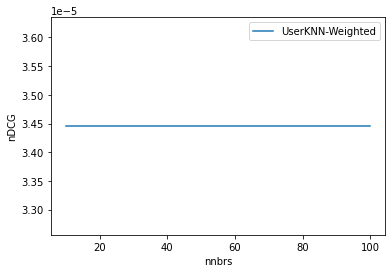

In [42]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['ndcg'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['ndcg'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('nDCG')

Text(0, 0.5, 'Precision')

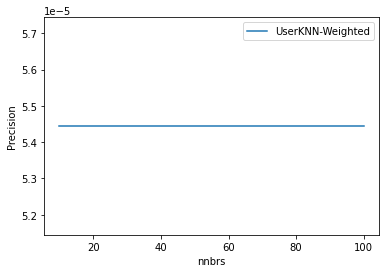

In [43]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['precision'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['precision'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('Precision')

In [44]:
#truth # user, item, rating, timestamp - 3355
#preds # RunId, user, item rating, prediction

### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
pred_acc = preds.join(runs[['name', 'nnbrs']], on = 'RunId')
pred_acc.head()


#from lenskit.metrics.predict import rmse
#rmse(preds['prediction'], preds['rating'])

,RunId,user,item,rating,prediction,name,nnbrs
0,1,6,4975,1.5,2.552706,UserKNN-Weighted,10
1,1,6,4641,1.5,3.717316,UserKNN-Weighted,10
2,1,6,2761,4.5,3.511319,UserKNN-Weighted,10
3,1,6,2723,3.0,2.904056,UserKNN-Weighted,10
4,1,6,1285,4.5,3.277767,UserKNN-Weighted,10


In [46]:
pred_acc.loc[pred_acc['prediction'] > 5,'prediction'] = 5
pred_acc.loc[pred_acc['prediction'] < 1,'prediction'] = 1

pred_acc['se'] = (pred_acc['rating'] - pred_acc['prediction'])**2


#pred_acc.groupby(['AlgoClass', 'nnbrs'])['rating','prediction'])


#ndcg.fillna(0).groupby(['AlgoClass', 'nnbrs'])['ndcg','precision'].mean()

In [47]:
import numpy as np
#from np import sqrt
np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean())

name              nnbrs
UserKNN-Weighted  10       0.924129
                  25       0.913924
                  50       0.914264
                  75       0.914752
                  100      0.915039
Name: se, dtype: float64

Text(0, 0.5, 'RMSE')

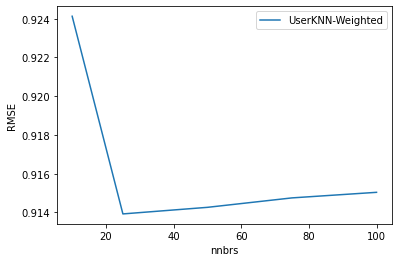

In [48]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
knn_pred_scores = np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean()).reset_index()
knn_pred_scores.head()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in knn_pred_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['se'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('RMSE')